In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels as sm
import json

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# General parameters
AVERAGE_REPLICATES = False # If True: averages the expression values for replicates
DISABLE_PLOTS = False # If True: disables plots showing on the notebook and displays in separated windows
NB_GENES_TO_PLOT = 5 # Number of genes to plot when plotting expression vs lines on bar plots

if DISABLE_PLOTS:
    %matplotlib auto

# Data loading and processing

In [4]:
PATH = "./Data/"

TRANSCRIPTION_DATA = "The40TranscriptomeExpressionData.txt"
COGNITION_GENE_NAMES = "FlyBase_IDs_cognition.txt"
NOMENCLATURE_CONVERSION = "Supplementary_Table1.xls"

In [5]:
# Genes related to cognition from the flybase
cognition_gene_names = pd.read_csv(PATH + COGNITION_GENE_NAMES)
cognition_gene_names.head()

Genes
0  FBgn0000017
1  FBgn0000108
2  FBgn0000117
3  FBgn0000119
4  FBgn0000229

In [6]:
# Gene names corresponding to each probe 
mapping_gene_names = pd.read_excel(PATH + NOMENCLATURE_CONVERSION, sheet_name = 'Sheet1',usecols = [0, 1], skiprows = 1,
                                        names = ['Probe_Set_ID', 'Flybase_ID'])
mapping_gene_names.head()
print(mapping_gene_names.Probe_Set_ID.is_unique) # Unique Probe IDs
print(mapping_gene_names.Flybase_ID.is_unique) # Not unique Gene IDs -> several probes for some genes

True
False


In [7]:
# Transcription data
transcription_data = pd.read_csv(PATH + TRANSCRIPTION_DATA, delimiter = '\t')
transcription_data.head()

line   RAL_208   RAL_301   RAL_303   RAL_304   RAL_306   RAL_307  \
0           sex         F         F         F         F         F         F   
1  1616608_a_at  15.34089   14.8836  15.10934   15.0655  15.29711  15.34147   
2    1622893_at  15.48201  15.19875  15.62585  15.43466  14.33776  16.07486   
3    1622894_at  9.884323  10.17622  9.829903   9.52355   10.0237  10.63268   
4    1622896_at  10.72857  10.95705  10.60082  10.52731  10.61231  11.20854   

    RAL_313   RAL_315   RAL_324  ... RAL_714.1 RAL_730.1 RAL_732.1 RAL_765.1  \
0         F         F         F  ...         M         M         M         M   
1  15.00705  14.85825  14.77313  ...  14.77469  14.90055   14.8767  15.10768   
2  14.73604  15.56765  15.54431  ...  15.58616  15.61801  15.51449  14.73595   
3  10.33599  10.15088  10.09022  ...  10.08153  10.82765  9.856011  10.02582   
4   10.5882  11.03945  10.56723  ...  10.70573  10.98022  10.97839  10.89569   

  RAL_774.1 RAL_786.1 RAL_799.1 RAL_820.1 RAL_852.1 RAL_859.1  
0         M         M         M         M         M         M  
1  14.75526  15.03041  15.33577   14.8753   15.0519  15.07721  
2  15.34708  15.51292   14.9367  15.40703  14.97601  15.61162  
3  9.885428  9.727585  9.834723  10.11832  9.736137  10.30634  
4  10.97371   10.1024  10.42428  10.52321   10.4534  10.43409  

[5 rows x 81 columns]

In [8]:
# Create the conversion table between probe names and gene names
mapping = dict(zip(mapping_gene_names.Probe_Set_ID, mapping_gene_names.Flybase_ID))

In [9]:
# Apply the mapping to the transcription data table
transcription_data['line'] = transcription_data['line'].map(mapping)

# Just to reset the name of the sex column after having applied the mapping
transcription_data.iloc[0,0] = 'sex'

In [10]:
transcription_data.head()

line   RAL_208   RAL_301   RAL_303   RAL_304  \
0                          sex         F         F         F         F   
1                  FBgn0001128  15.34089   14.8836  15.10934   15.0655   
2  FBgn0031035 /// FBgn0040736  15.48201  15.19875  15.62585  15.43466   
3                  FBgn0034454  9.884323  10.17622  9.829903   9.52355   
4                  FBgn0038966  10.72857  10.95705  10.60082  10.52731   

    RAL_306   RAL_307   RAL_313   RAL_315   RAL_324  ... RAL_714.1 RAL_730.1  \
0         F         F         F         F         F  ...         M         M   
1  15.29711  15.34147  15.00705  14.85825  14.77313  ...  14.77469  14.90055   
2  14.33776  16.07486  14.73604  15.56765  15.54431  ...  15.58616  15.61801   
3   10.0237  10.63268  10.33599  10.15088  10.09022  ...  10.08153  10.82765   
4  10.61231  11.20854   10.5882  11.03945  10.56723  ...  10.70573  10.98022   

  RAL_732.1 RAL_765.1 RAL_774.1 RAL_786.1 RAL_799.1 RAL_820.1 RAL_852.1  \
0         M         M         M         M         M         M         M   
1   14.8767  15.10768  14.75526  15.03041  15.33577   14.8753   15.0519   
2  15.51449  14.73595  15.34708  15.51292   14.9367  15.40703  14.97601   
3  9.856011  10.02582  9.885428  9.727585  9.834723  10.11832  9.736137   
4  10.97839  10.89569  10.97371   10.1024  10.42428  10.52321   10.4534   

  RAL_859.1  
0         M  
1  15.07721  
2  15.61162  
3  10.30634  
4  10.43409  

[5 rows x 81 columns]

In [11]:
# Now encode the sex as a binary variable
transcription_data.replace('M', 0.0, inplace=True) # Males: 0
transcription_data.replace('F', 1.0, inplace=True) # Females: 1
sex = transcription_data.loc[0]
transcription_data.head()

line   RAL_208   RAL_301   RAL_303   RAL_304  \
0                          sex         1         1         1         1   
1                  FBgn0001128  15.34089   14.8836  15.10934   15.0655   
2  FBgn0031035 /// FBgn0040736  15.48201  15.19875  15.62585  15.43466   
3                  FBgn0034454  9.884323  10.17622  9.829903   9.52355   
4                  FBgn0038966  10.72857  10.95705  10.60082  10.52731   

    RAL_306   RAL_307   RAL_313   RAL_315   RAL_324  ... RAL_714.1 RAL_730.1  \
0         1         1         1         1         1  ...         0         0   
1  15.29711  15.34147  15.00705  14.85825  14.77313  ...  14.77469  14.90055   
2  14.33776  16.07486  14.73604  15.56765  15.54431  ...  15.58616  15.61801   
3   10.0237  10.63268  10.33599  10.15088  10.09022  ...  10.08153  10.82765   
4  10.61231  11.20854   10.5882  11.03945  10.56723  ...  10.70573  10.98022   

  RAL_732.1 RAL_765.1 RAL_774.1 RAL_786.1 RAL_799.1 RAL_820.1 RAL_852.1  \
0         0         0         0         0         0         0         0   
1   14.8767  15.10768  14.75526  15.03041  15.33577   14.8753   15.0519   
2  15.51449  14.73595  15.34708  15.51292   14.9367  15.40703  14.97601   
3  9.856011  10.02582  9.885428  9.727585  9.834723  10.11832  9.736137   
4  10.97839  10.89569  10.97371   10.1024  10.42428  10.52321   10.4534   

  RAL_859.1  
0         0  
1  15.07721  
2  15.61162  
3  10.30634  
4  10.43409  

[5 rows x 81 columns]

In [12]:
transcription_data.set_index('line', inplace=True)
transcription_data.head()

RAL_208   RAL_301   RAL_303   RAL_304   RAL_306  \
line                                                                            
sex                                 1         1         1         1         1   
FBgn0001128                  15.34089   14.8836  15.10934   15.0655  15.29711   
FBgn0031035 /// FBgn0040736  15.48201  15.19875  15.62585  15.43466  14.33776   
FBgn0034454                  9.884323  10.17622  9.829903   9.52355   10.0237   
FBgn0038966                  10.72857  10.95705  10.60082  10.52731  10.61231   

                              RAL_307   RAL_313   RAL_315   RAL_324   RAL_335  \
line                                                                            
sex                                 1         1         1         1         1   
FBgn0001128                  15.34147  15.00705  14.85825  14.77313  14.63788   
FBgn0031035 /// FBgn0040736  16.07486  14.73604  15.56765  15.54431  14.98228   
FBgn0034454                  10.63268  10.33599  10.15088  10.09022   9.81207   
FBgn0038966                  11.20854   10.5882  11.03945  10.56723  10.72114   

                             ... RAL_714.1 RAL_730.1 RAL_732.1 RAL_765.1  \
line                         ...                                           
sex                          ...         0         0         0         0   
FBgn0001128                  ...  14.77469  14.90055   14.8767  15.10768   
FBgn0031035 /// FBgn0040736  ...  15.58616  15.61801  15.51449  14.73595   
FBgn0034454                  ...  10.08153  10.82765  9.856011  10.02582   
FBgn0038966                  ...  10.70573  10.98022  10.97839  10.89569   

                            RAL_774.1 RAL_786.1 RAL_799.1 RAL_820.1 RAL_852.1  \
line                                                                            
sex                                 0         0         0         0         0   
FBgn0001128                  14.75526  15.03041  15.33577   14.8753   15.0519   
FBgn0031035 /// FBgn0040736  15.34708  15.51292   14.9367  15.40703  14.97601   
FBgn0034454                  9.885428  9.727585  9.834723  10.11832  9.736137   
FBgn0038966                  10.97371   10.1024  10.42428  10.52321   10.4534   

                            RAL_859.1  
line                                   
sex                                 0  
FBgn0001128                  15.07721  
FBgn0031035 /// FBgn0040736  15.61162  
FBgn0034454                  10.30634  
FBgn0038966                  10.43409  

[5 rows x 80 columns]

In [13]:
# Convert the data to floats to then perform operations on expression values
transcription_data = transcription_data.astype(float)
print(transcription_data.dtypes)

RAL_208      float64
RAL_301      float64
RAL_303      float64
RAL_304      float64
RAL_306      float64
              ...   
RAL_786.1    float64
RAL_799.1    float64
RAL_820.1    float64
RAL_852.1    float64
RAL_859.1    float64
Length: 80, dtype: object


In [14]:
# Sum the expression levels recording for probes that correspond to the same gene (since it reflects the number of transcripts for this gene)
grouped = transcription_data.groupby(['line']).sum()
grouped.head()

RAL_208      RAL_301      RAL_303      RAL_304      RAL_306  \
line                                                                           
---          4221.780754  4216.170955  4215.570380  4205.039650  4199.049534   
CG11853        12.719230    12.557990    12.812670    12.236750    12.442050   
FBgn0000008    10.968470    10.783060    10.657490    10.906660    10.463530   
FBgn0000011     9.724721     9.269347     9.423425     9.227149     9.770052   
FBgn0000014     9.485435     9.633905     9.438266     9.515983     9.601710   

                 RAL_307      RAL_313      RAL_315      RAL_324      RAL_335  \
line                                                                           
---          4255.550917  4222.249915  4223.141281  4234.940285  4213.755001   
CG11853        12.285450    12.003190    12.017690    12.285210    12.246050   
FBgn0000008    10.599790    10.553230    10.900330    10.525450    10.088330   
FBgn0000011     9.492927     9.495222     9.412189     9.732272     9.552688   
FBgn0000014     9.434828     9.530226     9.466020     9.363816     9.663647   

             ...    RAL_714.1    RAL_730.1    RAL_732.1    RAL_765.1  \
line         ...                                                       
---          ...  4309.182999  4325.195410  4310.073014  4323.788894   
CG11853      ...    11.718680    12.689540    12.747290    11.811050   
FBgn0000008  ...     9.922413     9.738775     9.967959     9.865257   
FBgn0000011  ...     9.168025     9.126094     9.296817     9.194355   
FBgn0000014  ...     9.542980     9.381340     9.507850     9.466904   

               RAL_774.1    RAL_786.1    RAL_799.1    RAL_820.1    RAL_852.1  \
line                                                                           
---          4338.259724  4325.492655  4325.808379  4293.618653  4320.373595   
CG11853        12.621750    12.237330    12.023220    11.780990    12.436000   
FBgn0000008     9.898795     9.754535     9.650915     9.798716     9.973386   
FBgn0000011     9.290895     9.415978     9.120563     9.346430     9.464989   
FBgn0000014     9.550533     9.654498     9.325283     9.667318     9.271917   

               RAL_859.1  
line                      
---          4351.404408  
CG11853        12.489910  
FBgn0000008     9.733179  
FBgn0000011     9.252230  
FBgn0000014     9.445289  

[5 rows x 80 columns]

In [15]:
# Drop missing values and values not corresponding to any gene
grouped.dropna(inplace=True)
grouped.drop(index='---', inplace=True)
grouped.head()

RAL_208    RAL_301    RAL_303    RAL_304    RAL_306    RAL_307  \
line                                                                            
CG11853      12.719230  12.557990  12.812670  12.236750  12.442050  12.285450   
FBgn0000008  10.968470  10.783060  10.657490  10.906660  10.463530  10.599790   
FBgn0000011   9.724721   9.269347   9.423425   9.227149   9.770052   9.492927   
FBgn0000014   9.485435   9.633905   9.438266   9.515983   9.601710   9.434828   
FBgn0000015  10.225240   9.600467  10.057940  10.010230  10.150760  10.224460   

               RAL_313    RAL_315    RAL_324    RAL_335  ...  RAL_714.1  \
line                                                     ...              
CG11853      12.003190  12.017690  12.285210  12.246050  ...  11.718680   
FBgn0000008  10.553230  10.900330  10.525450  10.088330  ...   9.922413   
FBgn0000011   9.495222   9.412189   9.732272   9.552688  ...   9.168025   
FBgn0000014   9.530226   9.466020   9.363816   9.663647  ...   9.542980   
FBgn0000015   9.918846   9.750653  10.138040   9.954639  ...  10.742280   

             RAL_730.1  RAL_732.1  RAL_765.1  RAL_774.1  RAL_786.1  RAL_799.1  \
line                                                                            
CG11853      12.689540  12.747290  11.811050  12.621750  12.237330  12.023220   
FBgn0000008   9.738775   9.967959   9.865257   9.898795   9.754535   9.650915   
FBgn0000011   9.126094   9.296817   9.194355   9.290895   9.415978   9.120563   
FBgn0000014   9.381340   9.507850   9.466904   9.550533   9.654498   9.325283   
FBgn0000015  10.539940  10.539940  10.735130  10.592880  10.527420  10.702770   

             RAL_820.1  RAL_852.1  RAL_859.1  
line                                          
CG11853      11.780990  12.436000  12.489910  
FBgn0000008   9.798716   9.973386   9.733179  
FBgn0000011   9.346430   9.464989   9.252230  
FBgn0000014   9.667318   9.271917   9.445289  
FBgn0000015  10.600160  10.635090  10.474280  

[5 rows x 80 columns]

In [16]:
# Just transpose for easily handling data then
transcription_data_ = grouped.T.copy()
transcription_data_.head()

line      CG11853  FBgn0000008  FBgn0000011  FBgn0000014  FBgn0000015  \
RAL_208  12.71923     10.96847     9.724721     9.485435    10.225240   
RAL_301  12.55799     10.78306     9.269347     9.633905     9.600467   
RAL_303  12.81267     10.65749     9.423425     9.438266    10.057940   
RAL_304  12.23675     10.90666     9.227149     9.515983    10.010230   
RAL_306  12.44205     10.46353     9.770052     9.601710    10.150760   

line     FBgn0000017  FBgn0000018  FBgn0000024  FBgn0000028  FBgn0000032  ...  \
RAL_208     10.04708     10.98815     10.57433     9.267361     11.89597  ...   
RAL_301     10.20872     11.13205     10.37770     9.225645     12.48399  ...   
RAL_303     10.17096     10.86014     10.61116     9.235159     12.50204  ...   
RAL_304     10.17596     11.17082     10.73120     9.085232     12.35876  ...   
RAL_306     10.01347     11.14600     10.81721     9.076431     12.41044  ...   

line     FBgn0069938  FBgn0069964 /// FBgn0058084 /// FBgn0058271  \
RAL_208     9.590561                                     9.211811   
RAL_301     9.588649                                     9.189190   
RAL_303     9.613943                                     9.209578   
RAL_304     9.528923                                     9.871735   
RAL_306     9.605901                                     9.025304   

line     FBgn0069969  FBgn0069972  FBgn0069973  FBgn0069977  FBgn0082585  \
RAL_208    10.090610     11.25073     21.12486     10.30374    10.586000   
RAL_301     9.665224     12.51409     21.29030     10.18817    10.326890   
RAL_303    10.073570     11.94908     21.08371     10.18915    10.314670   
RAL_304     9.544675     12.35085     21.73403     10.25910     9.849529   
RAL_306    10.079680     12.31612     21.41596     10.36034    10.289380   

line     FBgn0082598  FBgn0083141  sex  
RAL_208     14.03424     9.439410  1.0  
RAL_301     14.28169     9.194738  1.0  
RAL_303     14.12857     9.598054  1.0  
RAL_304     13.81643     9.140153  1.0  
RAL_306     13.80845     9.074527  1.0  

[5 rows x 9305 columns]

In [17]:
transcription_data_.reset_index(inplace=True)
transcription_data_.rename(columns={'index': 'line'}, index={'line': 'idx'}, inplace=True)

In [18]:
transcription_data_.head()

line     line   CG11853  FBgn0000008  FBgn0000011  FBgn0000014  FBgn0000015  \
0     RAL_208  12.71923     10.96847     9.724721     9.485435    10.225240   
1     RAL_301  12.55799     10.78306     9.269347     9.633905     9.600467   
2     RAL_303  12.81267     10.65749     9.423425     9.438266    10.057940   
3     RAL_304  12.23675     10.90666     9.227149     9.515983    10.010230   
4     RAL_306  12.44205     10.46353     9.770052     9.601710    10.150760   

line  FBgn0000017  FBgn0000018  FBgn0000024  FBgn0000028  ...  FBgn0069938  \
0        10.04708     10.98815     10.57433     9.267361  ...     9.590561   
1        10.20872     11.13205     10.37770     9.225645  ...     9.588649   
2        10.17096     10.86014     10.61116     9.235159  ...     9.613943   
3        10.17596     11.17082     10.73120     9.085232  ...     9.528923   
4        10.01347     11.14600     10.81721     9.076431  ...     9.605901   

line  FBgn0069964 /// FBgn0058084 /// FBgn0058271  FBgn0069969  FBgn0069972  \
0                                        9.211811    10.090610     11.25073   
1                                        9.189190     9.665224     12.51409   
2                                        9.209578    10.073570     11.94908   
3                                        9.871735     9.544675     12.35085   
4                                        9.025304    10.079680     12.31612   

line  FBgn0069973  FBgn0069977  FBgn0082585  FBgn0082598  FBgn0083141  sex  
0        21.12486     10.30374    10.586000     14.03424     9.439410  1.0  
1        21.29030     10.18817    10.326890     14.28169     9.194738  1.0  
2        21.08371     10.18915    10.314670     14.12857     9.598054  1.0  
3        21.73403     10.25910     9.849529     13.81643     9.140153  1.0  
4        21.41596     10.36034    10.289380     13.80845     9.074527  1.0  

[5 rows x 9306 columns]

### The following cell averages duplicates when AVERAGE_REPLICATE is set to True (may mask some sex-specific effects since replicates are of the opposite sex) 

In [19]:
if(AVERAGE_REPLICATES):
    # Remove duplicate index '.1' at the end of the line name
    transcription_data_['line'] = transcription_data_.apply(lambda x: str(x['line'])[:-2] if len(str(x['line'])) > 7 else str(x['line']), axis=1)

    # Average the expression levels between replicates
    transcription_data_ = transcription_data_.groupby(['line']).mean()
    transcription_data_.reset_index(inplace=True)
else:
    print("Set the variable AVERAGE_REPLICATES to True if you want to average gene expression over replicates")

Set the variable AVERAGE_REPLICATES to True if you want to average gene expression over replicates


In [20]:
# Separate expression data from females and males in different dataframes
females_transcription = transcription_data_[transcription_data_['sex'] == 1.0].copy()
males_transcription = transcription_data_[transcription_data_['sex'] == 0.0].copy()
# Remove duplicate index '.1' at the end on the line name for males
males_transcription['line'] = males_transcription.apply(lambda x: str(x['line'])[:-2] if len(str(x['line'])) > 7 else str(x['line']), axis=1)

In [21]:
females_transcription.head()

line     line   CG11853  FBgn0000008  FBgn0000011  FBgn0000014  FBgn0000015  \
0     RAL_208  12.71923     10.96847     9.724721     9.485435    10.225240   
1     RAL_301  12.55799     10.78306     9.269347     9.633905     9.600467   
2     RAL_303  12.81267     10.65749     9.423425     9.438266    10.057940   
3     RAL_304  12.23675     10.90666     9.227149     9.515983    10.010230   
4     RAL_306  12.44205     10.46353     9.770052     9.601710    10.150760   

line  FBgn0000017  FBgn0000018  FBgn0000024  FBgn0000028  ...  FBgn0069938  \
0        10.04708     10.98815     10.57433     9.267361  ...     9.590561   
1        10.20872     11.13205     10.37770     9.225645  ...     9.588649   
2        10.17096     10.86014     10.61116     9.235159  ...     9.613943   
3        10.17596     11.17082     10.73120     9.085232  ...     9.528923   
4        10.01347     11.14600     10.81721     9.076431  ...     9.605901   

line  FBgn0069964 /// FBgn0058084 /// FBgn0058271  FBgn0069969  FBgn0069972  \
0                                        9.211811    10.090610     11.25073   
1                                        9.189190     9.665224     12.51409   
2                                        9.209578    10.073570     11.94908   
3                                        9.871735     9.544675     12.35085   
4                                        9.025304    10.079680     12.31612   

line  FBgn0069973  FBgn0069977  FBgn0082585  FBgn0082598  FBgn0083141  sex  
0        21.12486     10.30374    10.586000     14.03424     9.439410  1.0  
1        21.29030     10.18817    10.326890     14.28169     9.194738  1.0  
2        21.08371     10.18915    10.314670     14.12857     9.598054  1.0  
3        21.73403     10.25910     9.849529     13.81643     9.140153  1.0  
4        21.41596     10.36034    10.289380     13.80845     9.074527  1.0  

[5 rows x 9306 columns]

In [22]:
males_transcription.head()

line     line   CG11853  FBgn0000008  FBgn0000011  FBgn0000014  FBgn0000015  \
40    RAL_208  12.98904    10.378310     9.269907     9.426063     10.62165   
41    RAL_301  12.61287     9.921718     9.533538     9.519790     10.45883   
42    RAL_303  12.79056     9.782210     9.246306     9.713865     10.60882   
43    RAL_304  12.46022    10.012490     9.213922     9.859203     10.55979   
44    RAL_306  12.85280     9.864805     9.183702     9.638587     10.60891   

line  FBgn0000017  FBgn0000018  FBgn0000024  FBgn0000028  ...  FBgn0069938  \
40       9.615271     10.41731     10.72343     9.592880  ...     11.22983   
41       9.871511     10.30179     10.47235     9.575568  ...     10.64852   
42       9.663526     10.32054     11.09693     9.632714  ...     11.01375   
43       9.670059     10.24964     11.03280     9.616298  ...     11.11167   
44       9.702545     10.29064     11.25682     9.583758  ...     10.94805   

line  FBgn0069964 /// FBgn0058084 /// FBgn0058271  FBgn0069969  FBgn0069972  \
40                                       9.149747    10.340970     11.58282   
41                                       9.457739    10.205410     12.24894   
42                                       9.105854    10.324340     11.79141   
43                                       9.624511     9.959958     12.32120   
44                                       9.052084    10.263890     12.39203   

line  FBgn0069973  FBgn0069977  FBgn0082585  FBgn0082598  FBgn0083141  sex  
40       21.04293     10.61559     10.75518     13.12421     10.94098  0.0  
41       21.02163     10.50569     10.67223     12.57804     11.67059  0.0  
42       20.88120     10.42962     10.34487     12.31026     11.39687  0.0  
43       21.08930     10.50020     10.12407     12.76838     10.78171  0.0  
44       21.02554     10.77310     10.34183     12.63181     11.22492  0.0  

[5 rows x 9306 columns]

# Cognition (memory + learning)

## Females and males

In [23]:
# Convert gene names to a list
cognition_gene_names = cognition_gene_names['Genes'].to_list()
cognition_gene_names.append('line')

In [24]:
# Just keep columns in the transcription data that correspond to genes related to cognition
cognition_genes = transcription_data_.columns.intersection(cognition_gene_names)
cognition_data = transcription_data_[cognition_genes]
cognition_data.head()

line     line  FBgn0000017  FBgn0000108  FBgn0000119  FBgn0000273  \
0     RAL_208     10.04708     11.12222     10.55853     21.05188   
1     RAL_301     10.20872     11.19351     10.62853     24.23164   
2     RAL_303     10.17096     11.07512     10.90554     22.34808   
3     RAL_304     10.17596     11.54614     10.78695     22.10240   
4     RAL_306     10.01347     11.59569     10.69100     21.67665   

line  FBgn0000422  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  ...  \
0        11.07408     10.82154     9.527054     14.13703     13.36813  ...   
1        11.05320     10.88035     9.658879     14.26520     13.61266  ...   
2        11.25881     10.75769     9.599550     14.10461     13.51797  ...   
3        11.20053     11.20712     9.716882     14.28684     14.03130  ...   
4        11.38234     11.02811     9.470495     14.24505     14.03102  ...   

line  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  FBgn0052062  \
0        14.63447     10.18300     10.69253    19.484154     11.13320   
1        14.72518     10.16004     11.84545    21.019710     11.01258   
2        14.62178     10.23010     10.08896    19.618740     11.05417   
3        14.68856     10.38333     10.23377    19.706640     11.12872   
4        14.74778     10.25264     10.47261    19.421406     11.15641   

line  FBgn0052179  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
0        11.11092     9.228790     9.382670     11.77405     11.31423  
1        11.20397     9.232729     9.204078     11.62965     11.39481  
2        11.01582     9.712390     9.333937     11.80197     11.35328  
3        11.17933     9.279444     9.237427     11.38304     11.34137  
4        11.10131     9.220441     9.313120     11.61773     11.46165  

[5 rows x 80 columns]

In [25]:
# Barplot visualization of the expression levels of a gene accross lines

def plot_gene_expression(gene, data_):
    sns.set() # Set the seaborn default aesthetics 
    
    df = data_.sort_values(by=[gene], ascending=False).copy()
    f, ax = plt.subplots(figsize=(18, 10))
    #ax = sns.barplot(x ='line', y =gene, data = df);
    ax = sns.scatterplot(x ='line', y =gene, data = df);

    #ax.get_legend().remove()
    ax.set_title(gene);
    ax.set(ylabel='Expression', xlabel='Lines');
    ax.set_xticklabels(data_['line'], rotation=90); # Vertical labels for the x axis

In [26]:
genes_cognition = cognition_data.columns.values.tolist()
genes_cognition.pop(0)
#genes

'line'

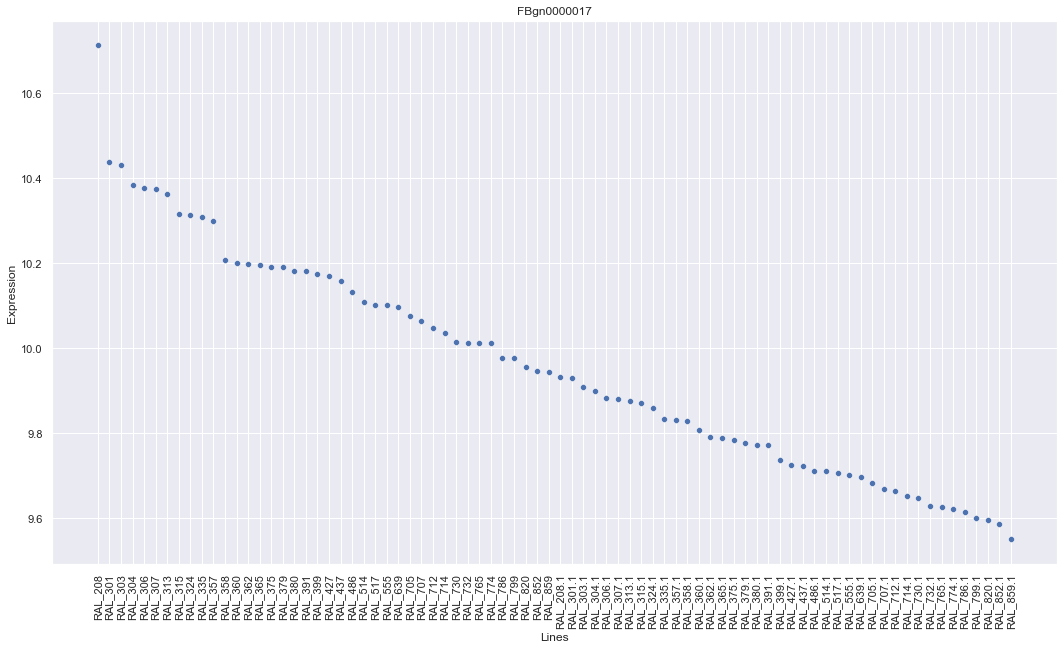

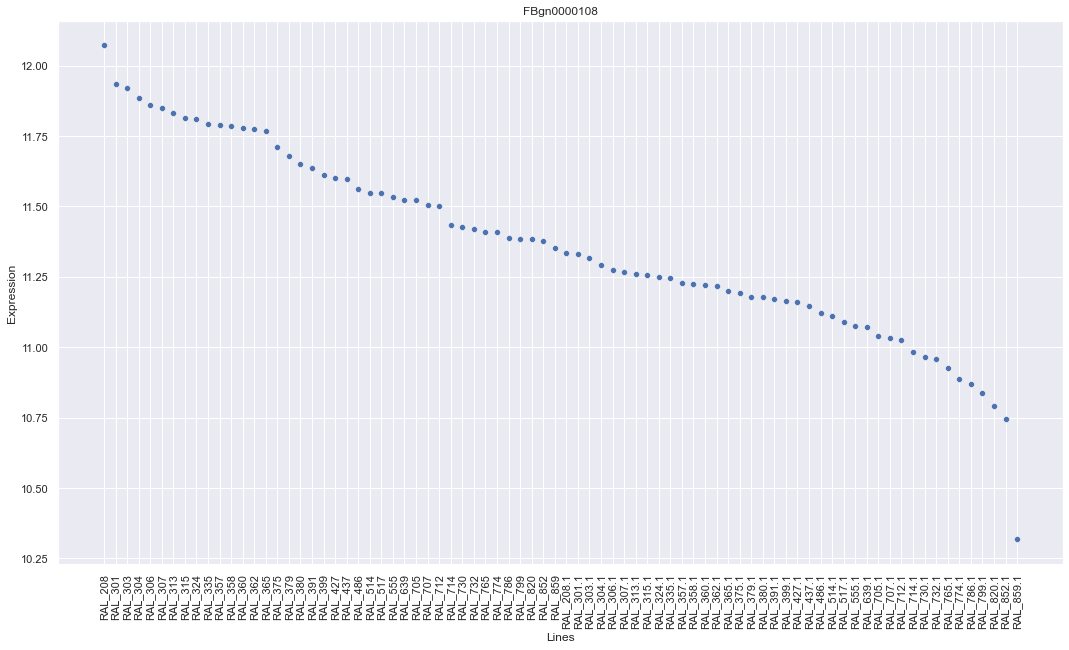

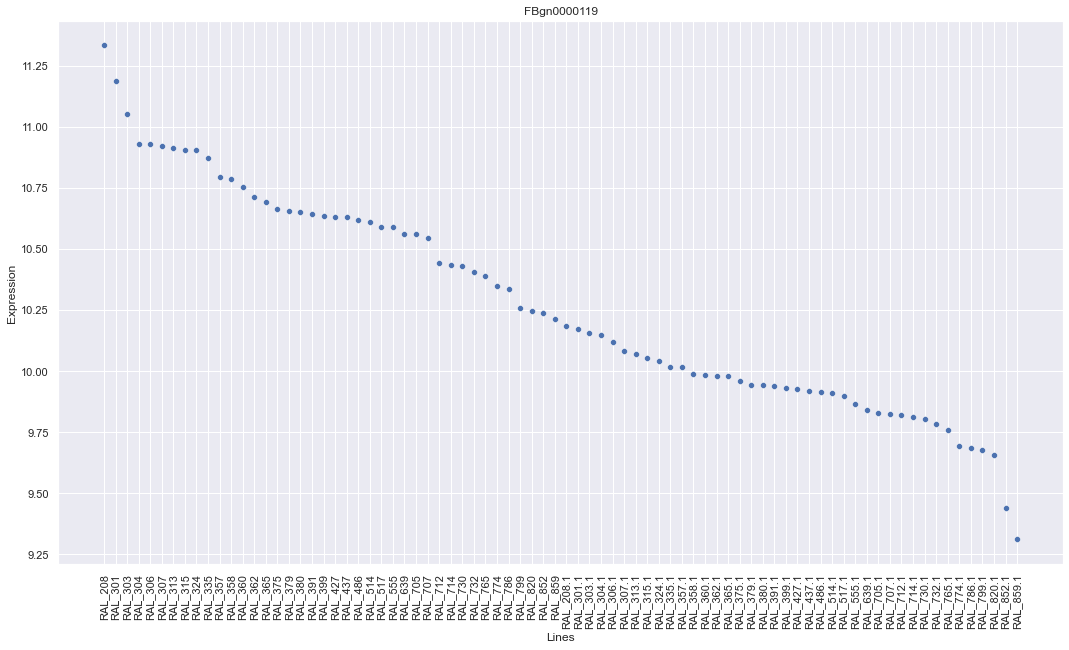

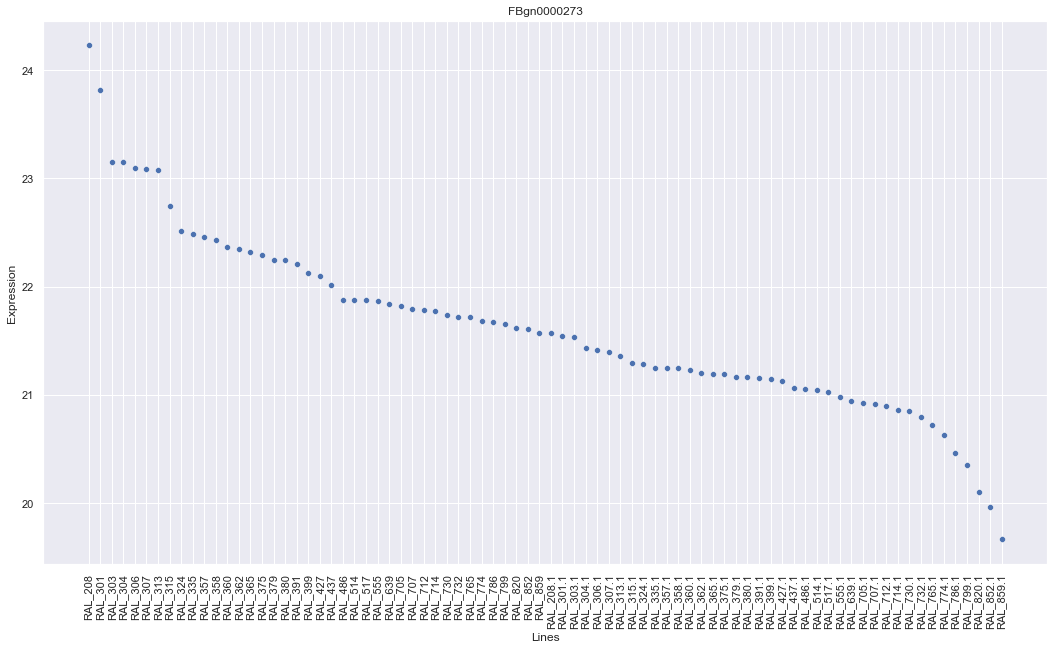

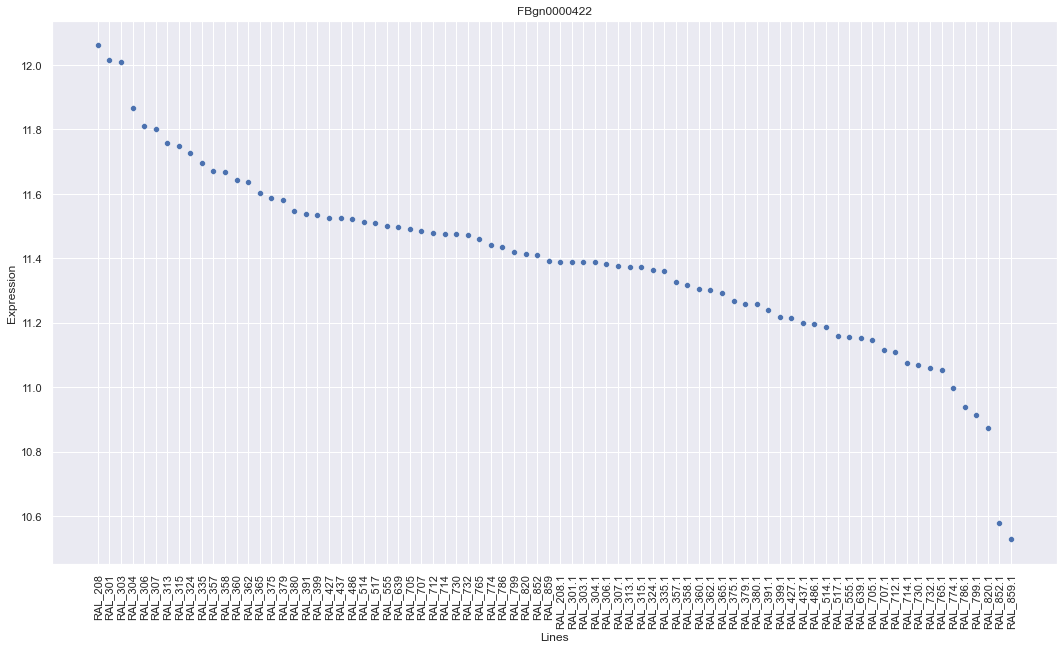

In [27]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_cognition[i], cognition_data)

→ We observe clear differences of expression between males and females for those genes related to cognition.

In [28]:
# Statistics
stats_cognition = pd.DataFrame()
stats_cognition['gene'] = genes_cognition # genes of interest

stats_cognition['variance'] = stats_cognition.apply(lambda x: cognition_data[x['gene']].var(), axis=1)
stats_cognition['std'] = stats_cognition.apply(lambda x: cognition_data[x['gene']].std(), axis=1)
stats_cognition['mean'] = stats_cognition.apply(lambda x: cognition_data[x['gene']].mean(), axis=1)
stats_cognition['min'] = stats_cognition.apply(lambda x: cognition_data[x['gene']].min(), axis=1)
stats_cognition['max'] = stats_cognition.apply(lambda x: cognition_data[x['gene']].max(), axis=1)
stats_cognition['range'] = stats_cognition.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_cognition.sort_values(by=['variance'], ascending=False, inplace=True)

stats_cognition.head()

gene  variance       std       mean        min       max     range
25  FBgn0004419  1.931019  1.389611  13.508313  11.685040  15.35207  3.667030
60  FBgn0038934  1.462188  1.209210  10.689881   9.323175  13.17652  3.853345
11  FBgn0003165  1.323314  1.150354  10.971205   9.557119  13.05292  3.495801
3   FBgn0000273  0.670887  0.819077  21.630299  19.662503  24.23164  4.569137
20  FBgn0004101  0.477877  0.691287  10.857266  10.091870  12.34653  2.254660

In [29]:
# Plot the distribution of a statistics across genes
def plot_gene_stats(stat, data_):
    sns.set() # Set the seaborn default aesthetics 

    f, ax = plt.subplots(figsize=(18, 10))
    #ax = sns.barplot(x ='gene', y =stat, data = data_);
    ax = sns.scatterplot(x ='gene', y =stat, data = data_);

    #ax.get_legend().remove()
    ax.set_title('Distribution of ' + stat);
    ax.set(ylabel='Value', xlabel='Genes');
    ax.set_xticklabels(data_['gene'], rotation=90); # Vertical labels for the x axis
    
# Plot the variance vs mean for each gene
def plot_var_vs_mean(data_):
    sns.set() # Set the seaborn default aesthetics 
    
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.scatterplot(x = 'variance', y = 'mean', data = data_);

    #ax.get_legend().remove()
    ax.set_title('Variance vs mean over genes');
    ax.set(ylabel='Variance', xlabel='Mean');

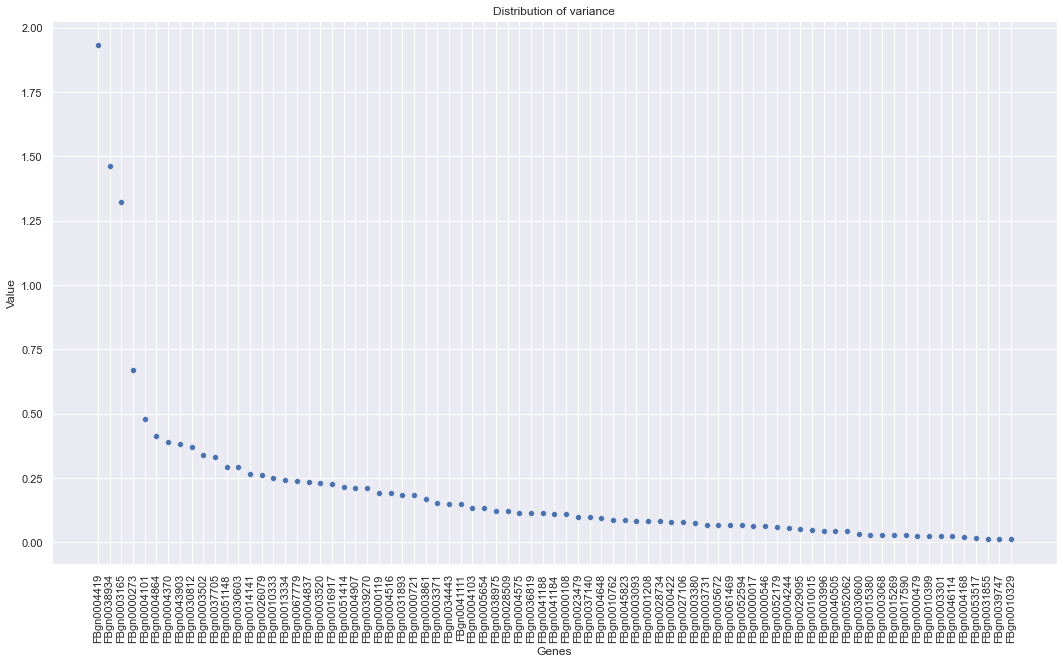

In [30]:
plot_gene_stats('variance', stats_cognition)

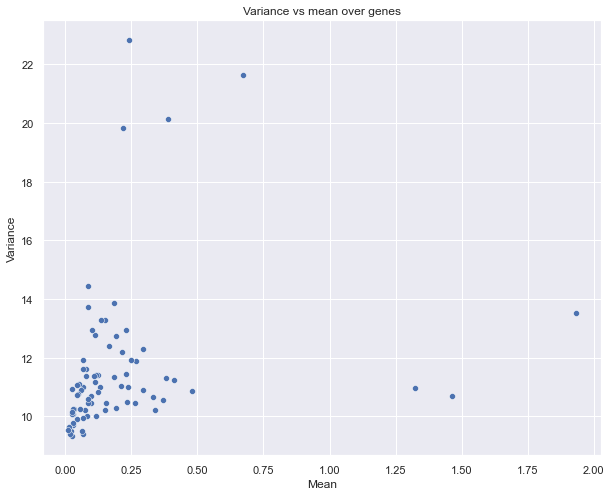

In [31]:
plot_var_vs_mean(stats_cognition)

In [32]:
var_genes = {} # Dict to store genes that show the highest variance in expression across lines
var_genes_females = {} # Females only
var_genes_males = {} # Males only

In [33]:
var_genes['cognition'] = list(stats_cognition.iloc[:10,0].values)
var_genes

{'cognition': ['FBgn0004419',
  'FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864',
  'FBgn0004370',
  'FBgn0043903',
  'FBgn0030812',
  'FBgn0003502']}

### Females

In [34]:
cognition_genes_females = females_transcription.columns.intersection(cognition_gene_names)
cognition_data_females = females_transcription[cognition_genes_females]
cognition_data_females.head()

line     line  FBgn0000017  FBgn0000108  FBgn0000119  FBgn0000273  \
0     RAL_208     10.04708     11.12222     10.55853     21.05188   
1     RAL_301     10.20872     11.19351     10.62853     24.23164   
2     RAL_303     10.17096     11.07512     10.90554     22.34808   
3     RAL_304     10.17596     11.54614     10.78695     22.10240   
4     RAL_306     10.01347     11.59569     10.69100     21.67665   

line  FBgn0000422  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  ...  \
0        11.07408     10.82154     9.527054     14.13703     13.36813  ...   
1        11.05320     10.88035     9.658879     14.26520     13.61266  ...   
2        11.25881     10.75769     9.599550     14.10461     13.51797  ...   
3        11.20053     11.20712     9.716882     14.28684     14.03130  ...   
4        11.38234     11.02811     9.470495     14.24505     14.03102  ...   

line  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  FBgn0052062  \
0        14.63447     10.18300     10.69253    19.484154     11.13320   
1        14.72518     10.16004     11.84545    21.019710     11.01258   
2        14.62178     10.23010     10.08896    19.618740     11.05417   
3        14.68856     10.38333     10.23377    19.706640     11.12872   
4        14.74778     10.25264     10.47261    19.421406     11.15641   

line  FBgn0052179  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
0        11.11092     9.228790     9.382670     11.77405     11.31423  
1        11.20397     9.232729     9.204078     11.62965     11.39481  
2        11.01582     9.712390     9.333937     11.80197     11.35328  
3        11.17933     9.279444     9.237427     11.38304     11.34137  
4        11.10131     9.220441     9.313120     11.61773     11.46165  

[5 rows x 80 columns]

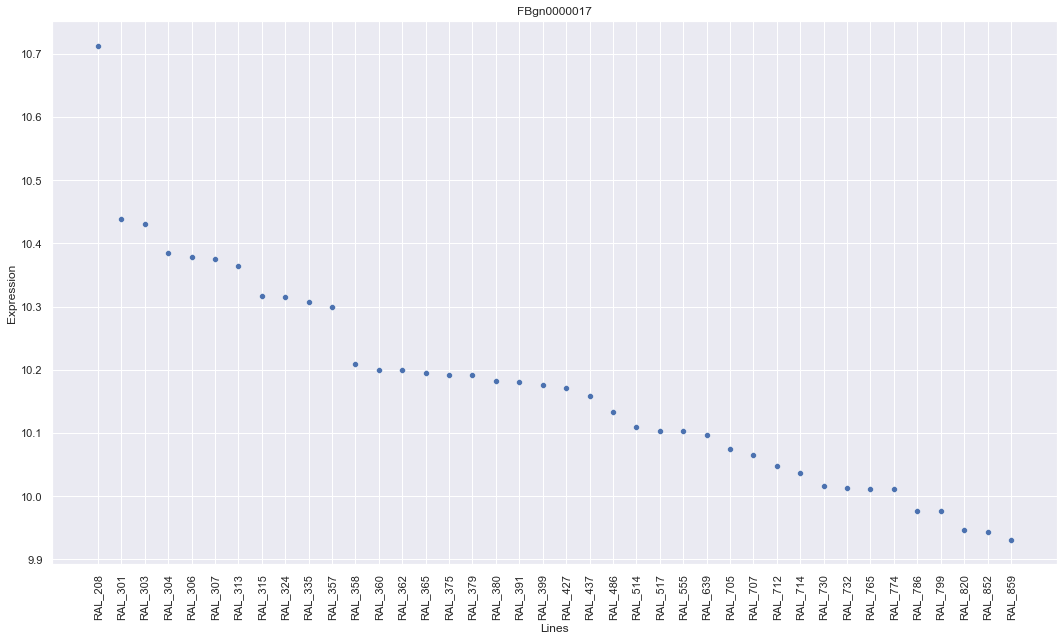

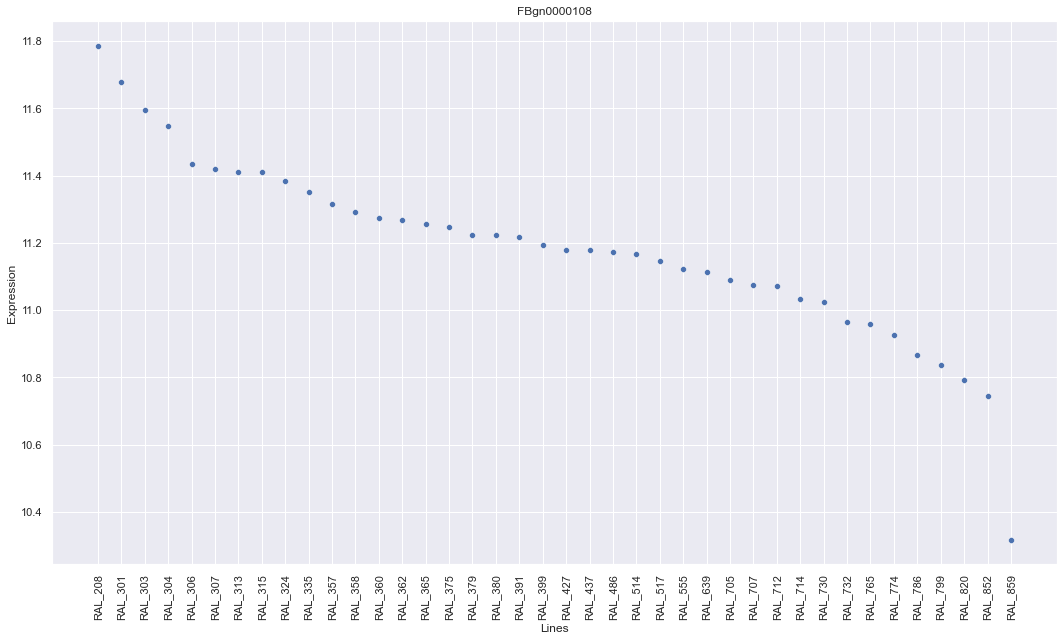

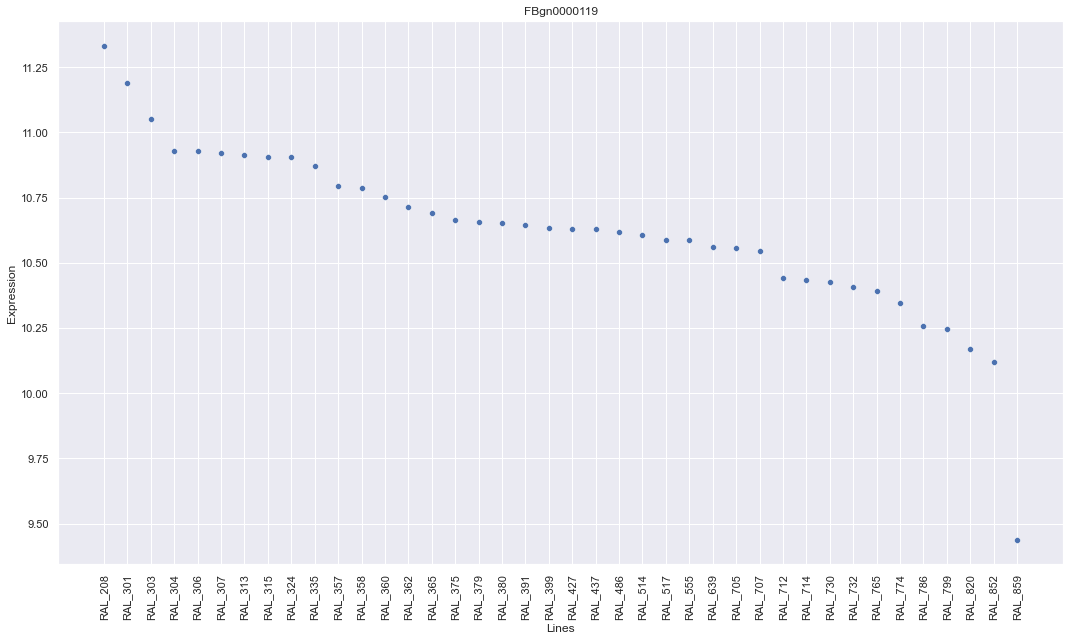

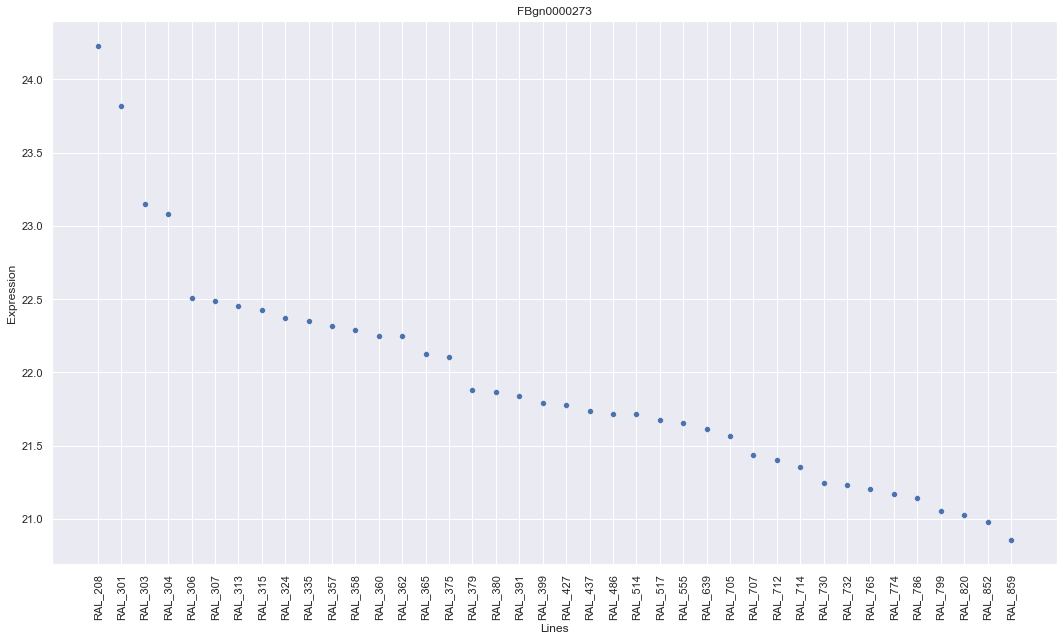

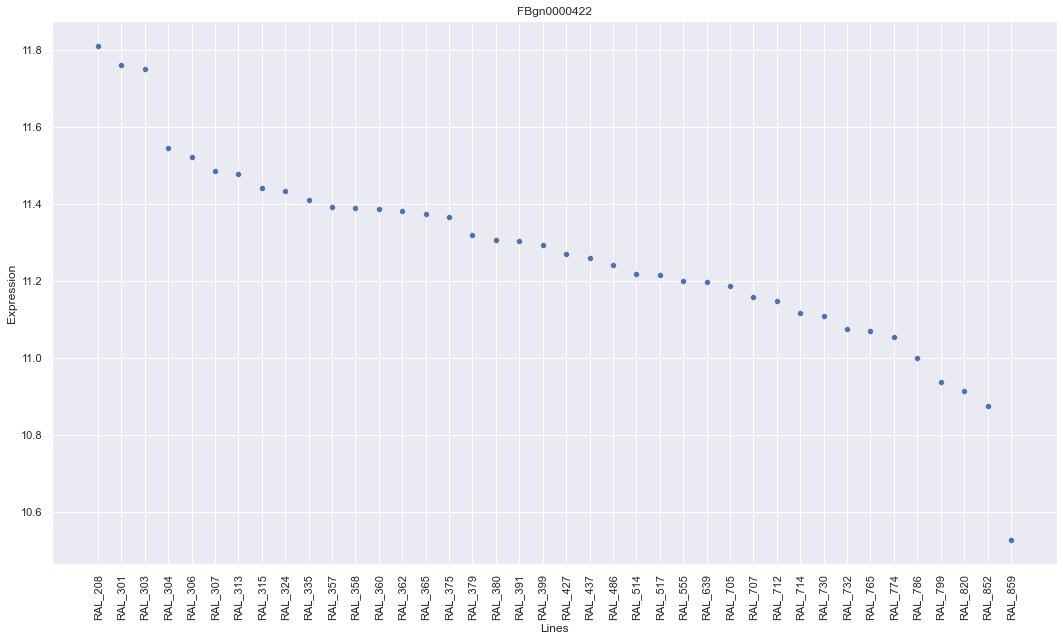

In [35]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_cognition[i], cognition_data_females)

In [36]:
# Statistics
stats_cognition_females = pd.DataFrame()
stats_cognition_females['gene'] = genes_cognition # genes of interest

stats_cognition_females['variance'] = stats_cognition_females.apply(lambda x: cognition_data_females[x['gene']].var(), axis=1)
stats_cognition_females['std'] = stats_cognition_females.apply(lambda x: cognition_data_females[x['gene']].std(), axis=1)
stats_cognition_females['mean'] = stats_cognition_females.apply(lambda x: cognition_data_females[x['gene']].mean(), axis=1)
stats_cognition_females['min'] = stats_cognition_females.apply(lambda x: cognition_data_females[x['gene']].min(), axis=1)
stats_cognition_females['max'] = stats_cognition_females.apply(lambda x: cognition_data_females[x['gene']].max(), axis=1)
stats_cognition_females['range'] = stats_cognition_females.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_cognition_females.sort_values(by=['variance'], ascending=False, inplace=True)

stats_cognition_females.head()

gene  variance       std       mean        min       max     range
3   FBgn0000273  0.551303  0.742498  21.928713  20.857580  24.23164  3.374060
71  FBgn0051148  0.304310  0.551643  10.848316   9.771085  11.99191  2.220825
16  FBgn0003520  0.229678  0.479248  11.651801  10.876280  12.81097  1.934690
39  FBgn0013334  0.210182  0.458456  22.643496  21.088460  23.72894  2.640480
24  FBgn0004370  0.199552  0.446713  20.648112  19.749405  21.61536  1.865955

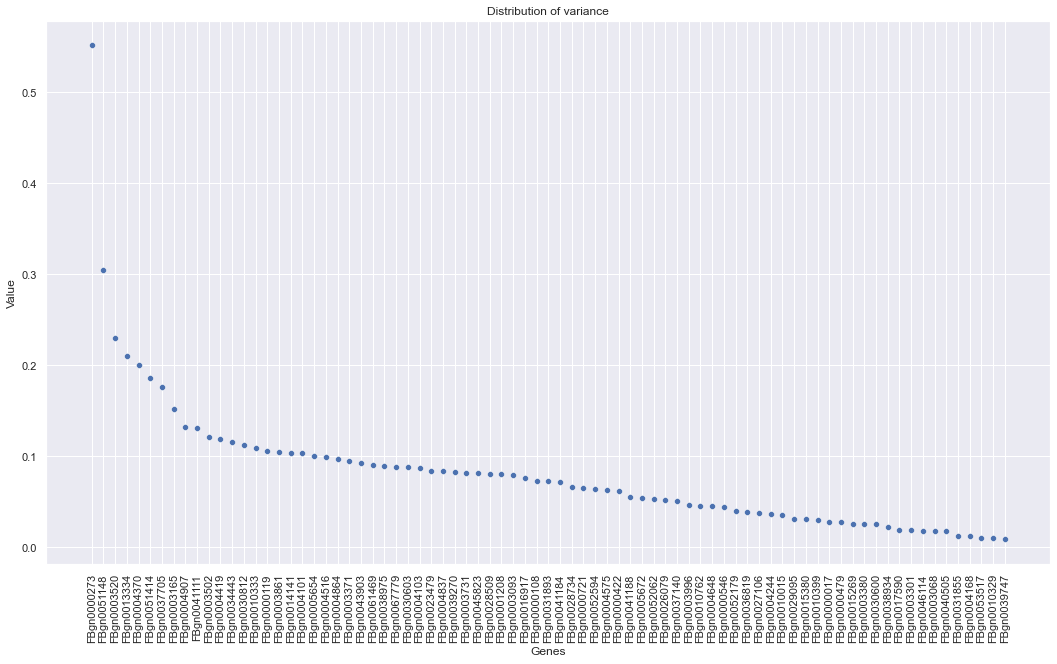

In [37]:
plot_gene_stats('variance', stats_cognition_females)

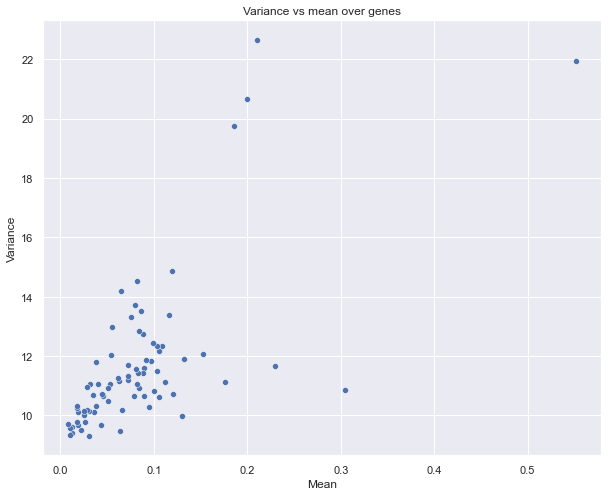

In [38]:
plot_var_vs_mean(stats_cognition_females)

In [39]:
var_genes_females['cognition'] = list(stats_cognition_females.iloc[:10,0].values)
var_genes_females

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0013334',
  'FBgn0004370',
  'FBgn0051414',
  'FBgn0037705',
  'FBgn0003165',
  'FBgn0004907',
  'FBgn0041111']}

### Males

In [40]:
cognition_genes_males = males_transcription.columns.intersection(cognition_gene_names)
cognition_data_males = males_transcription[cognition_genes_males]
cognition_data_males.head()

line     line  FBgn0000017  FBgn0000108  FBgn0000119  FBgn0000273  \
40    RAL_208     9.615271     11.32973     9.939225     20.79381   
41    RAL_301     9.871511     11.03826     9.943818     23.08654   
42    RAL_303     9.663526     11.33572     9.829803     22.20897   
43    RAL_304     9.670059     11.84783    10.146930     20.94015   
44    RAL_306     9.702545     11.93511     9.781580     21.15718   

line  FBgn0000422  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  ...  \
40       11.36114     10.68688     9.283833     13.67858     13.44488  ...   
41       11.25951     10.75597     9.417577     13.07805     13.59428  ...   
42       11.41197     10.75876     9.419011     13.35700     13.49639  ...   
43       11.60131     11.05709     9.386425     13.57316     14.29718  ...   
44       11.49639     11.10029     9.094382     13.71727     14.06162  ...   

line  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  FBgn0052062  \
40       14.45439     10.21750     10.89426    19.973497     11.00726   
41       14.24313     10.00278     12.44683    21.197886     10.91640   
42       14.12330     10.04849     10.71158    19.702708     11.01503   
43       14.65261     10.12475     11.21948    20.330065     11.25046   
44       14.33828     10.08085     10.82261    19.666373     11.09384   

line  FBgn0052179  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
40       10.90247     9.027996     9.380091     11.58163     10.66929  
41       10.59791     9.280142     9.581348     11.75157     10.49130  
42       10.60842     9.695497     9.363155     11.69343     10.38450  
43       10.80292     9.161429     9.376358     11.46247     10.38933  
44       10.64561     9.106664     9.468334     11.48798     10.37957  

[5 rows x 80 columns]

In [41]:
# Statistics
stats_cognition_males = pd.DataFrame()
stats_cognition_males['gene'] = genes_cognition # genes of interest

stats_cognition_males['variance'] = stats_cognition_males.apply(lambda x: cognition_data_males[x['gene']].var(), axis=1)
stats_cognition_males['std'] = stats_cognition_males.apply(lambda x: cognition_data_males[x['gene']].std(), axis=1)
stats_cognition_males['mean'] = stats_cognition_males.apply(lambda x: cognition_data_males[x['gene']].mean(), axis=1)
stats_cognition_males['min'] = stats_cognition_males.apply(lambda x: cognition_data_males[x['gene']].min(), axis=1)
stats_cognition_males['max'] = stats_cognition_males.apply(lambda x: cognition_data_males[x['gene']].max(), axis=1)
stats_cognition_males['range'] = stats_cognition_males.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_cognition_males.sort_values(by=['variance'], ascending=False, inplace=True)

stats_cognition_males.head()

gene  variance       std       mean        min        max     range
3   FBgn0000273  0.625004  0.790572  21.331885  19.662503  23.152390  3.489887
71  FBgn0051148  0.285556  0.534375  10.960560  10.096940  12.446830  2.349890
72  FBgn0051414  0.238293  0.488153  19.924050  19.229673  21.197886  1.968213
39  FBgn0013334  0.207876  0.455934  23.013573  21.605400  23.941170  2.335770
13  FBgn0003371  0.162382  0.402966  10.610989   9.931761  11.673180  1.741419

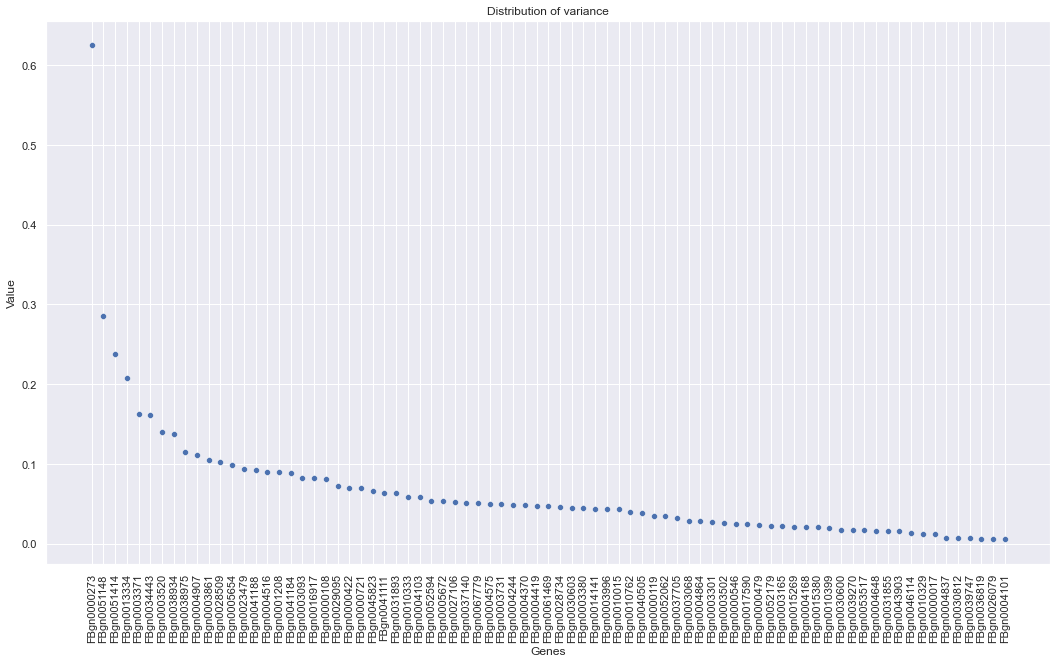

In [42]:
plot_gene_stats('variance', stats_cognition_males)

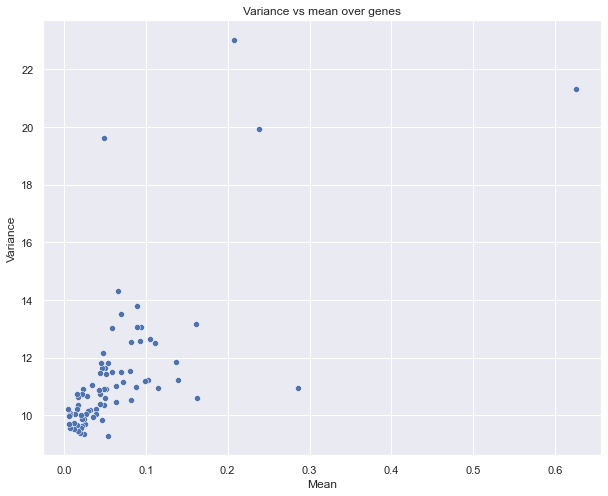

In [43]:
plot_var_vs_mean(stats_cognition_males)

In [44]:
var_genes_males['cognition'] = list(stats_cognition_males.iloc[:10,0].values)
var_genes_males

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0034443',
  'FBgn0003520',
  'FBgn0038934',
  'FBgn0038975',
  'FBgn0004907']}

# Learning only

In [45]:
# Genes related to learning only
LEARNING_GENE_NAMES = 'FlyBase_IDs_learning.txt'

learning_gene_names = pd.read_csv(PATH + LEARNING_GENE_NAMES)
learning_gene_names.head()

Genes
0  FBgn0000248
1  FBgn0000273
2  FBgn0000479
3  FBgn0000535
4  FBgn0000536

In [46]:
learning_gene_names = learning_gene_names['Genes'].to_list()
learning_gene_names.append('line')
#print(learning_gene_names)

## Females and males

In [47]:
learning_genes = transcription_data_.columns.intersection(learning_gene_names)
learning_data = transcription_data_[learning_genes]
learning_data.head()

line     line  FBgn0000273  FBgn0000479  FBgn0000721  FBgn0003301  \
0     RAL_208     21.05188     10.82154     14.13703    10.049570   
1     RAL_301     24.23164     10.88035     14.26520     9.933246   
2     RAL_303     22.34808     10.75769     14.10461    10.209610   
3     RAL_304     22.10240     11.20712     14.28684    10.253930   
4     RAL_306     21.67665     11.02811     14.24505    10.177070   

line  FBgn0003371  FBgn0003502  FBgn0003731  FBgn0003861  FBgn0004103  ...  \
0        10.43038     10.27107    11.033980     12.34196     13.46876  ...   
1        10.75278     10.67270     9.685478     12.25263     13.63796  ...   
2        10.52204     10.68992    10.961580     11.46386     13.51315  ...   
3        10.74292     10.71194    10.871580     12.40508     13.56547  ...   
4        10.69238     10.87821    11.192660     11.83930     13.62800  ...   

line  FBgn0028734  FBgn0030812  FBgn0036819  FBgn0037140  FBgn0038975  \
0        9.930470     10.93657     10.26958     10.30697     9.519737   
1       10.180130     11.19023     10.09666     10.29586    10.581870   
2        9.995707     11.15537     10.38409     10.48563    10.458030   
3        9.985194     11.05813     10.48734     10.88070    10.566510   
4        9.884367     11.01298     10.39643     10.63997    10.545670   

line  FBgn0039270  FBgn0039747  FBgn0040505  FBgn0041188  FBgn0052179  
0        11.26506     9.846645     9.788788     13.02277     11.11092  
1        11.61106     9.760580     9.776106     13.13945     11.20397  
2        11.44645     9.838128     9.711320     12.86969     11.01582  
3        11.41081     9.715455     9.818805     13.14515     11.17933  
4        11.38190     9.731589     9.806876     12.85199     11.10131  

[5 rows x 32 columns]

In [48]:
genes_learning = learning_data.columns.values.tolist()
genes_learning.pop(0)
#genes

'line'

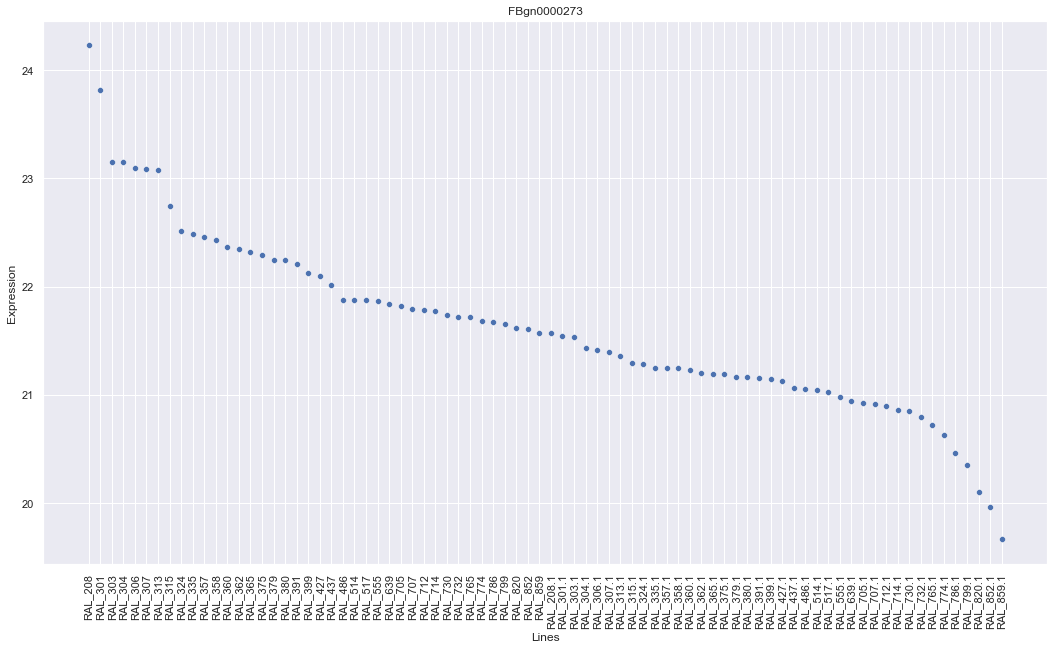

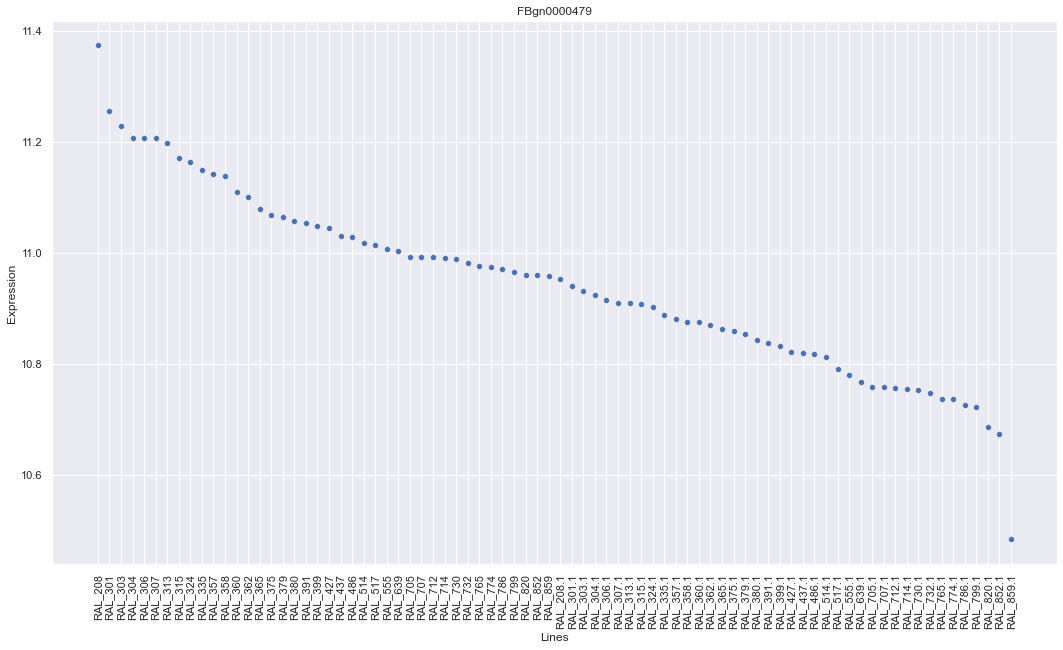

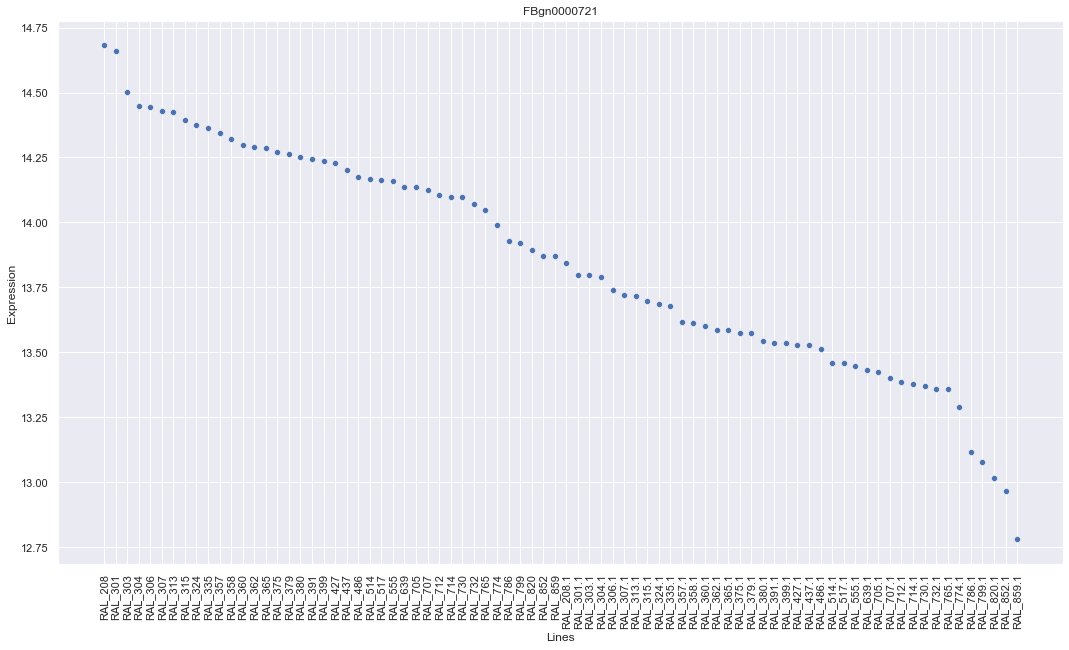

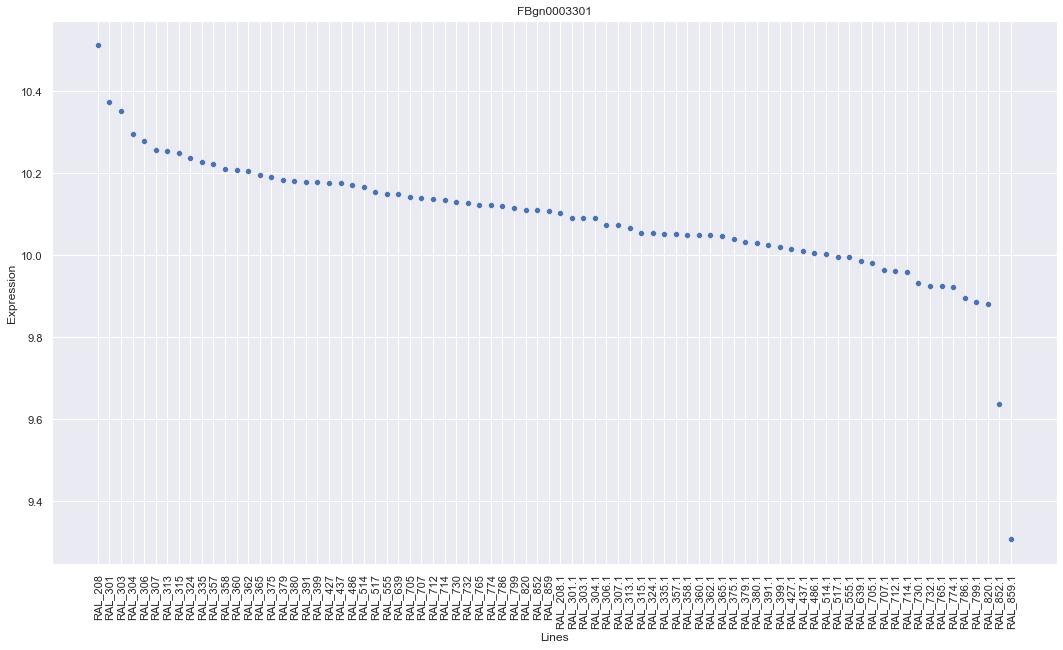

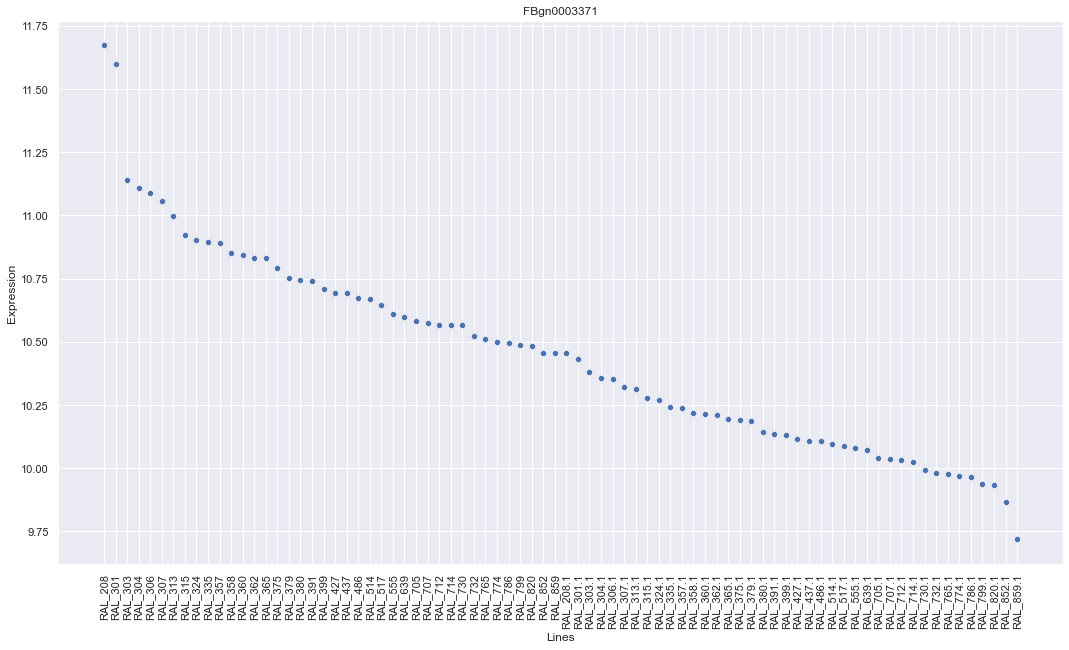

In [49]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_learning[i], learning_data)

In [50]:
# Statistics
stats_learning = pd.DataFrame()
stats_learning['gene'] = genes_learning # genes of interest

stats_learning['variance'] = stats_learning.apply(lambda x: learning_data[x['gene']].var(), axis=1)
stats_learning['std'] = stats_learning.apply(lambda x: learning_data[x['gene']].std(), axis=1)
stats_learning['mean'] = stats_learning.apply(lambda x: learning_data[x['gene']].mean(), axis=1)
stats_learning['min'] = stats_learning.apply(lambda x: learning_data[x['gene']].min(), axis=1)
stats_learning['max'] = stats_learning.apply(lambda x: learning_data[x['gene']].max(), axis=1)
stats_learning['range'] = stats_learning.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_learning.sort_values(by=['variance'], ascending=False, inplace=True)

stats_learning.head()

gene  variance       std       mean        min       max     range
10  FBgn0004419  1.931019  1.389611  13.508313  11.685040  15.35207  3.667030
0   FBgn0000273  0.670887  0.819077  21.630299  19.662503  24.23164  4.569137
22  FBgn0030812  0.368973  0.607431  10.562932   9.840645  11.93985  2.099205
5   FBgn0003502  0.337935  0.581322  10.219227   9.265597  11.40001  2.134413
18  FBgn0013334  0.241056  0.490974  22.828534  21.088460  23.94117  2.852710

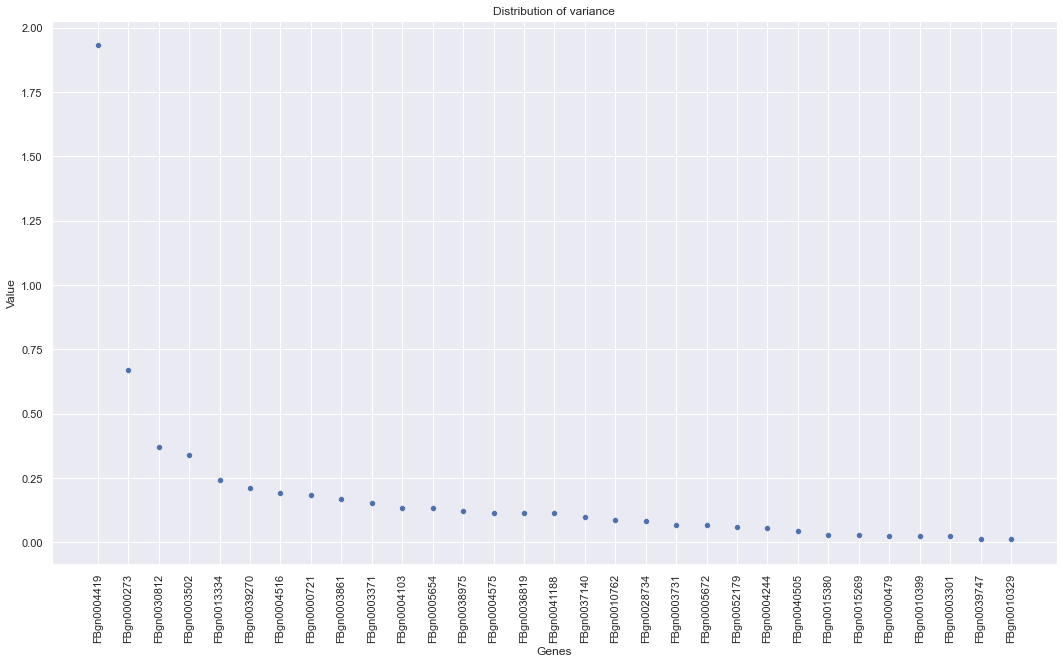

In [51]:
plot_gene_stats('variance', stats_learning)

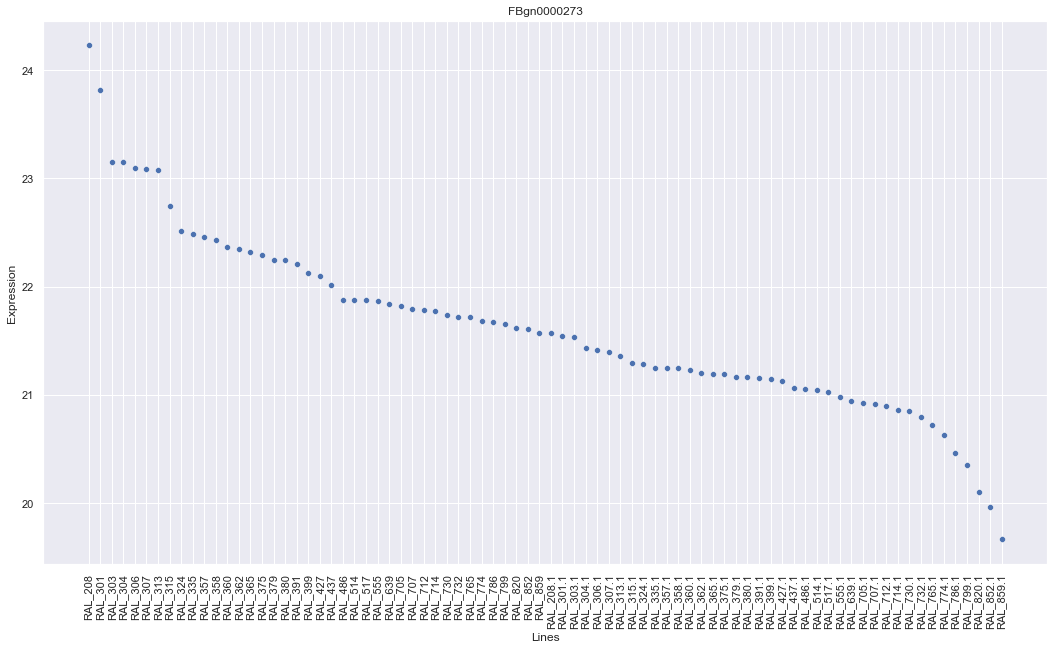

In [52]:
plot_gene_expression('FBgn0000273', learning_data)

In [53]:
var_genes['learning'] = list(stats_learning.iloc[:5,0].values)
var_genes

{'cognition': ['FBgn0004419',
  'FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864',
  'FBgn0004370',
  'FBgn0043903',
  'FBgn0030812',
  'FBgn0003502'],
 'learning': ['FBgn0004419',
  'FBgn0000273',
  'FBgn0030812',
  'FBgn0003502',
  'FBgn0013334']}

### Females

In [54]:
learning_genes_females = females_transcription.columns.intersection(learning_gene_names)
learning_data_females = females_transcription[learning_genes_females]
learning_data_females.head()

line     line  FBgn0000273  FBgn0000479  FBgn0000721  FBgn0003301  \
0     RAL_208     21.05188     10.82154     14.13703    10.049570   
1     RAL_301     24.23164     10.88035     14.26520     9.933246   
2     RAL_303     22.34808     10.75769     14.10461    10.209610   
3     RAL_304     22.10240     11.20712     14.28684    10.253930   
4     RAL_306     21.67665     11.02811     14.24505    10.177070   

line  FBgn0003371  FBgn0003502  FBgn0003731  FBgn0003861  FBgn0004103  ...  \
0        10.43038     10.27107    11.033980     12.34196     13.46876  ...   
1        10.75278     10.67270     9.685478     12.25263     13.63796  ...   
2        10.52204     10.68992    10.961580     11.46386     13.51315  ...   
3        10.74292     10.71194    10.871580     12.40508     13.56547  ...   
4        10.69238     10.87821    11.192660     11.83930     13.62800  ...   

line  FBgn0028734  FBgn0030812  FBgn0036819  FBgn0037140  FBgn0038975  \
0        9.930470     10.93657     10.26958     10.30697     9.519737   
1       10.180130     11.19023     10.09666     10.29586    10.581870   
2        9.995707     11.15537     10.38409     10.48563    10.458030   
3        9.985194     11.05813     10.48734     10.88070    10.566510   
4        9.884367     11.01298     10.39643     10.63997    10.545670   

line  FBgn0039270  FBgn0039747  FBgn0040505  FBgn0041188  FBgn0052179  
0        11.26506     9.846645     9.788788     13.02277     11.11092  
1        11.61106     9.760580     9.776106     13.13945     11.20397  
2        11.44645     9.838128     9.711320     12.86969     11.01582  
3        11.41081     9.715455     9.818805     13.14515     11.17933  
4        11.38190     9.731589     9.806876     12.85199     11.10131  

[5 rows x 32 columns]

In [55]:
stats_learning_females = pd.DataFrame()
stats_learning_females['gene'] = genes_learning # genes of interest

stats_learning_females['variance'] = stats_learning_females.apply(lambda x: learning_data_females[x['gene']].var(), axis=1)
stats_learning_females['std'] = stats_learning_females.apply(lambda x: learning_data_females[x['gene']].std(), axis=1)
stats_learning_females['mean'] = stats_learning_females.apply(lambda x: learning_data_females[x['gene']].mean(), axis=1)
stats_learning_females['min'] = stats_learning_females.apply(lambda x: learning_data_females[x['gene']].min(), axis=1)
stats_learning_females['max'] = stats_learning_females.apply(lambda x: learning_data_females[x['gene']].max(), axis=1)
stats_learning_females['range'] = stats_learning_females.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_learning_females.sort_values(by=['variance'], ascending=False, inplace=True)

stats_learning_females.head()

gene  variance       std       mean       min       max    range
0   FBgn0000273  0.551303  0.742498  21.928713  20.85758  24.23164  3.37406
18  FBgn0013334  0.210182  0.458456  22.643496  21.08846  23.72894  2.64048
5   FBgn0003502  0.120603  0.347279  10.731195  10.11615  11.40001  1.28386
10  FBgn0004419  0.119120  0.345137  14.859482  13.84011  15.35207  1.51196
22  FBgn0030812  0.112188  0.334944  11.116158  10.52955  11.93985  1.41030

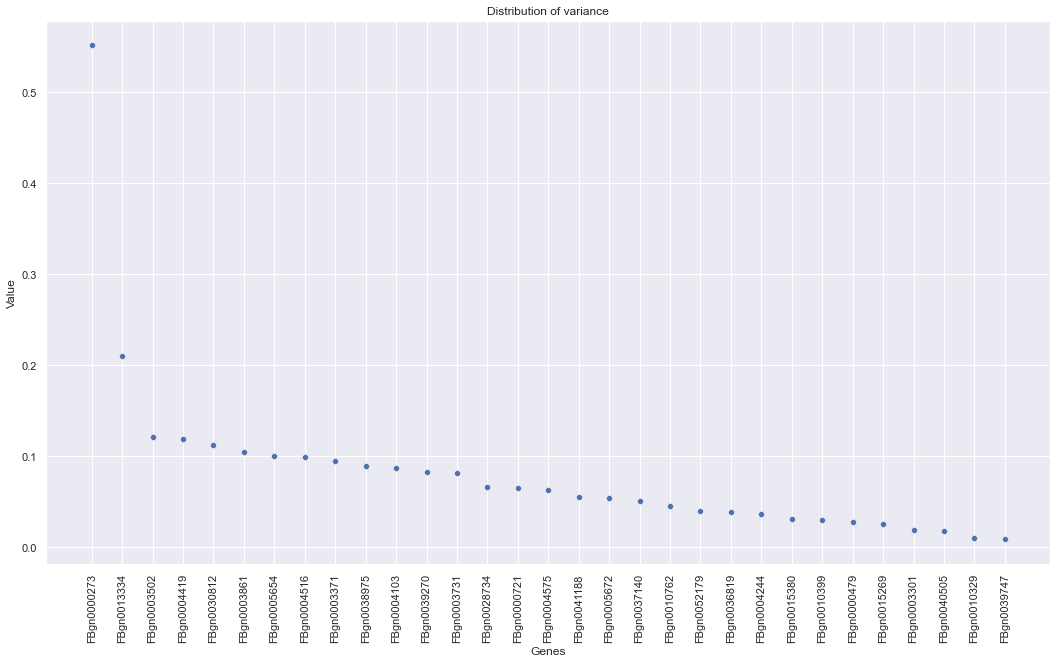

In [56]:
plot_gene_stats('variance', stats_learning_females)

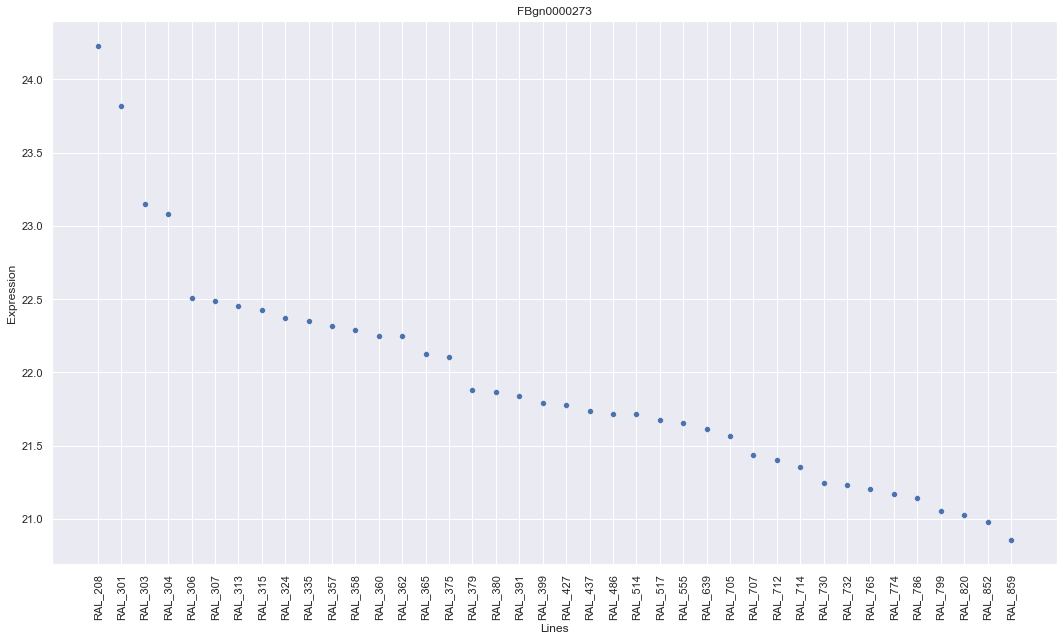

In [57]:
plot_gene_expression('FBgn0000273', learning_data_females)

In [58]:
var_genes_females['learning'] = list(stats_learning_females.iloc[:5,0].values)
var_genes_females

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0013334',
  'FBgn0004370',
  'FBgn0051414',
  'FBgn0037705',
  'FBgn0003165',
  'FBgn0004907',
  'FBgn0041111'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003502',
  'FBgn0004419',
  'FBgn0030812']}

### Males

In [59]:
learning_genes_males = males_transcription.columns.intersection(learning_gene_names)
learning_data_males = males_transcription[learning_genes_males]
learning_data_males.head()

line     line  FBgn0000273  FBgn0000479  FBgn0000721  FBgn0003301  \
40    RAL_208     20.79381     10.68688     13.67858      9.99581   
41    RAL_301     23.08654     10.75597     13.07805     10.00235   
42    RAL_303     22.20897     10.75876     13.35700     10.15368   
43    RAL_304     20.94015     11.05709     13.57316     10.10342   
44    RAL_306     21.15718     11.10029     13.71727     10.17645   

line  FBgn0003371  FBgn0003502  FBgn0003731  FBgn0003861  FBgn0004103  ...  \
40       10.56715     9.548590    10.783720     12.73788     13.12119  ...   
41       10.70844     9.842050     9.872864     12.56160     12.78301  ...   
42       10.84502     9.531556    11.007520     11.81402     12.97680  ...   
43       11.05783     9.733639    11.042480     12.82573     13.02853  ...   
44       11.10842     9.783841    11.144570     12.51532     13.10846  ...   

line  FBgn0028734  FBgn0030812  FBgn0036819  FBgn0037140  FBgn0038975  \
40       9.479612    10.049280     9.670155     10.65101     9.387819   
41      10.128560    10.124810     9.645158     10.70882    10.862480   
42       9.586968     9.971019     9.849193     10.93782    10.751920   
43       9.508711    10.084670     9.631611     11.22537    10.698470   
44       9.549176    10.012230     9.748210     11.14461    10.862610   

line  FBgn0039270  FBgn0039747  FBgn0040505  FBgn0041188  FBgn0052179  
40       10.76052     9.395043     9.873381     12.69447     10.90247  
41       10.61319     9.636486     9.961639     11.85053     10.59791  
42       10.60661     9.553732     9.780469     12.54984     10.60842  
43       10.65819     9.551009    10.012260     12.70616     10.80292  
44       10.54327     9.718328    10.235260     12.74356     10.64561  

[5 rows x 32 columns]

In [60]:
stats_learning_males = pd.DataFrame()
stats_learning_males['gene'] = genes_learning # genes of interest

stats_learning_males['variance'] = stats_learning_males.apply(lambda x: learning_data_males[x['gene']].var(), axis=1)
stats_learning_males['std'] = stats_learning_males.apply(lambda x: learning_data_males[x['gene']].std(), axis=1)
stats_learning_males['mean'] = stats_learning_males.apply(lambda x: learning_data_males[x['gene']].mean(), axis=1)
stats_learning_males['min'] = stats_learning_males.apply(lambda x: learning_data_males[x['gene']].min(), axis=1)
stats_learning_males['max'] = stats_learning_males.apply(lambda x: learning_data_males[x['gene']].max(), axis=1)
stats_learning_males['range'] = stats_learning_males.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_learning_males.sort_values(by=['variance'], ascending=False, inplace=True)

stats_learning_males.head()

gene  variance       std       mean        min       max     range
0   FBgn0000273  0.625004  0.790572  21.331885  19.662503  23.15239  3.489887
18  FBgn0013334  0.207876  0.455934  23.013573  21.605400  23.94117  2.335770
4   FBgn0003371  0.162382  0.402966  10.610989   9.931761  11.67318  1.741419
25  FBgn0038975  0.114549  0.338451  10.962345   9.387819  11.56789  2.180071
7   FBgn0003861  0.105155  0.324276  12.661415  11.814020  13.35184  1.537820

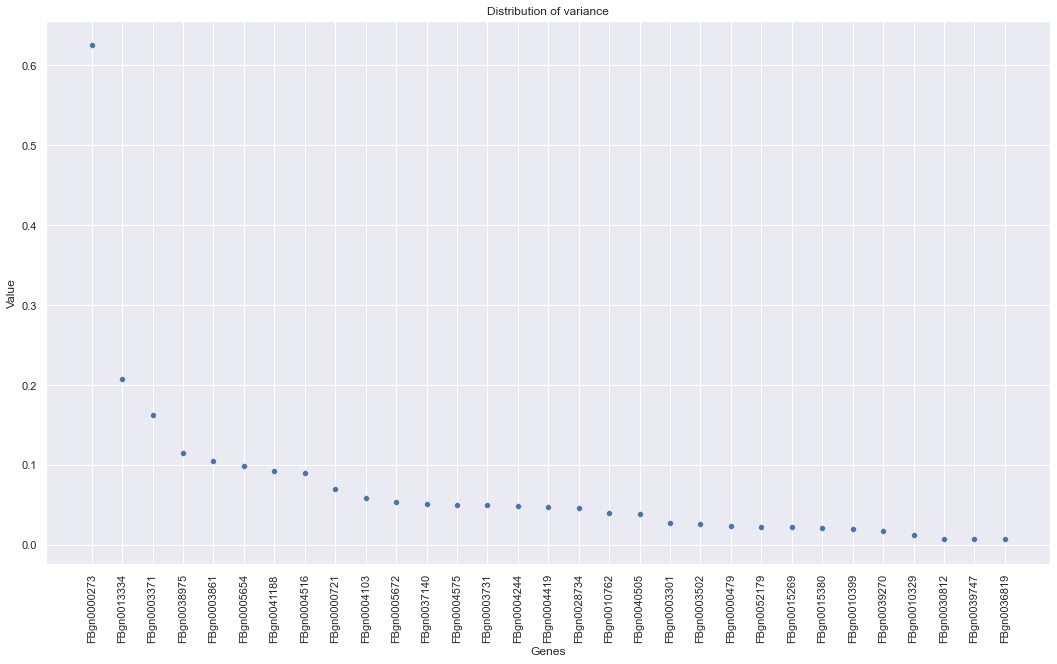

In [61]:
plot_gene_stats('variance', stats_learning_males)

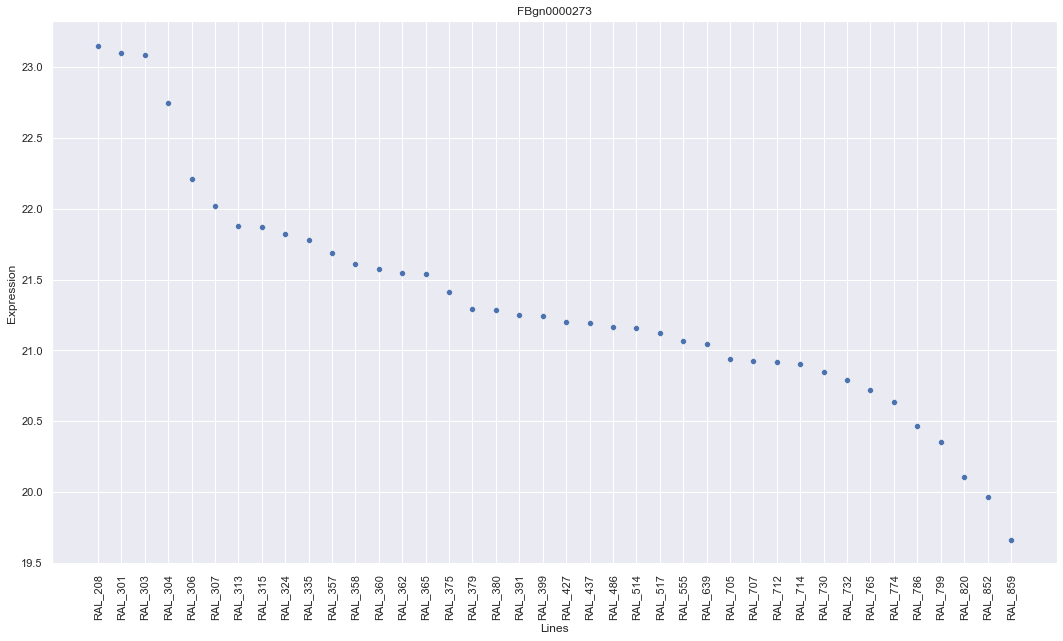

In [62]:
plot_gene_expression('FBgn0000273', learning_data_males)

In [63]:
var_genes_males['learning'] = list(stats_learning_males.iloc[:5,0].values)
var_genes_males

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0034443',
  'FBgn0003520',
  'FBgn0038934',
  'FBgn0038975',
  'FBgn0004907'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0038975',
  'FBgn0003861']}

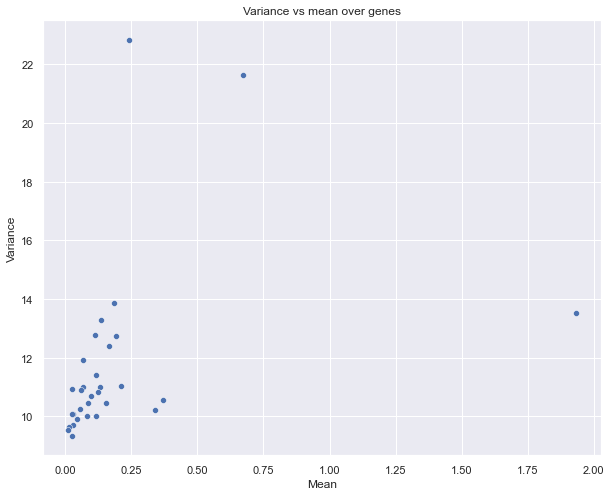

In [64]:
plot_var_vs_mean(stats_learning)

# Memory only

In [65]:
# Genes related to memory only
MEMORY_GENE_NAMES = 'FlyBase_IDs_memory.txt'

memory_gene_names = pd.read_csv(PATH + MEMORY_GENE_NAMES)
memory_gene_names.head()

Genes
0  FBgn0000108
1  FBgn0000117
2  FBgn0000119
3  FBgn0000229
4  FBgn0000273

In [66]:
memory_gene_names = memory_gene_names['Genes'].to_list()
memory_gene_names.append('line')
#print(memory_gene_names)

## Females and males

In [67]:
memory_genes = transcription_data_.columns.intersection(memory_gene_names)
memory_data = transcription_data_[memory_genes]
memory_data.head()

line     line  FBgn0000108  FBgn0000119  FBgn0000273  FBgn0000422  \
0     RAL_208     11.12222     10.55853     21.05188     11.07408   
1     RAL_301     11.19351     10.62853     24.23164     11.05320   
2     RAL_303     11.07512     10.90554     22.34808     11.25881   
3     RAL_304     11.54614     10.78695     22.10240     11.20053   
4     RAL_306     11.59569     10.69100     21.67665     11.38234   

line  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  FBgn0003068  ...  \
0        10.82154     9.527054     14.13703     13.36813     10.30246  ...   
1        10.88035     9.658879     14.26520     13.61266     10.24701  ...   
2        10.75769     9.599550     14.10461     13.51797     10.33446  ...   
3        11.20712     9.716882     14.28684     14.03130     10.06463  ...   
4        11.02811     9.470495     14.24505     14.03102     10.13764  ...   

line  FBgn0043903  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  \
0        11.74048     14.63447     10.18300     10.69253    19.484154   
1        11.77963     14.72518     10.16004     11.84545    21.019710   
2        11.80816     14.62178     10.23010     10.08896    19.618740   
3        11.60654     14.68856     10.38333     10.23377    19.706640   
4        11.70899     14.74778     10.25264     10.47261    19.421406   

line  FBgn0052062  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
0        11.13320     9.228790     9.382670     11.77405     11.31423  
1        11.01258     9.232729     9.204078     11.62965     11.39481  
2        11.05417     9.712390     9.333937     11.80197     11.35328  
3        11.12872     9.279444     9.237427     11.38304     11.34137  
4        11.15641     9.220441     9.313120     11.61773     11.46165  

[5 rows x 58 columns]

In [68]:
genes_memory = memory_data.columns.values.tolist()
genes_memory.pop(0)
#genes

'line'

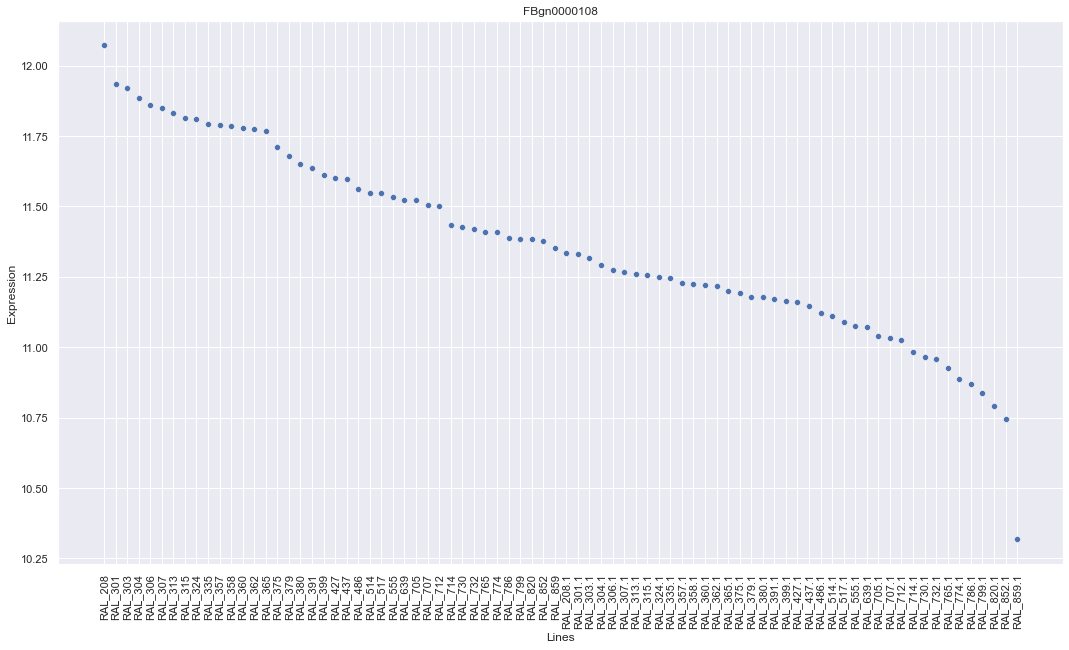

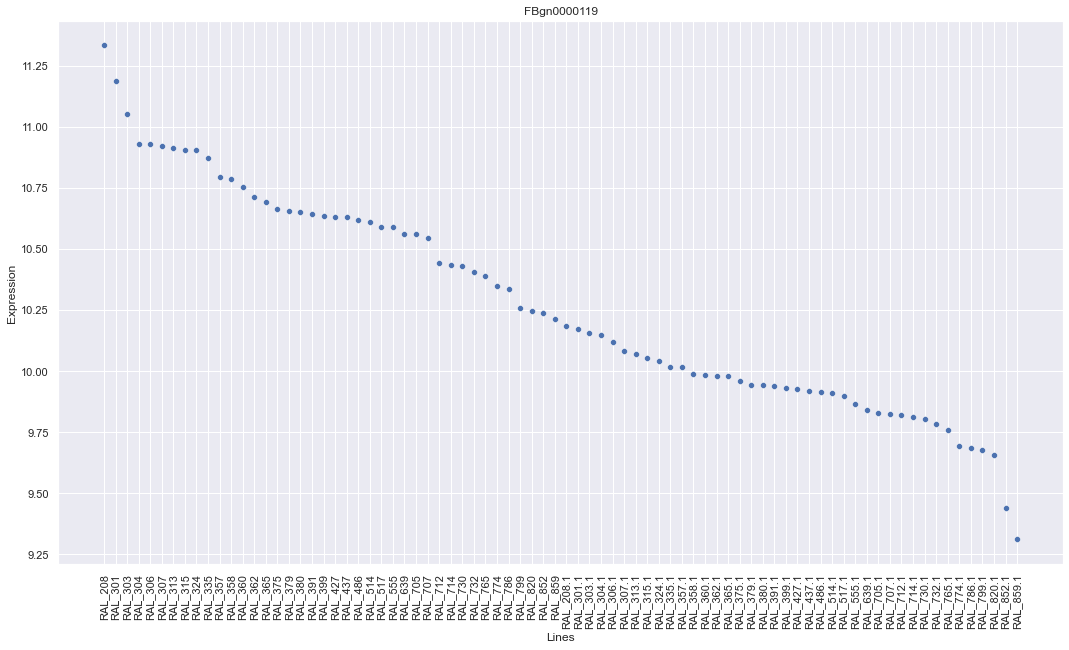

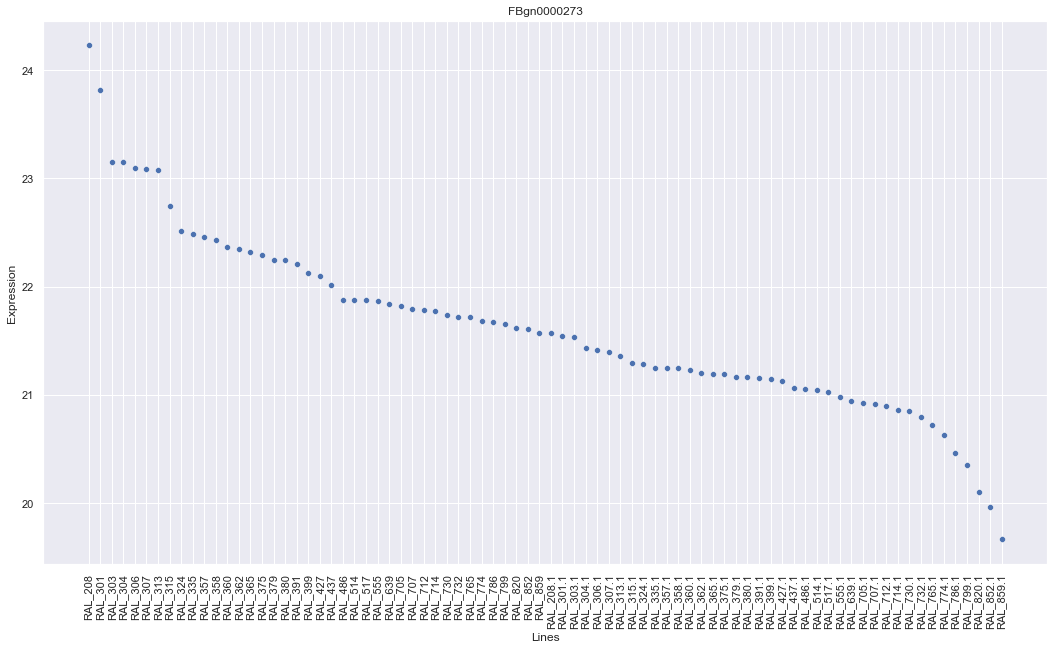

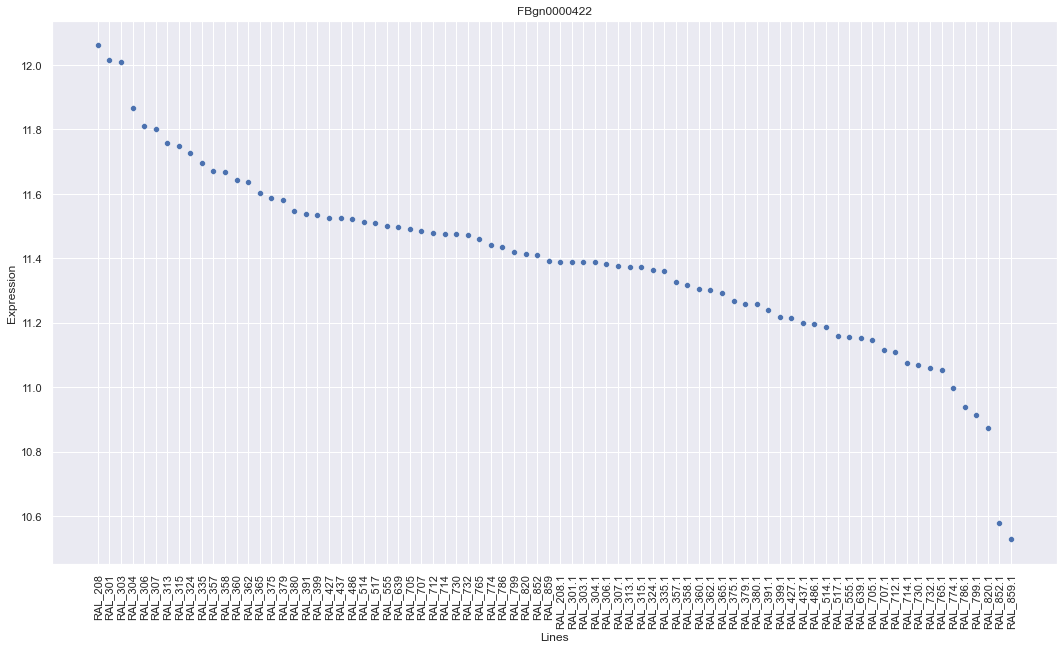

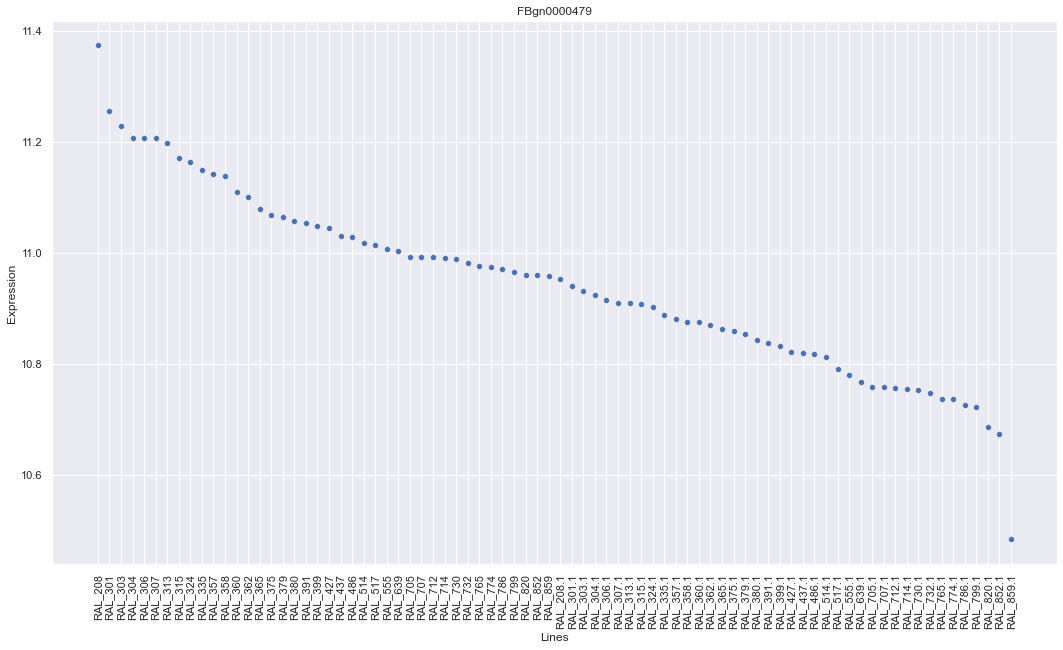

In [69]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_memory[i], memory_data)

In [70]:
# Statistics
stats_memory = pd.DataFrame()
stats_memory['gene'] = genes_memory # genes of interest

stats_memory['variance'] = stats_memory.apply(lambda x: memory_data[x['gene']].var(), axis=1)
stats_memory['std'] = stats_memory.apply(lambda x: memory_data[x['gene']].std(), axis=1)
stats_memory['mean'] = stats_memory.apply(lambda x: memory_data[x['gene']].mean(), axis=1)
stats_memory['min'] = stats_memory.apply(lambda x: memory_data[x['gene']].min(), axis=1)
stats_memory['max'] = stats_memory.apply(lambda x: memory_data[x['gene']].max(), axis=1)
stats_memory['range'] = stats_memory.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_memory.sort_values(by=['variance'], ascending=False, inplace=True)

stats_memory.head()

gene  variance       std       mean        min       max     range
44  FBgn0038934  1.462188  1.209210  10.689881   9.323175  13.17652  3.853345
10  FBgn0003165  1.323314  1.150354  10.971205   9.557119  13.05292  3.495801
2   FBgn0000273  0.670887  0.819077  21.630299  19.662503  24.23164  4.569137
14  FBgn0004101  0.477877  0.691287  10.857266  10.091870  12.34653  2.254660
20  FBgn0004864  0.412775  0.642475  11.254675  10.343400  12.57378  2.230380

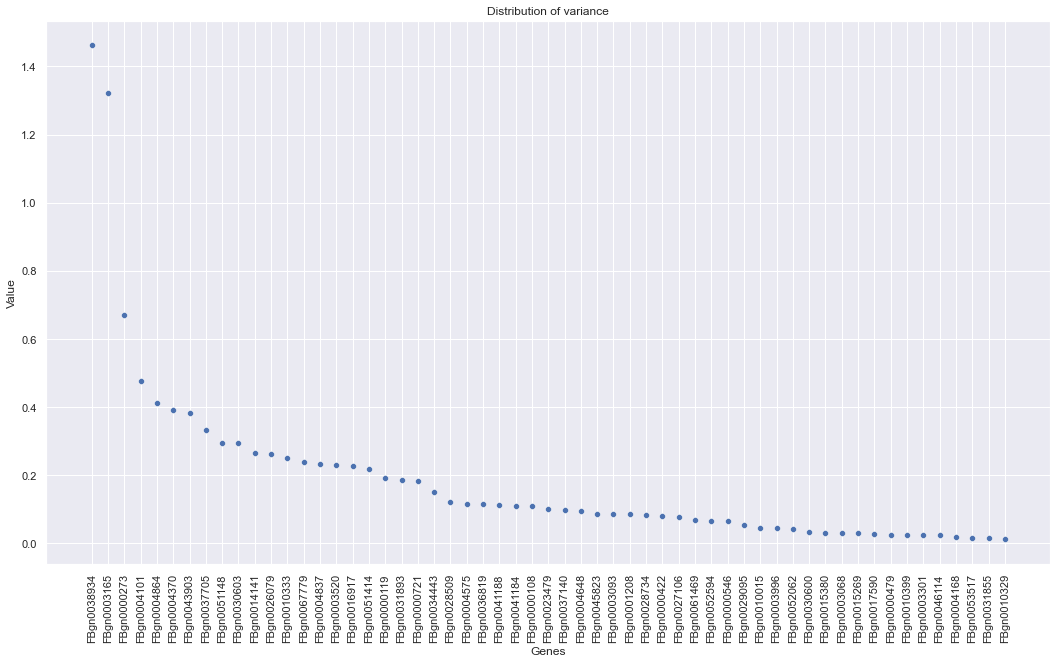

In [71]:
plot_gene_stats('variance', stats_memory)

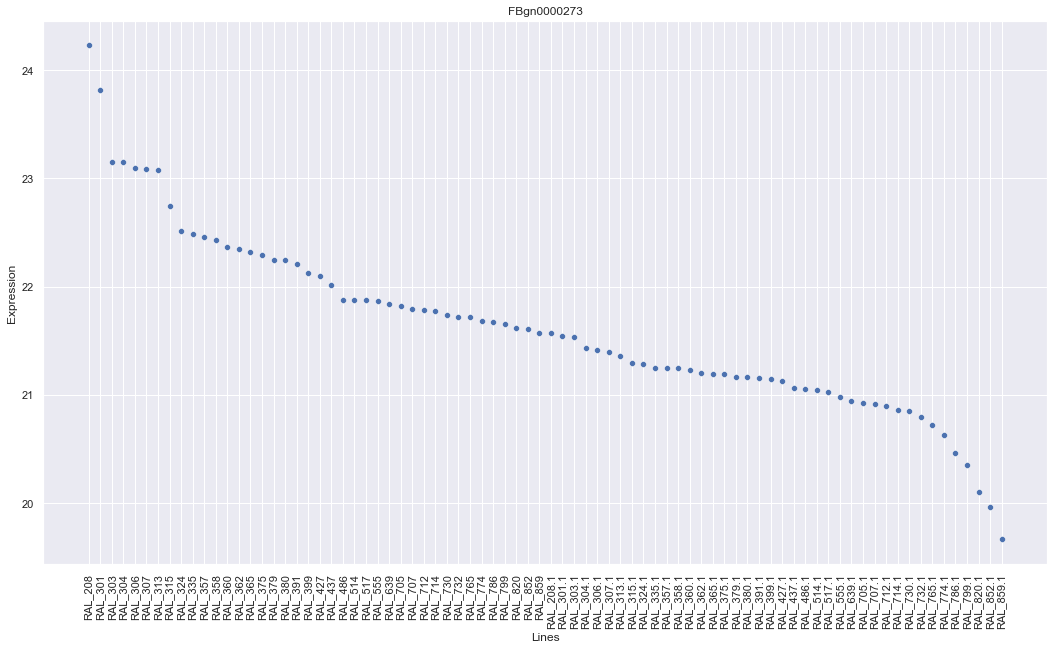

In [72]:
plot_gene_expression('FBgn0000273', memory_data)

In [73]:
var_genes['memory'] = list(stats_memory.iloc[:5,0].values)
var_genes

{'cognition': ['FBgn0004419',
  'FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864',
  'FBgn0004370',
  'FBgn0043903',
  'FBgn0030812',
  'FBgn0003502'],
 'learning': ['FBgn0004419',
  'FBgn0000273',
  'FBgn0030812',
  'FBgn0003502',
  'FBgn0013334'],
 'memory': ['FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864']}

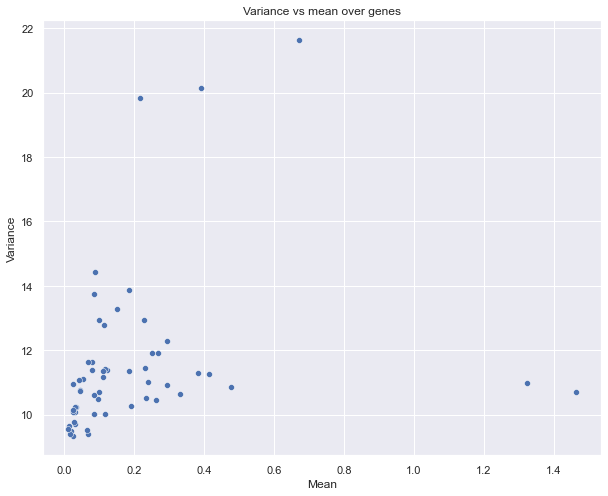

In [74]:
plot_var_vs_mean(stats_memory)

### Females

In [75]:
memory_genes_females = females_transcription.columns.intersection(memory_gene_names)
memory_data_females = females_transcription[memory_genes_females]
memory_data_females.head()

line     line  FBgn0000108  FBgn0000119  FBgn0000273  FBgn0000422  \
0     RAL_208     11.12222     10.55853     21.05188     11.07408   
1     RAL_301     11.19351     10.62853     24.23164     11.05320   
2     RAL_303     11.07512     10.90554     22.34808     11.25881   
3     RAL_304     11.54614     10.78695     22.10240     11.20053   
4     RAL_306     11.59569     10.69100     21.67665     11.38234   

line  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  FBgn0003068  ...  \
0        10.82154     9.527054     14.13703     13.36813     10.30246  ...   
1        10.88035     9.658879     14.26520     13.61266     10.24701  ...   
2        10.75769     9.599550     14.10461     13.51797     10.33446  ...   
3        11.20712     9.716882     14.28684     14.03130     10.06463  ...   
4        11.02811     9.470495     14.24505     14.03102     10.13764  ...   

line  FBgn0043903  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  \
0        11.74048     14.63447     10.18300     10.69253    19.484154   
1        11.77963     14.72518     10.16004     11.84545    21.019710   
2        11.80816     14.62178     10.23010     10.08896    19.618740   
3        11.60654     14.68856     10.38333     10.23377    19.706640   
4        11.70899     14.74778     10.25264     10.47261    19.421406   

line  FBgn0052062  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
0        11.13320     9.228790     9.382670     11.77405     11.31423  
1        11.01258     9.232729     9.204078     11.62965     11.39481  
2        11.05417     9.712390     9.333937     11.80197     11.35328  
3        11.12872     9.279444     9.237427     11.38304     11.34137  
4        11.15641     9.220441     9.313120     11.61773     11.46165  

[5 rows x 58 columns]

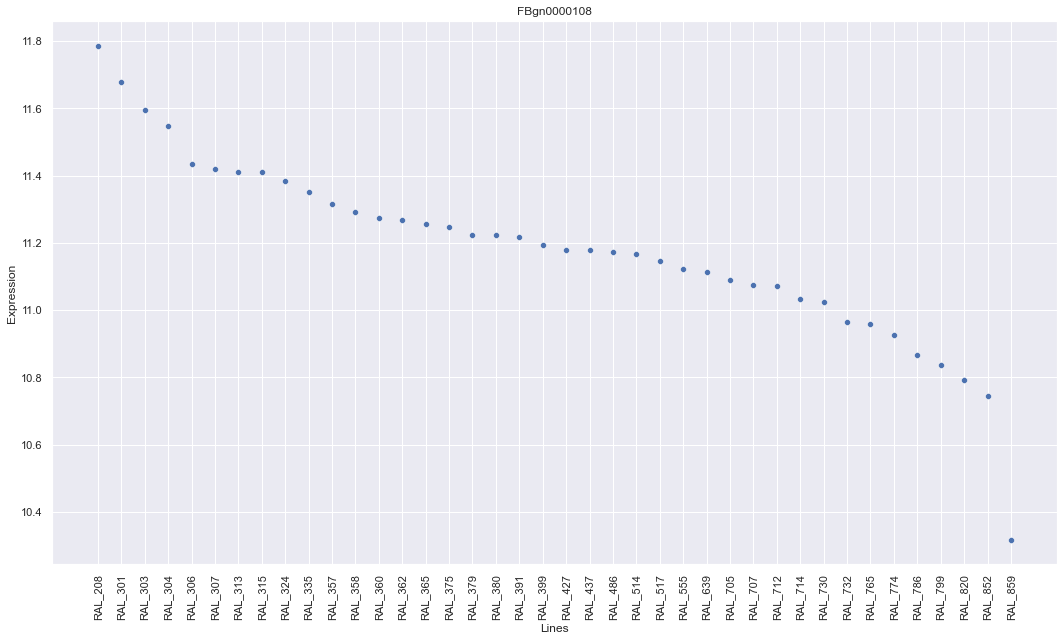

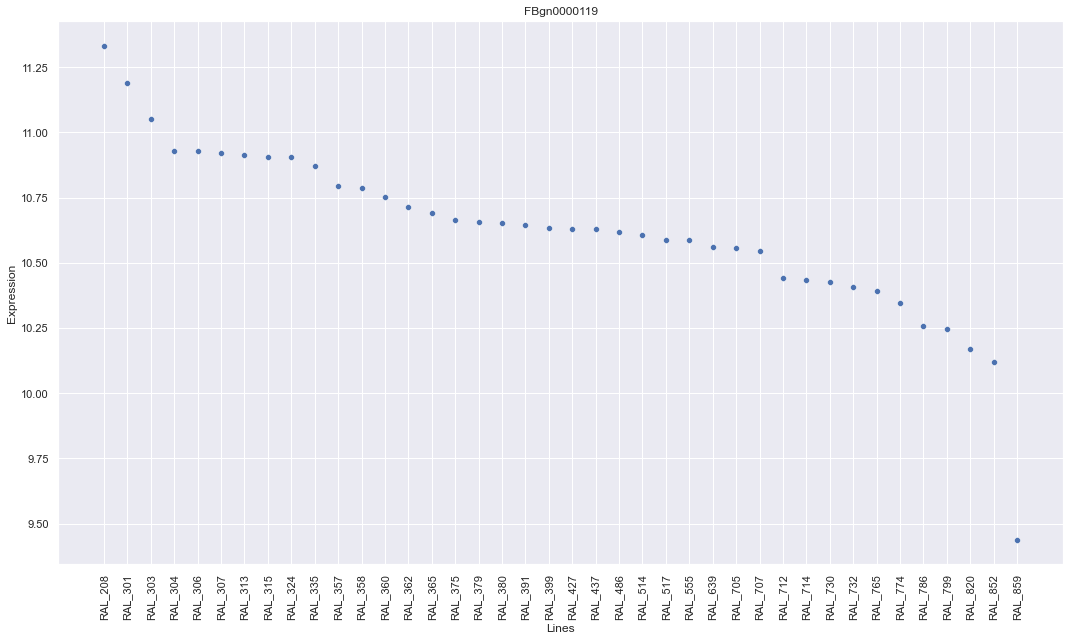

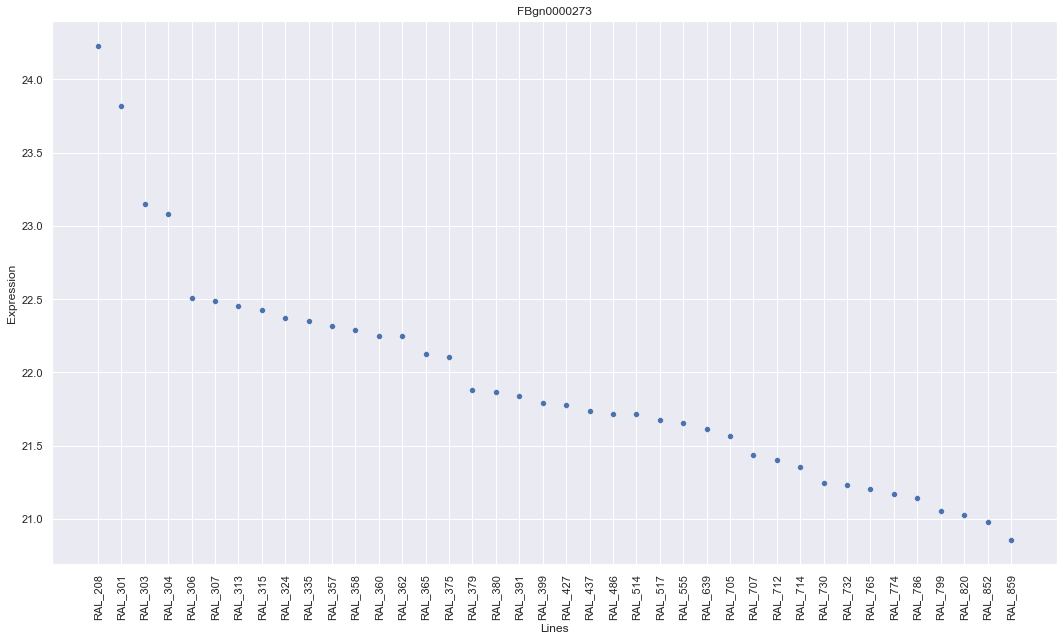

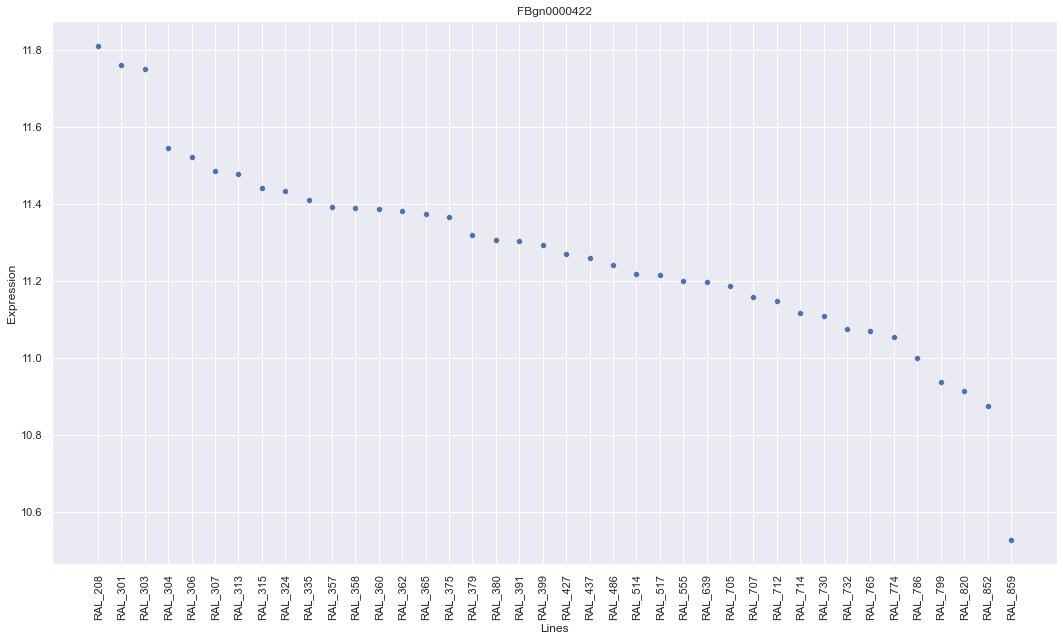

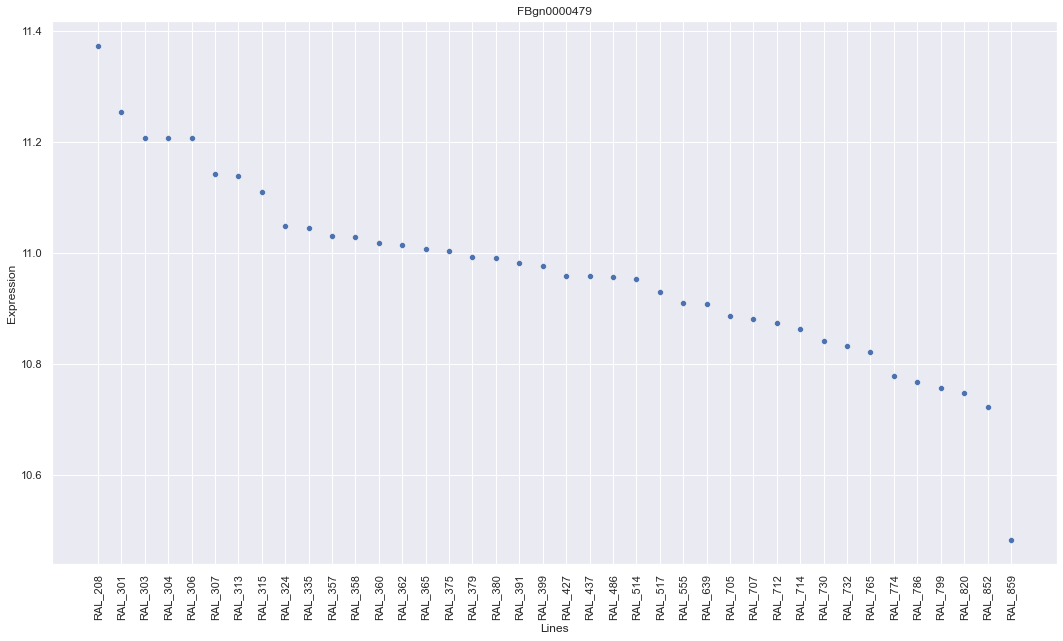

In [76]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_memory[i], memory_data_females)

In [77]:
stats_memory_females = pd.DataFrame()
stats_memory_females['gene'] = genes_memory # genes of interest

stats_memory_females['variance'] = stats_memory_females.apply(lambda x: memory_data_females[x['gene']].var(), axis=1)
stats_memory_females['std'] = stats_memory_females.apply(lambda x: memory_data_females[x['gene']].std(), axis=1)
stats_memory_females['mean'] = stats_memory_females.apply(lambda x: memory_data_females[x['gene']].mean(), axis=1)
stats_memory_females['min'] = stats_memory_females.apply(lambda x: memory_data_females[x['gene']].min(), axis=1)
stats_memory_females['max'] = stats_memory_females.apply(lambda x: memory_data_females[x['gene']].max(), axis=1)
stats_memory_females['range'] = stats_memory_females.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_memory_females.sort_values(by=['variance'], ascending=False, inplace=True)

stats_memory_females.head()

gene  variance       std       mean        min       max     range
2   FBgn0000273  0.551303  0.742498  21.928713  20.857580  24.23164  3.374060
50  FBgn0051148  0.304310  0.551643  10.848316   9.771085  11.99191  2.220825
12  FBgn0003520  0.229678  0.479248  11.651801  10.876280  12.81097  1.934690
16  FBgn0004370  0.199552  0.446713  20.648112  19.749405  21.61536  1.865955
51  FBgn0051414  0.186153  0.431455  19.749973  19.129088  21.01971  1.890622

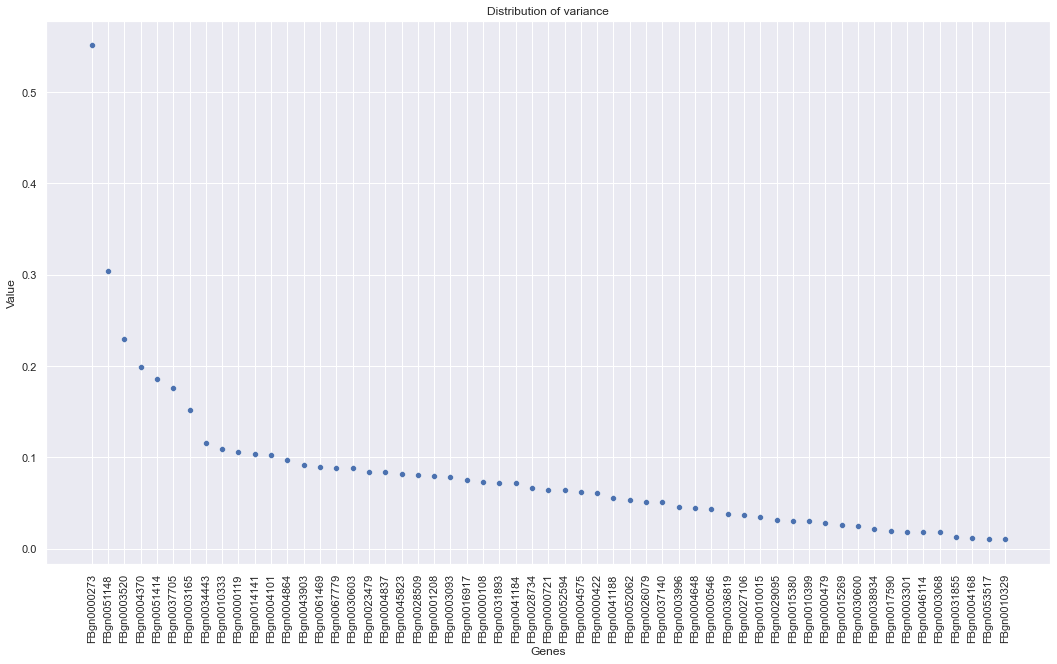

In [78]:
plot_gene_stats('variance', stats_memory_females)

In [79]:
var_genes_females['memory'] = list(stats_memory_females.iloc[:5,0].values)
var_genes_females

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0013334',
  'FBgn0004370',
  'FBgn0051414',
  'FBgn0037705',
  'FBgn0003165',
  'FBgn0004907',
  'FBgn0041111'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003502',
  'FBgn0004419',
  'FBgn0030812'],
 'memory': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0004370',
  'FBgn0051414']}

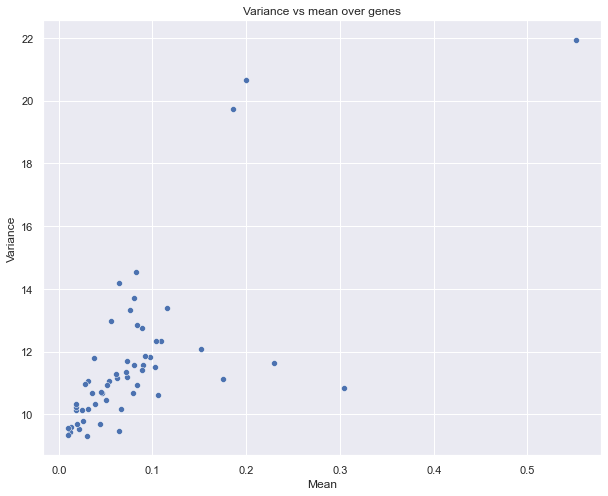

In [80]:
plot_var_vs_mean(stats_memory_females)

### Males

In [81]:
memory_genes_males = males_transcription.columns.intersection(memory_gene_names)
memory_data_males = males_transcription[memory_genes_males]
memory_data_males.head()

line     line  FBgn0000108  FBgn0000119  FBgn0000273  FBgn0000422  \
40    RAL_208     11.32973     9.939225     20.79381     11.36114   
41    RAL_301     11.03826     9.943818     23.08654     11.25951   
42    RAL_303     11.33572     9.829803     22.20897     11.41197   
43    RAL_304     11.84783    10.146930     20.94015     11.60131   
44    RAL_306     11.93511     9.781580     21.15718     11.49639   

line  FBgn0000479  FBgn0000546  FBgn0000721  FBgn0001208  FBgn0003068  ...  \
40       10.68688     9.283833     13.67858     13.44488     9.907333  ...   
41       10.75597     9.417577     13.07805     13.59428    10.231280  ...   
42       10.75876     9.419011     13.35700     13.49639     9.971749  ...   
43       11.05709     9.386425     13.57316     14.29718     9.942010  ...   
44       11.10029     9.094382     13.71727     14.06162    10.011260  ...   

line  FBgn0043903  FBgn0045823  FBgn0046114  FBgn0051148  FBgn0051414  \
40       10.79250     14.45439     10.21750     10.89426    19.973497   
41       10.67916     14.24313     10.00278     12.44683    21.197886   
42       10.57530     14.12330     10.04849     10.71158    19.702708   
43       10.64791     14.65261     10.12475     11.21948    20.330065   
44       10.58239     14.33828     10.08085     10.82261    19.666373   

line  FBgn0052062  FBgn0052594  FBgn0053517  FBgn0061469  FBgn0067779  
40       11.00726     9.027996     9.380091     11.58163     10.66929  
41       10.91640     9.280142     9.581348     11.75157     10.49130  
42       11.01503     9.695497     9.363155     11.69343     10.38450  
43       11.25046     9.161429     9.376358     11.46247     10.38933  
44       11.09384     9.106664     9.468334     11.48798     10.37957  

[5 rows x 58 columns]

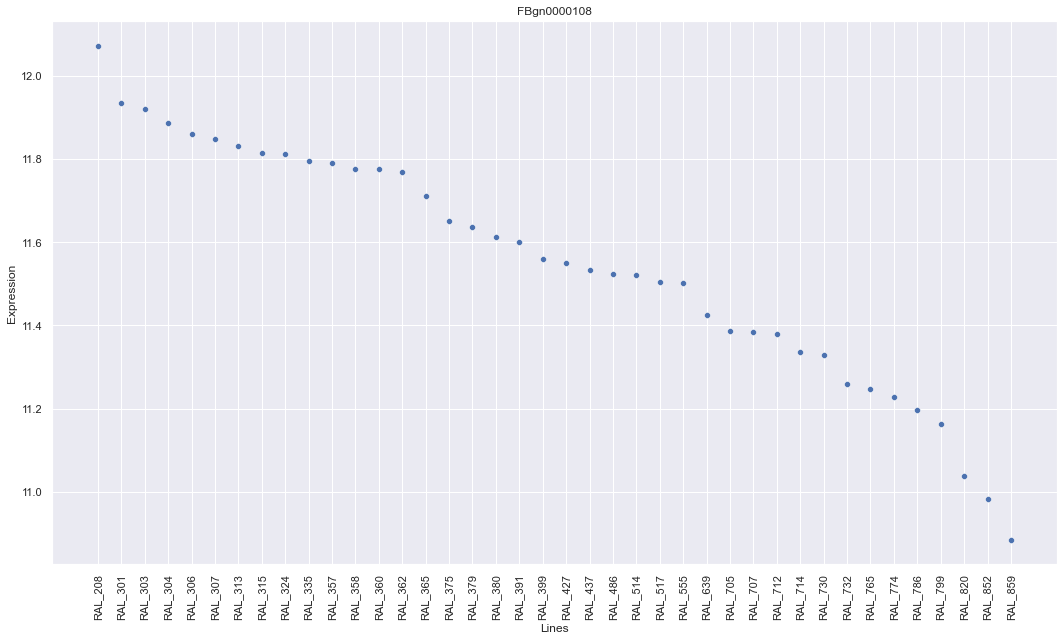

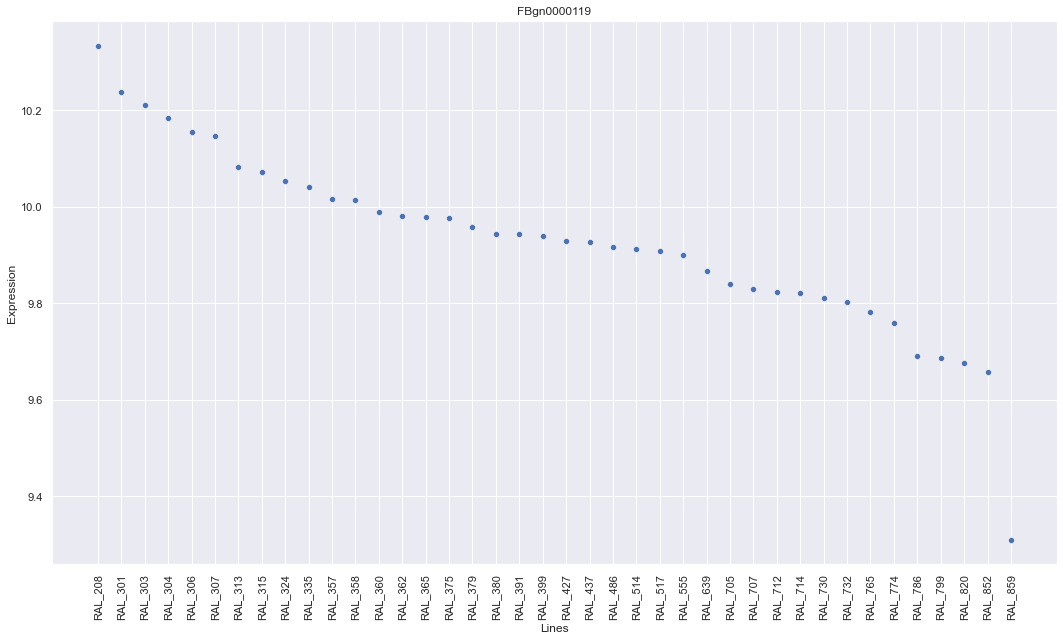

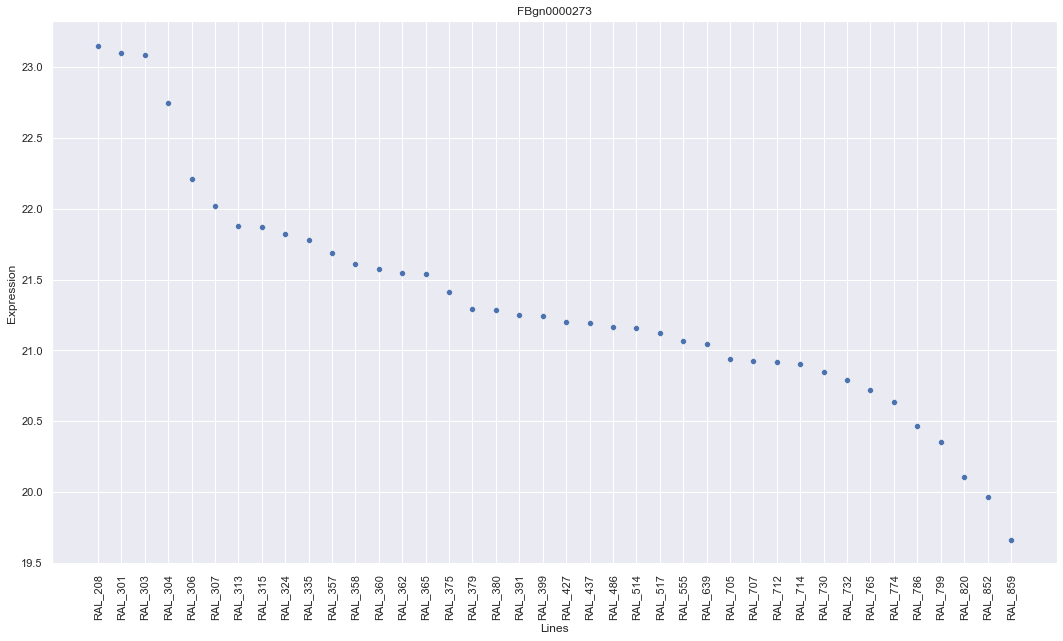

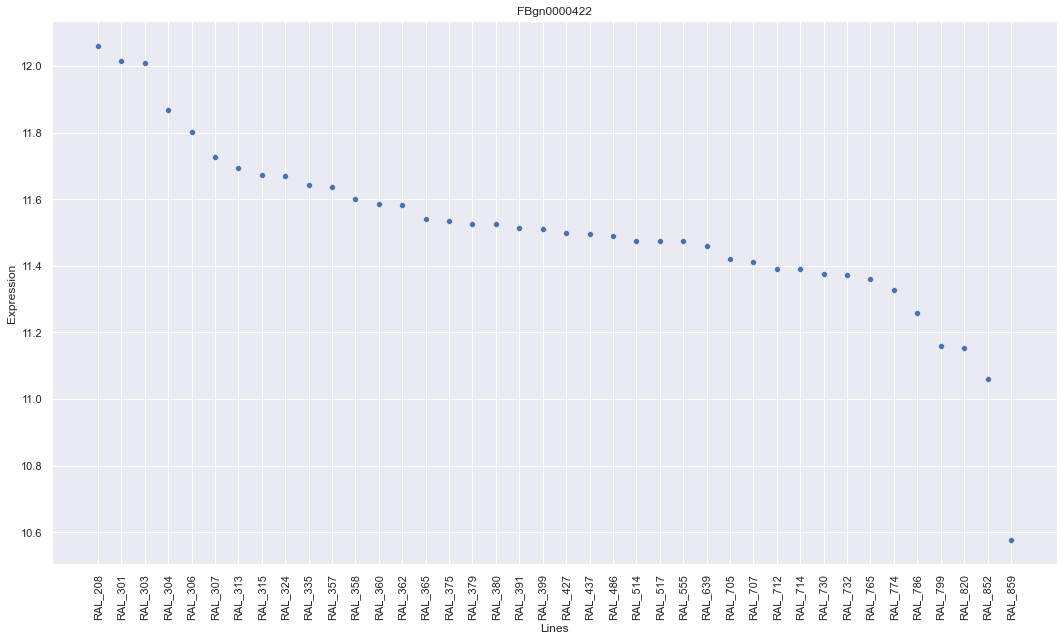

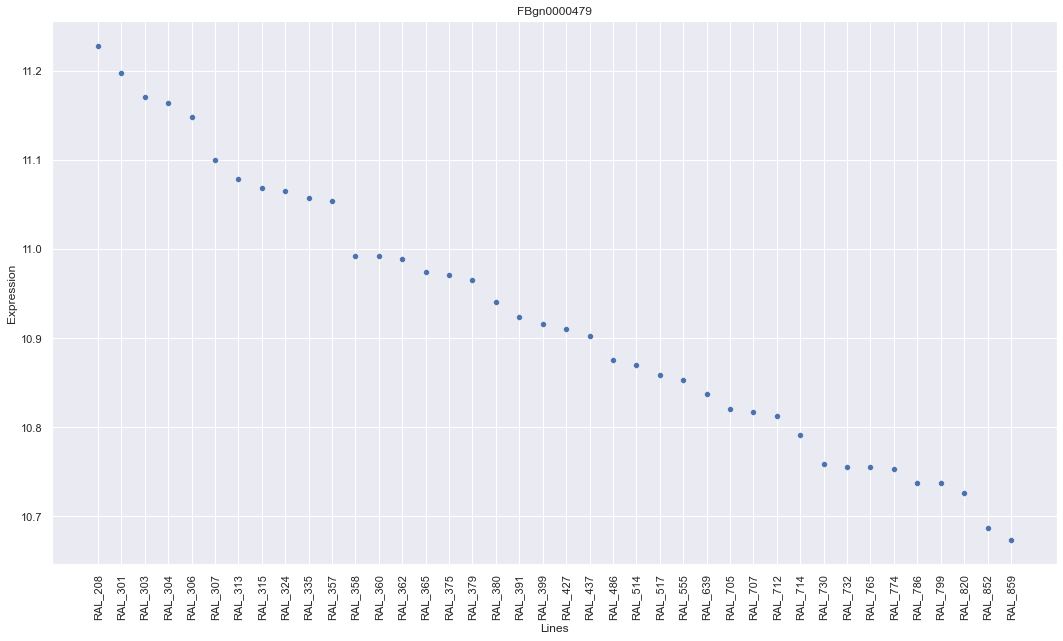

In [82]:
for i in range(NB_GENES_TO_PLOT):
    plot_gene_expression(genes_memory[i], memory_data_males)

In [83]:
stats_memory_males = pd.DataFrame()
stats_memory_males['gene'] = genes_memory # genes of interest

stats_memory_males['variance'] = stats_memory_males.apply(lambda x: memory_data_males[x['gene']].var(), axis=1)
stats_memory_males['std'] = stats_memory_males.apply(lambda x: memory_data_males[x['gene']].std(), axis=1)
stats_memory_males['mean'] = stats_memory_males.apply(lambda x: memory_data_males[x['gene']].mean(), axis=1)
stats_memory_males['min'] = stats_memory_males.apply(lambda x: memory_data_males[x['gene']].min(), axis=1)
stats_memory_males['max'] = stats_memory_males.apply(lambda x: memory_data_males[x['gene']].max(), axis=1)
stats_memory_males['range'] = stats_memory_males.apply(lambda x: np.abs(x['max']-x['min']), axis=1)

stats_memory_males.sort_values(by=['variance'], ascending=False, inplace=True)

stats_memory_males.head()

gene  variance       std       mean        min        max     range
2   FBgn0000273  0.625004  0.790572  21.331885  19.662503  23.152390  3.489887
50  FBgn0051148  0.285556  0.534375  10.960560  10.096940  12.446830  2.349890
51  FBgn0051414  0.238293  0.488153  19.924050  19.229673  21.197886  1.968213
40  FBgn0034443  0.161387  0.401730  13.160278  12.331160  14.286090  1.954930
12  FBgn0003520  0.139588  0.373614  11.218723  10.623440  11.942430  1.318990

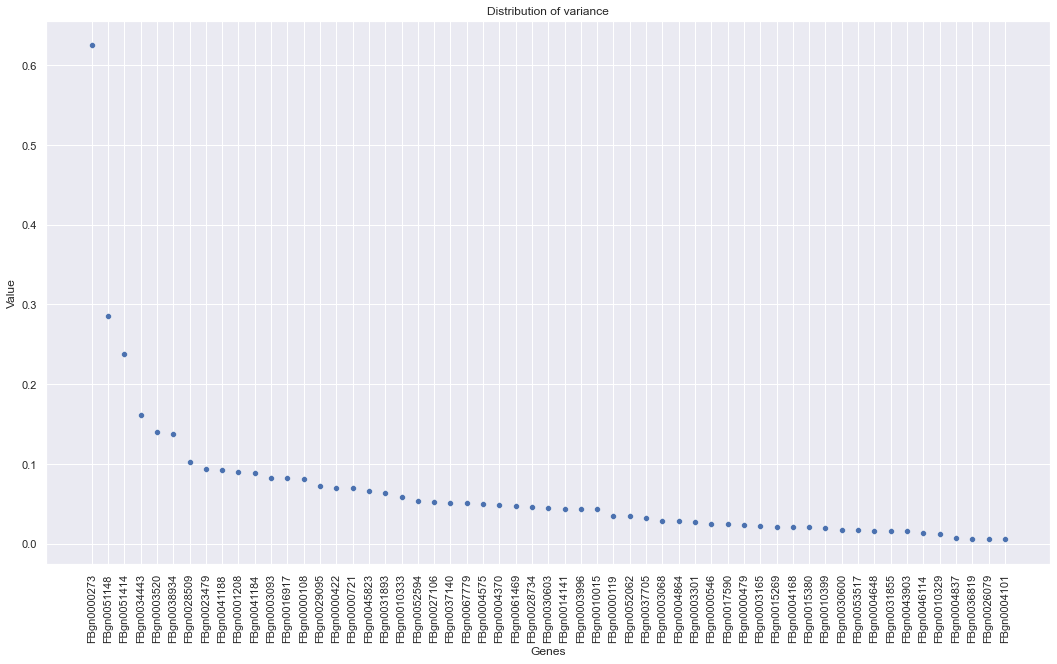

In [84]:
plot_gene_stats('variance', stats_memory_males)

In [85]:
var_genes_males['memory'] = list(stats_memory_males.iloc[:5,0].values)
var_genes_males

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0034443',
  'FBgn0003520',
  'FBgn0038934',
  'FBgn0038975',
  'FBgn0004907'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0038975',
  'FBgn0003861'],
 'memory': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0034443',
  'FBgn0003520']}

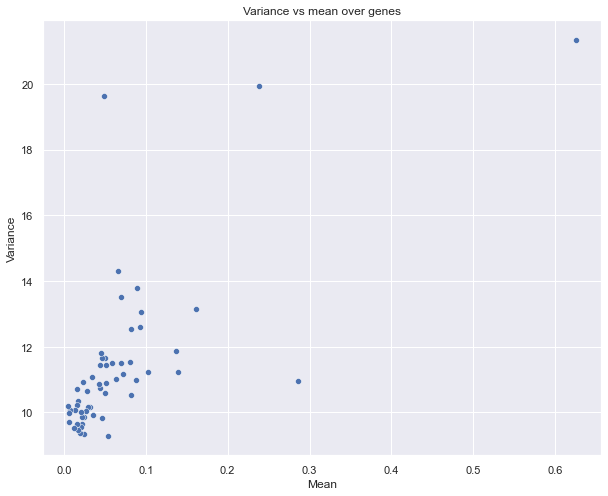

In [86]:
plot_var_vs_mean(stats_memory_males)

### Try something else: suppose that the data distribution over lines for a particular gene should be roughly normal
#### => if we can see 2 or more distributions, there should be 2 or more populations in lines => it should point out interesting genes

## Cognition

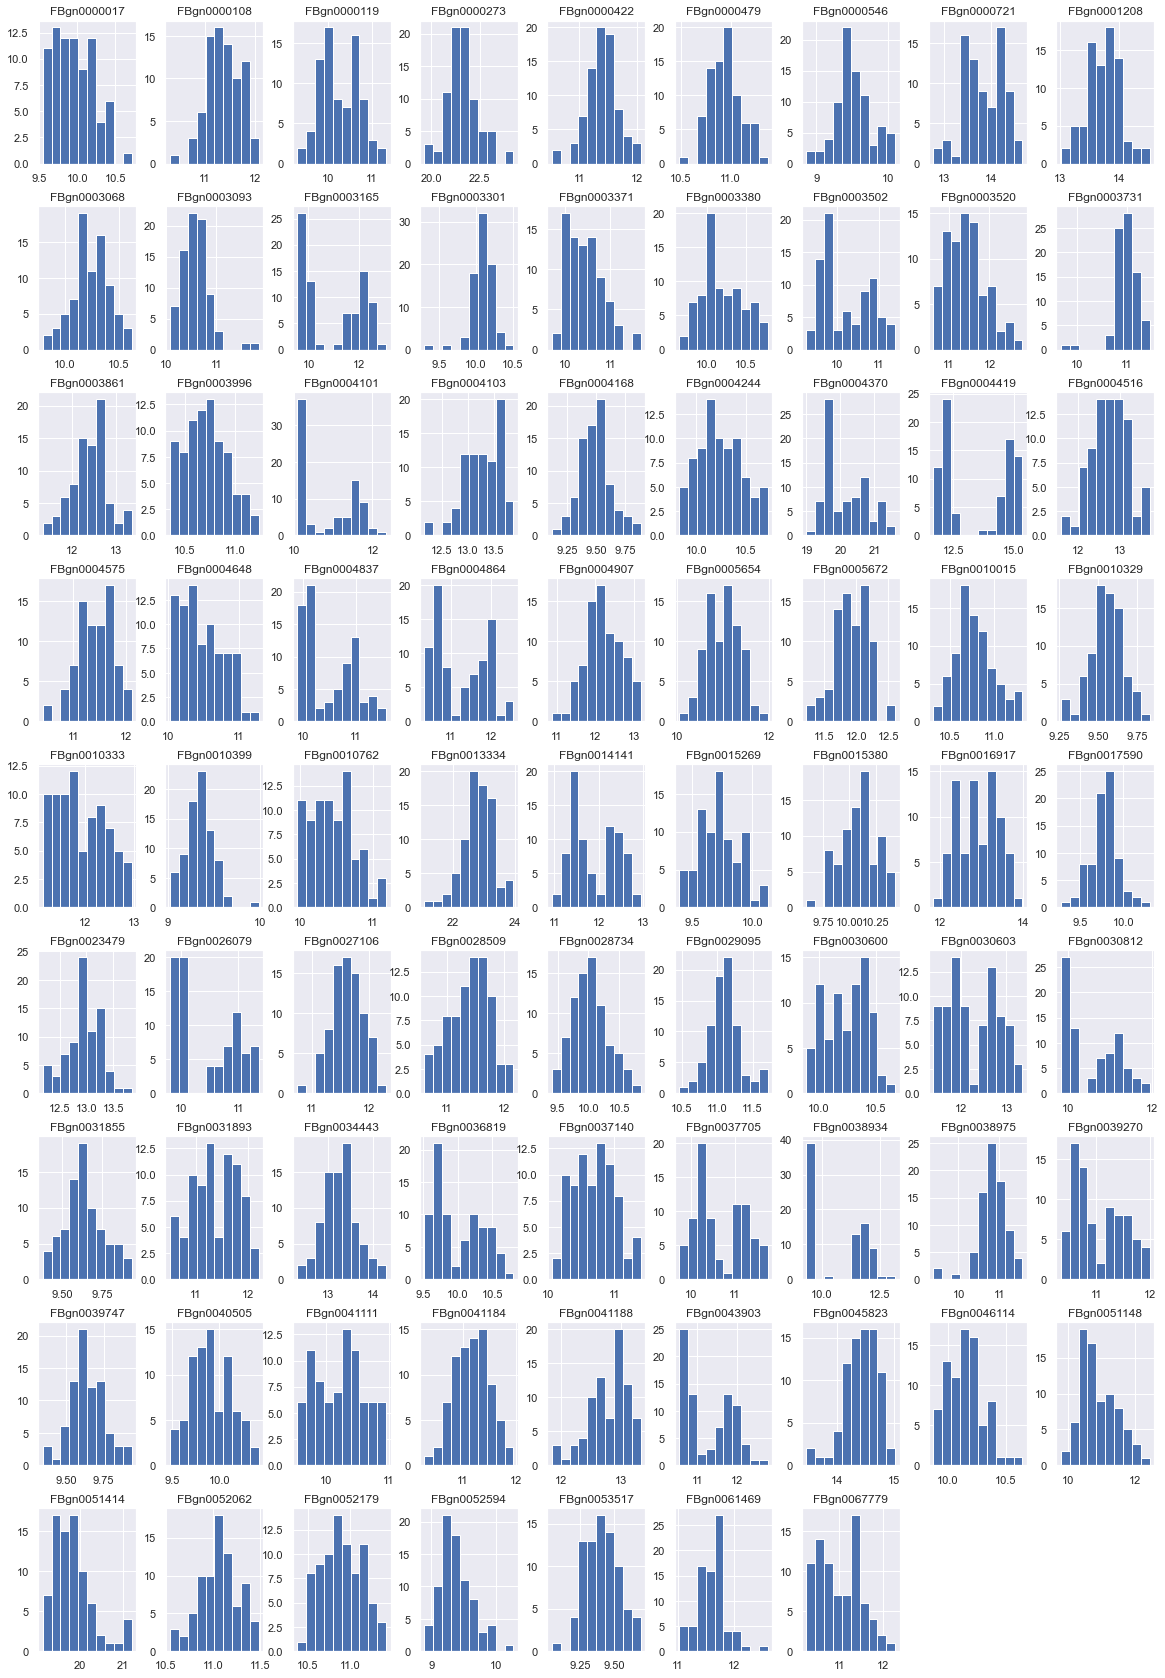

In [87]:
cognition_data.hist(figsize=(20, 30)); # All genes related to cognition

This assumption works quite well since for example for FBgn0004419, we can clearly observe 2 distinct distributions, and this gene was shown to be the most variable one among genes related to cognition. Same for FBgn0038934 or FBgn0000273 for example.

However some genes that were found to be highly variables across lines don't clearly show distinct distributions like FBgn0003165.

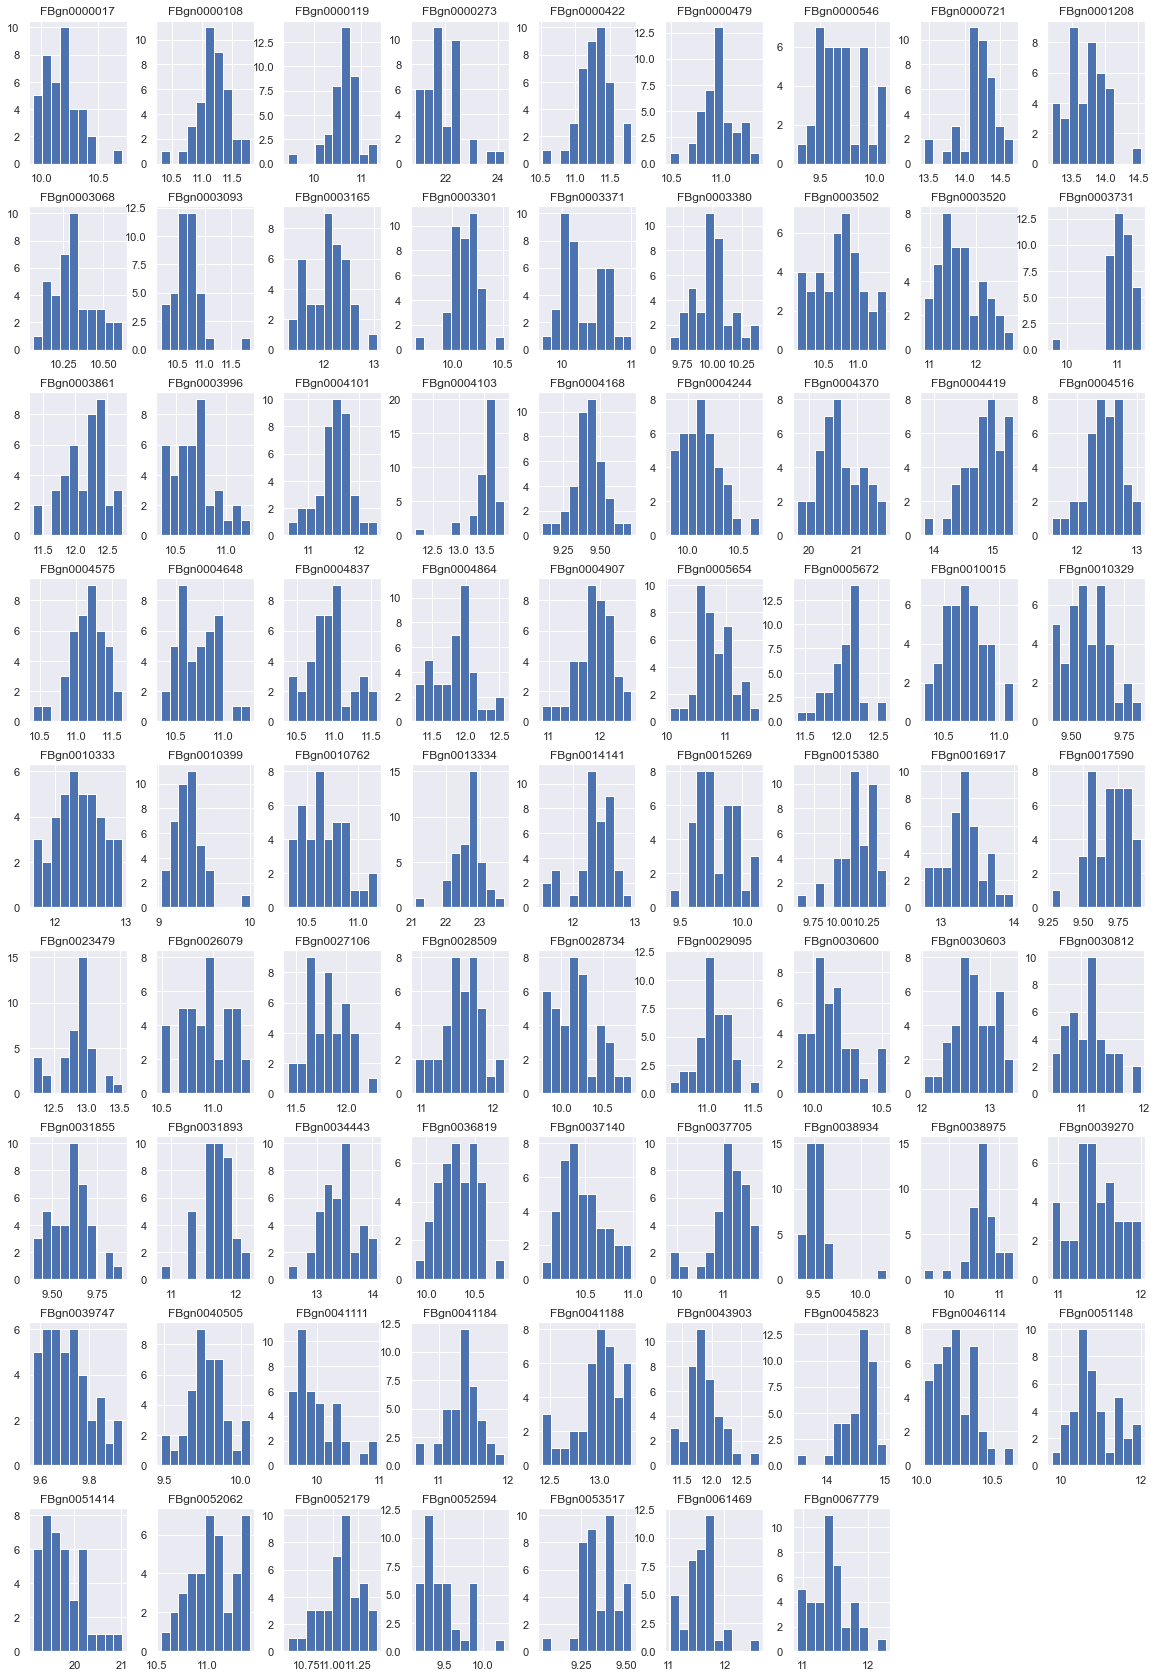

In [88]:
cognition_data_females.hist(figsize=(20, 30)); # Females only

It's still the case when looking only at females for some genes, but this is not substantial. Ie it is visible but we can not reliably infer which genes are the most variables accross lines just from the histrogram of the distribution.

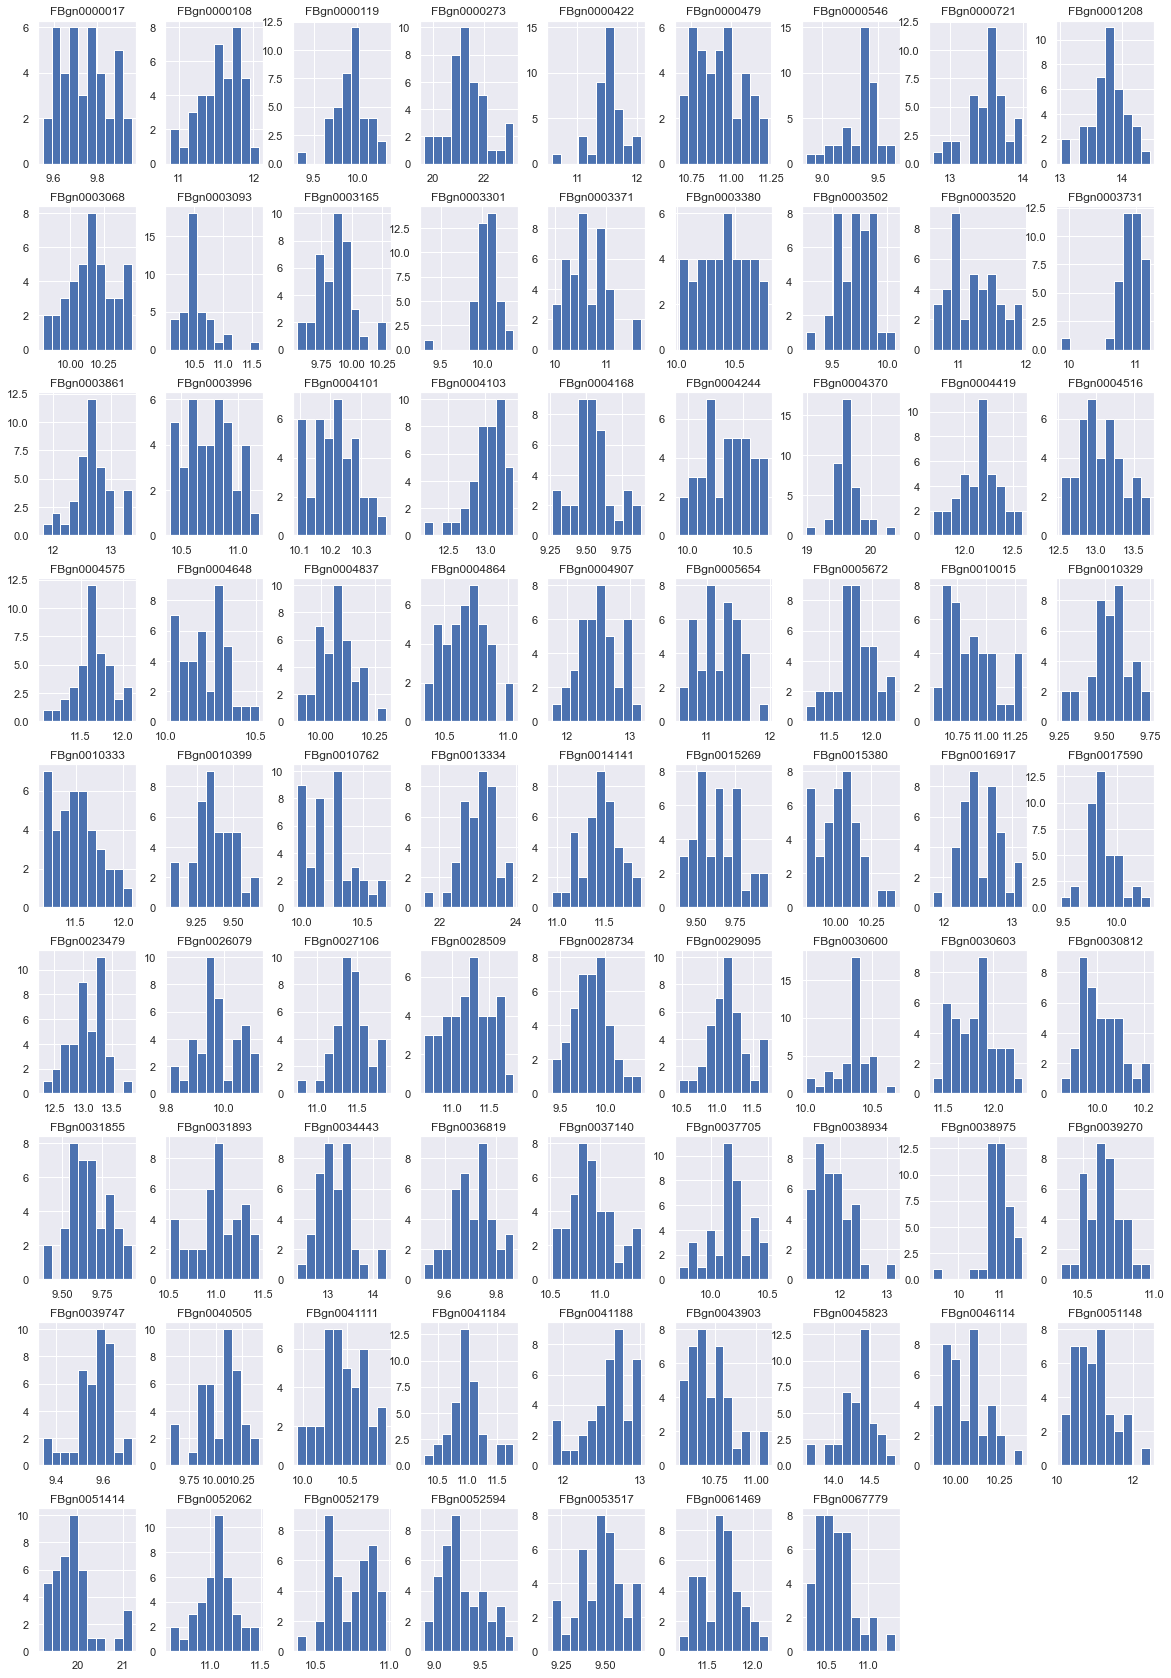

In [89]:
cognition_data_males.hist(figsize=(20, 30)); # Males only

Same for males. So just looking at histograms is not sufficiently reliable.

## Learning

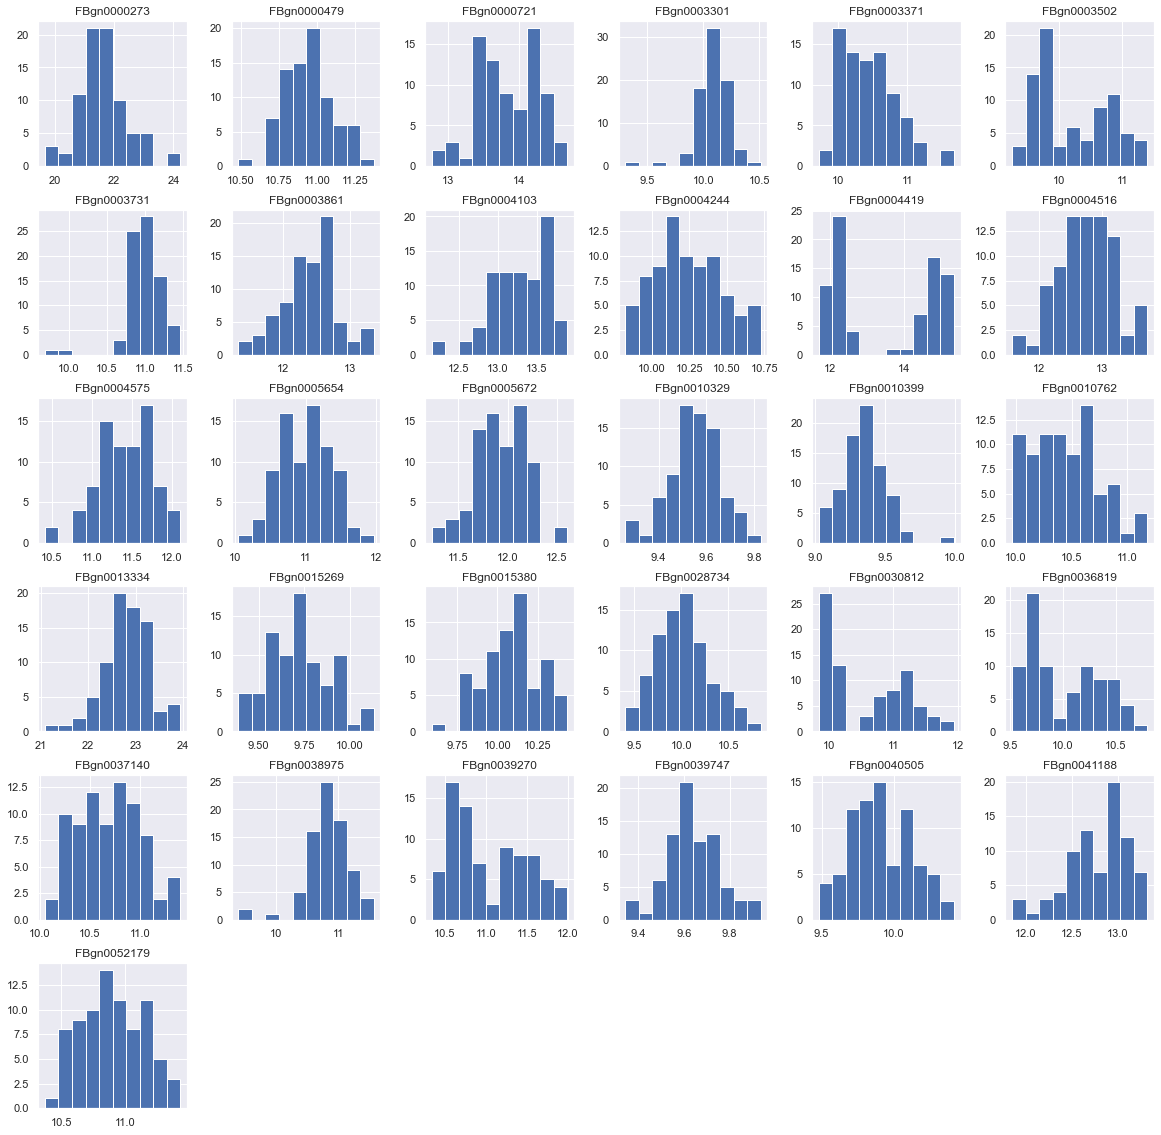

In [90]:
learning_data.hist(figsize=(20, 20)); # Learning genes only

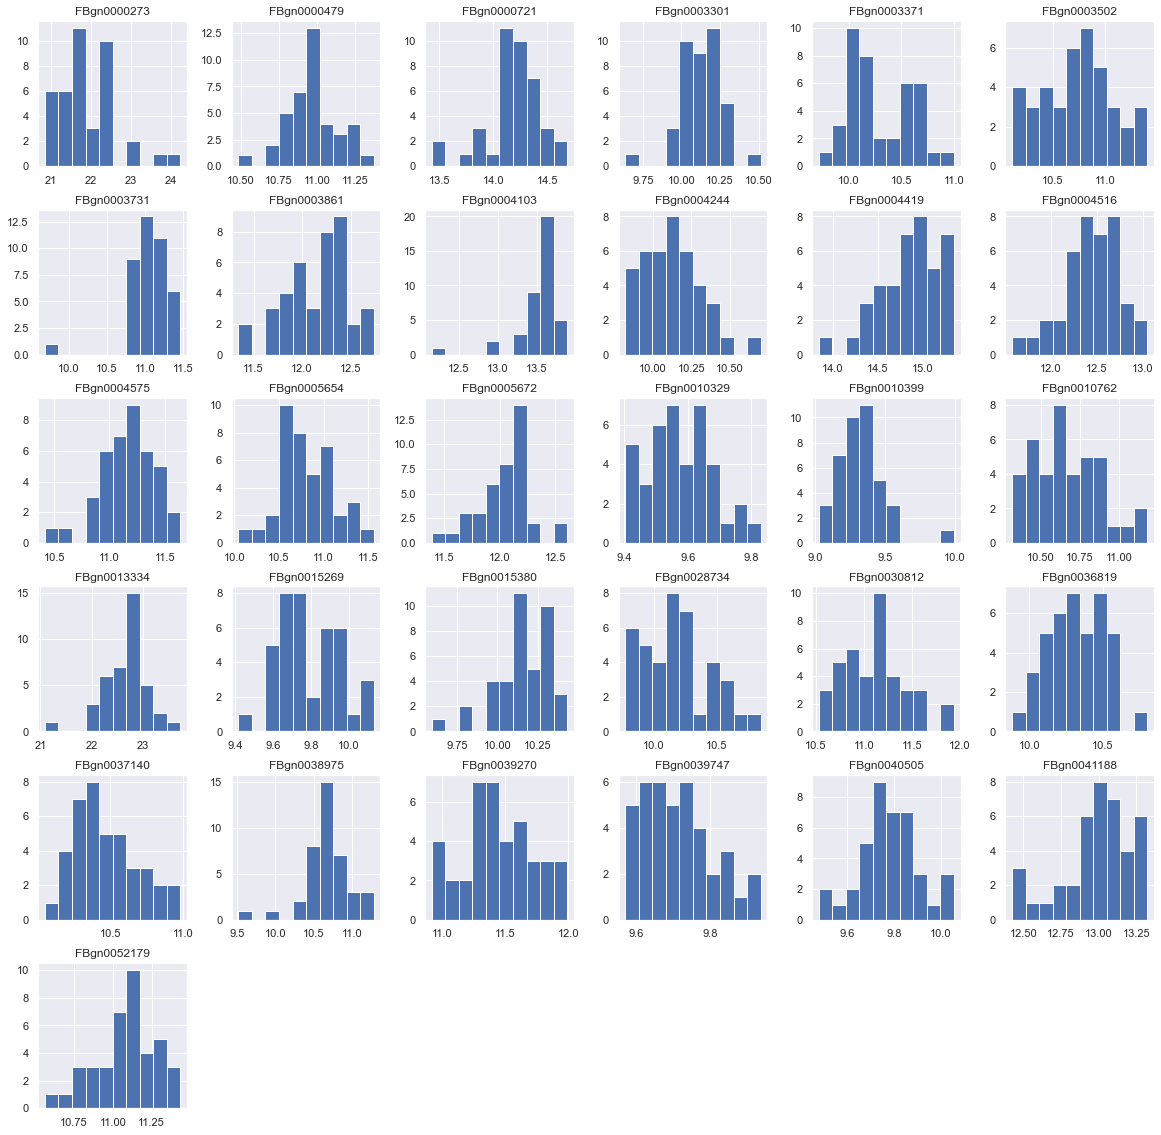

In [91]:
learning_data_females.hist(figsize=(20, 20)); # Learning genes only, females

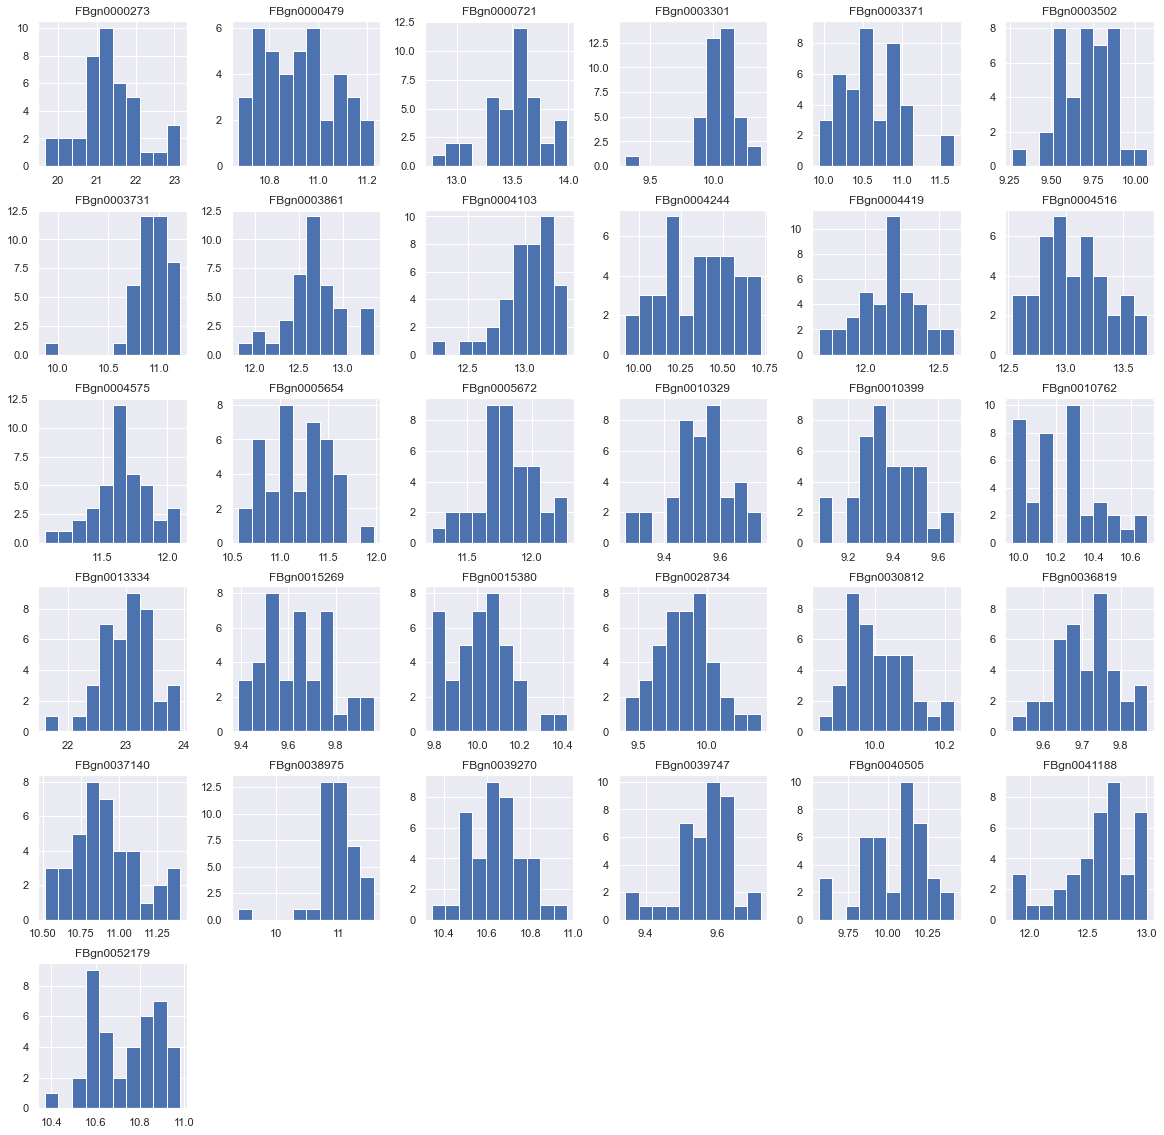

In [92]:
learning_data_males.hist(figsize=(20, 20)); # Learning genes only, males

## Memory

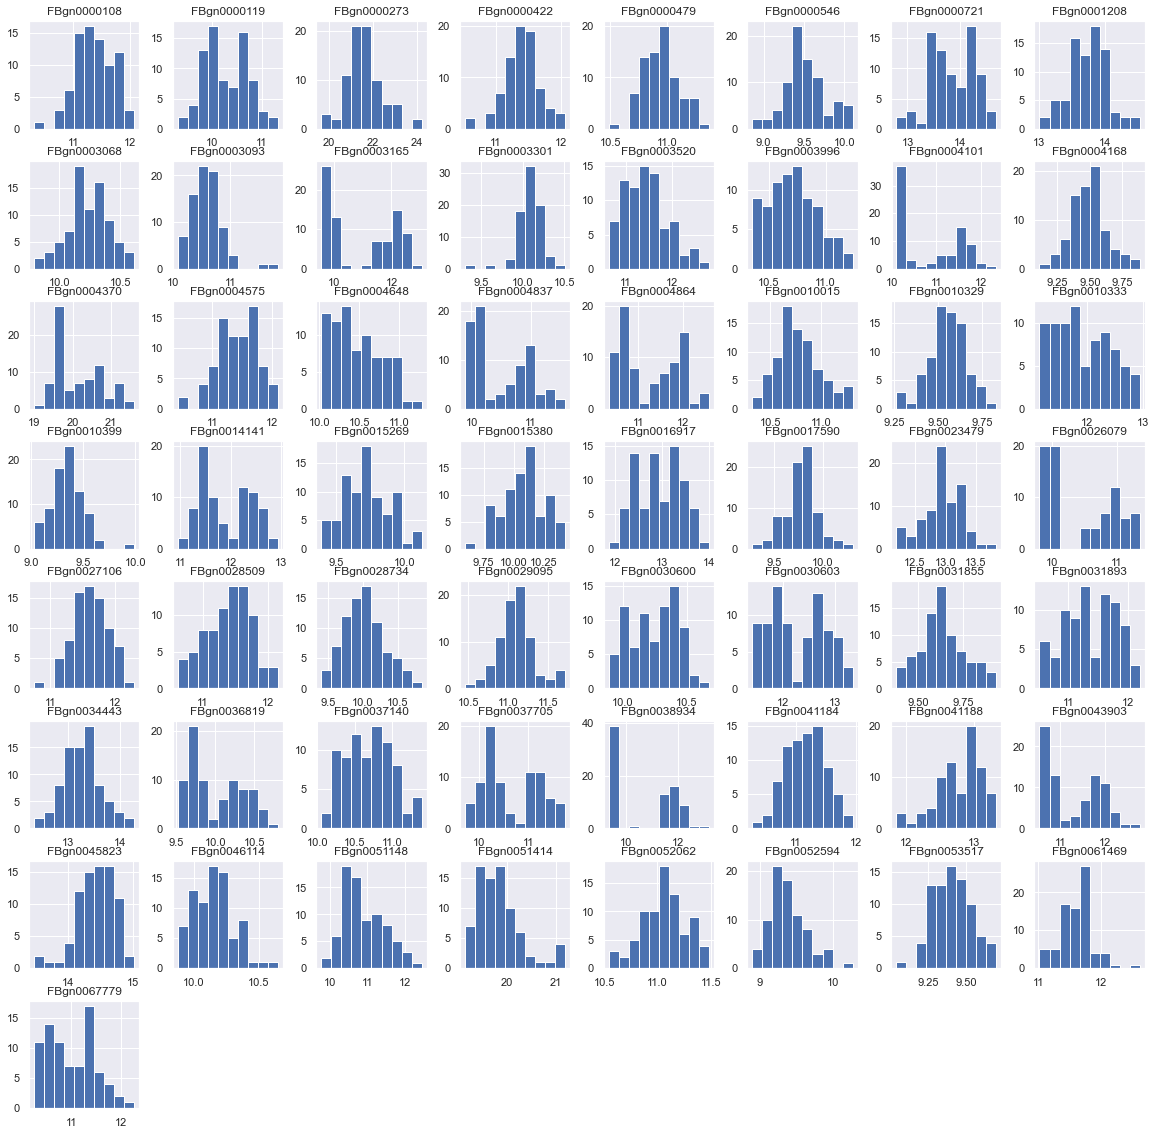

In [93]:
memory_data.hist(figsize=(20, 20)); # Memory genes only

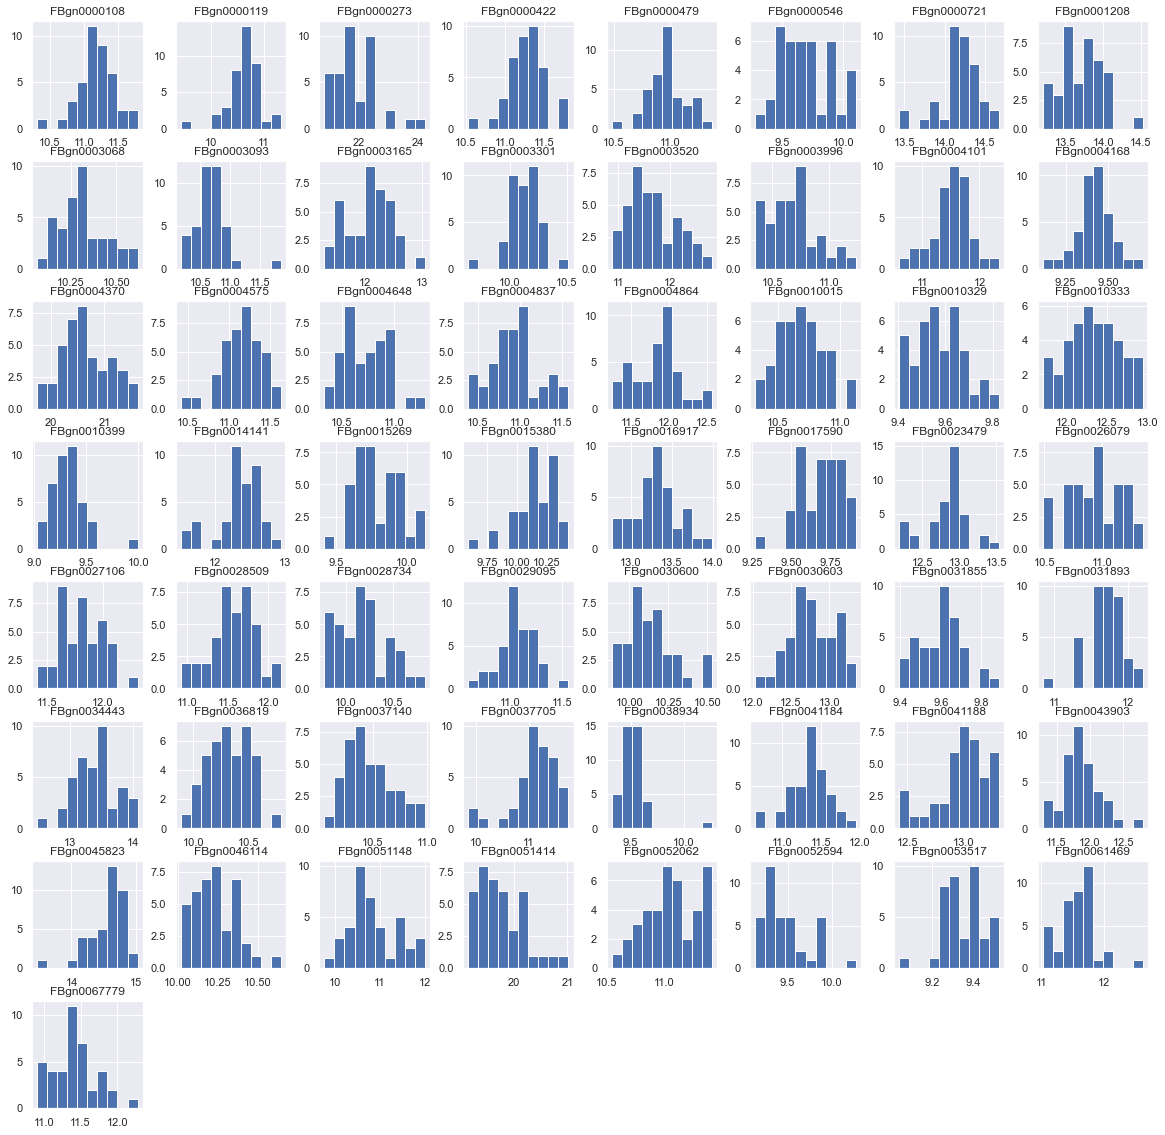

In [94]:
memory_data_females.hist(figsize=(20, 20)); # Memory genes only, females

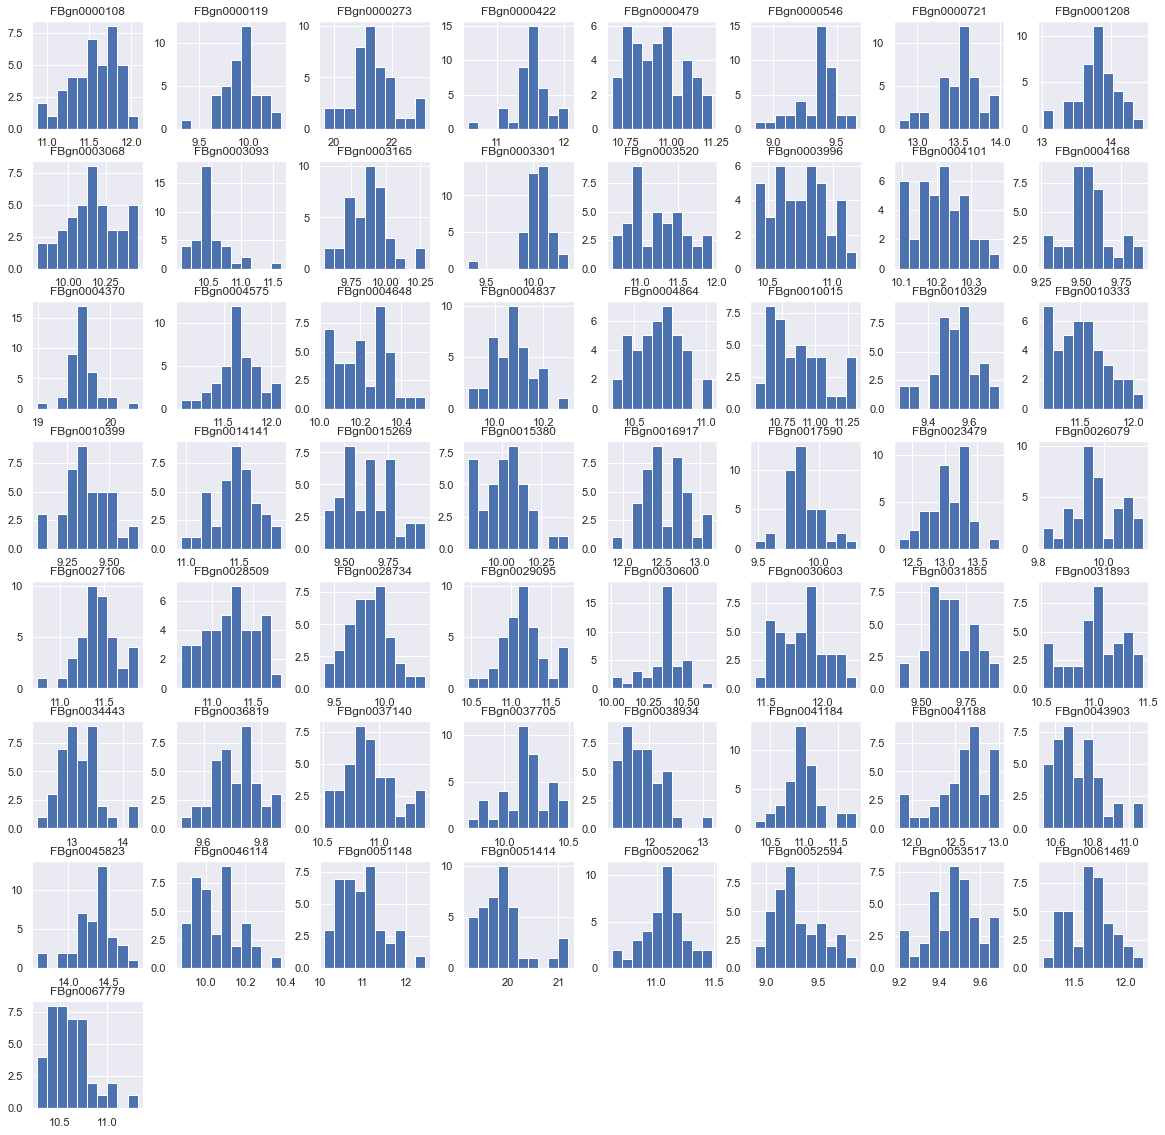

In [95]:
memory_data_males.hist(figsize=(20, 20)); # Memory genes only, males

## Analysis of the most variable selected genes

In [96]:
var_genes

{'cognition': ['FBgn0004419',
  'FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864',
  'FBgn0004370',
  'FBgn0043903',
  'FBgn0030812',
  'FBgn0003502'],
 'learning': ['FBgn0004419',
  'FBgn0000273',
  'FBgn0030812',
  'FBgn0003502',
  'FBgn0013334'],
 'memory': ['FBgn0038934',
  'FBgn0003165',
  'FBgn0000273',
  'FBgn0004101',
  'FBgn0004864']}

In [97]:
var_genes_females

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0013334',
  'FBgn0004370',
  'FBgn0051414',
  'FBgn0037705',
  'FBgn0003165',
  'FBgn0004907',
  'FBgn0041111'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003502',
  'FBgn0004419',
  'FBgn0030812'],
 'memory': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0004370',
  'FBgn0051414']}

In [98]:
var_genes_males

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0034443',
  'FBgn0003520',
  'FBgn0038934',
  'FBgn0038975',
  'FBgn0004907'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003371',
  'FBgn0038975',
  'FBgn0003861'],
 'memory': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0051414',
  'FBgn0034443',
  'FBgn0003520']}

The majority of the selected genes are present both when separating and not between females and males.
However, some genes do not really correspond. In addition, for some phenotypic data, the data is separated between females and males, or only available for one sex.
So for the sake of precision, we should definitely separate the analysis for females and males.

In [99]:
# Export the dict of interesting genes in a txt file
import json

with open('top_variable_genes_cognition.json', 'w') as json_file:
  json.dump(var_genes, json_file)

with open('females_top_variable_genes_cognition.json', 'w') as json_file:
  json.dump(var_genes_females, json_file)

with open('males_top_variable_genes_cognition.json', 'w') as json_file:
  json.dump(var_genes_males, json_file)

# LINK WITH THE PHENOTYPE

In [100]:
top_genes_cognition_females = var_genes_females['cognition'][:5]
top_genes_cognition_females.append('line')
top_genes_cognition_females

['FBgn0000273',
 'FBgn0051148',
 'FBgn0003520',
 'FBgn0013334',
 'FBgn0004370',
 'line']

In [101]:
females_cognition_genes_top = females_transcription.columns.intersection(top_genes_cognition_females)
females_cognition_data_top = females_transcription[females_cognition_genes_top]
females_cognition_data_top.head()

line     line  FBgn0000273  FBgn0003520  FBgn0004370  FBgn0013334  FBgn0051148
0     RAL_208     21.05188     12.34676     20.27956     22.96202     10.69253
1     RAL_301     24.23164     11.08169     20.66224     22.22478     11.84545
2     RAL_303     22.34808     11.60867     20.59278     22.28218     10.08896
3     RAL_304     22.10240     11.19446     20.34274     22.44493     10.23377
4     RAL_306     21.67665     11.29189     20.39512     22.87099     10.47261

In [102]:
top_genes_cognition_males = var_genes_males['cognition'][:5]
top_genes_cognition_males.append('line')
top_genes_cognition_males

['FBgn0000273',
 'FBgn0051148',
 'FBgn0051414',
 'FBgn0013334',
 'FBgn0003371',
 'line']

In [103]:
males_cognition_genes_top = males_transcription.columns.intersection(top_genes_cognition_males)
males_cognition_data_top = males_transcription[males_cognition_genes_top]
males_cognition_data_top.head()

line     line  FBgn0000273  FBgn0003371  FBgn0013334  FBgn0051148  FBgn0051414
40    RAL_208     20.79381     10.56715     23.05228     10.89426    19.973497
41    RAL_301     23.08654     10.70844     22.55886     12.44683    21.197886
42    RAL_303     22.20897     10.84502     22.72855     10.71158    19.702708
43    RAL_304     20.94015     11.05783     22.99439     11.21948    20.330065
44    RAL_306     21.15718     11.10842     23.15257     10.82261    19.666373

# Link with the metabolic rate

The metabolic rate data comes from the paper "A Quantitative Genomic Approach for Analysis of Fitness and Stress Related Traits in a Drosophila melanogaster Model Population".

Note that we only have metabolic rate data for females. So we restrict the analysis here to females.

In [104]:
# Load the metabolic rate data 
METABOLIC_RATE_DATA = "metabolic_rate_quantitative_genetic_analysis_paper.xlsx"

metabolic_rate = pd.read_excel(PATH + METABOLIC_RATE_DATA, sheet_name = 'Sheet1', usecols = [0, 1], skiprows = 0,
                                        names = ['line', 'metabolic rate'])
metabolic_rate.dropna(inplace=True)
metabolic_rate.head()

line  metabolic rate
1  RAL_707            1.57
2  RAL_712            1.59
3  RAL_852            1.59
5  RAL_427            1.41
6  RAL_799            1.57

In [105]:
var_genes_females

{'cognition': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0013334',
  'FBgn0004370',
  'FBgn0051414',
  'FBgn0037705',
  'FBgn0003165',
  'FBgn0004907',
  'FBgn0041111'],
 'learning': ['FBgn0000273',
  'FBgn0013334',
  'FBgn0003502',
  'FBgn0004419',
  'FBgn0030812'],
 'memory': ['FBgn0000273',
  'FBgn0051148',
  'FBgn0003520',
  'FBgn0004370',
  'FBgn0051414']}

We can observe from this dictionnary of most variable genes that the most reccuring ones among cognition, learning and memory are the first five assimilated to cognition: FBgn0000273 (memory and learning), FBgn0051148 (memory), FBgn0003520 (memory), FBgn0013334 (learning), FBgn0004370 (memory).

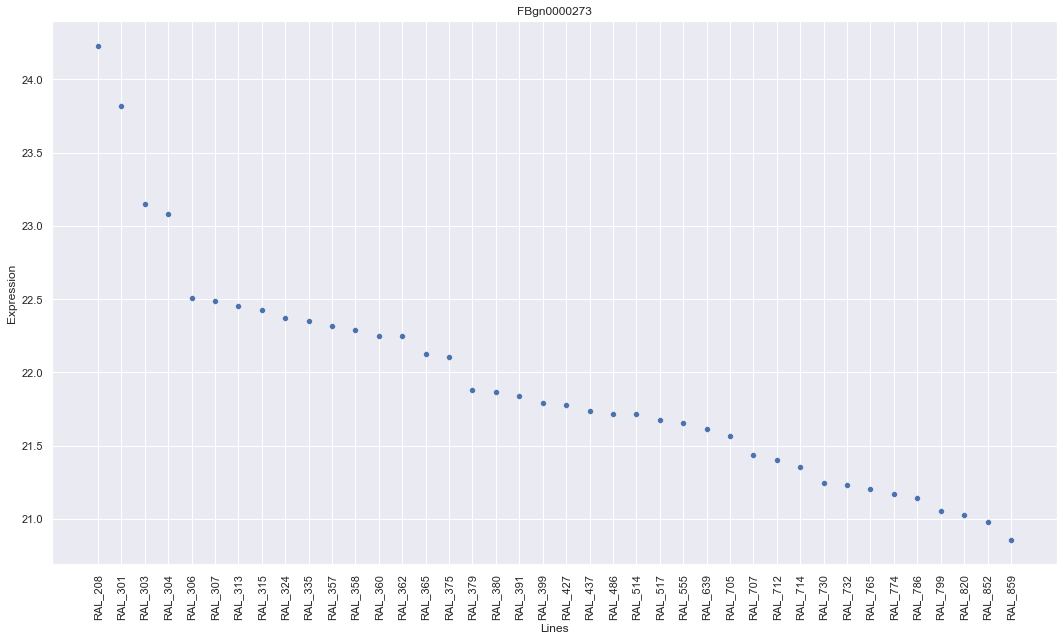

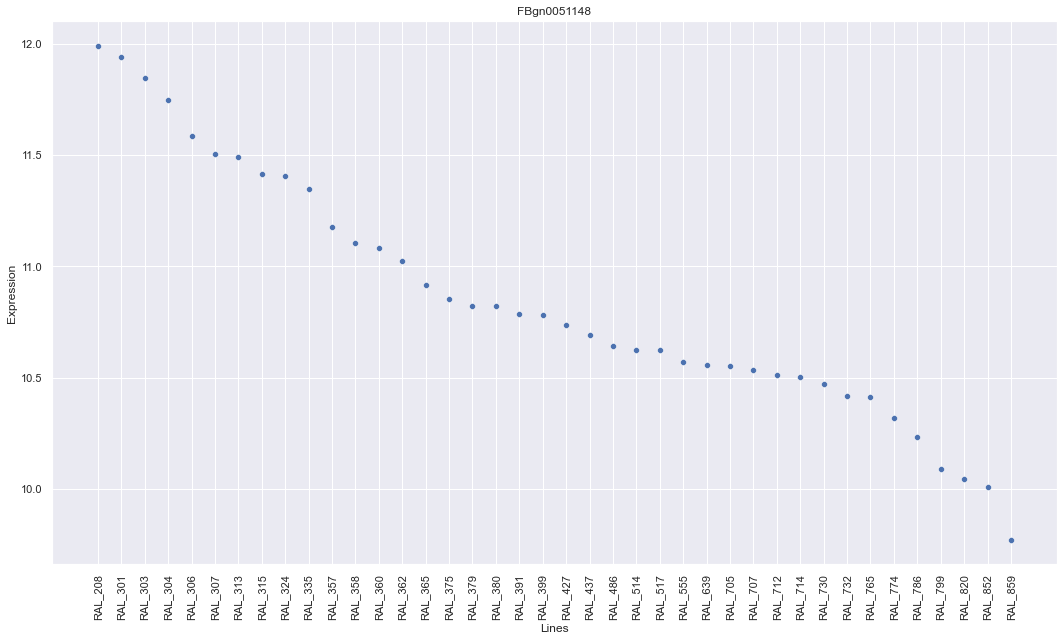

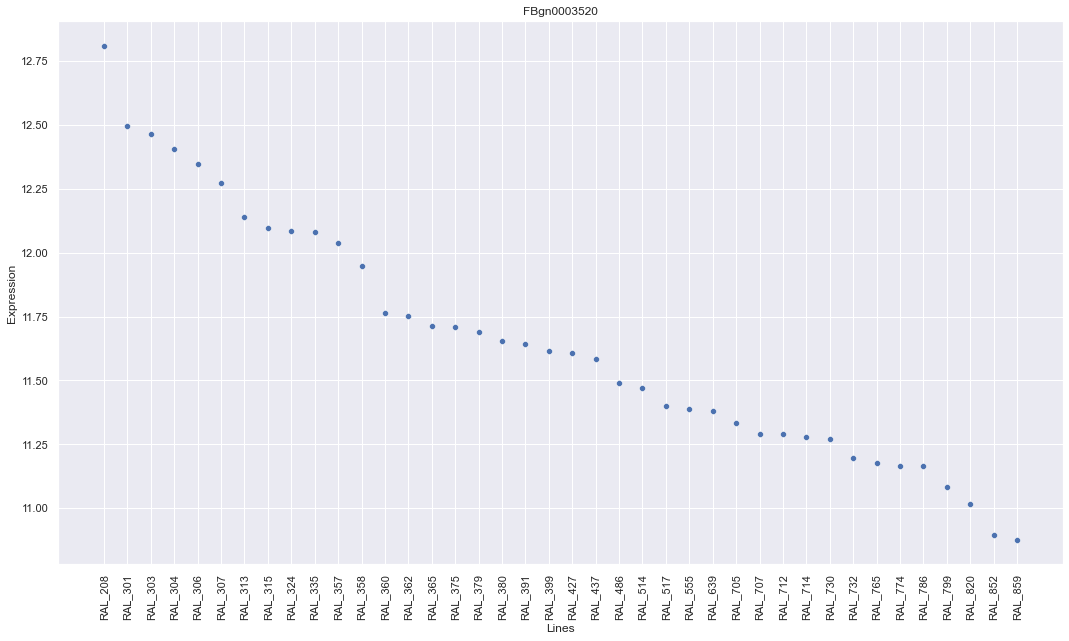

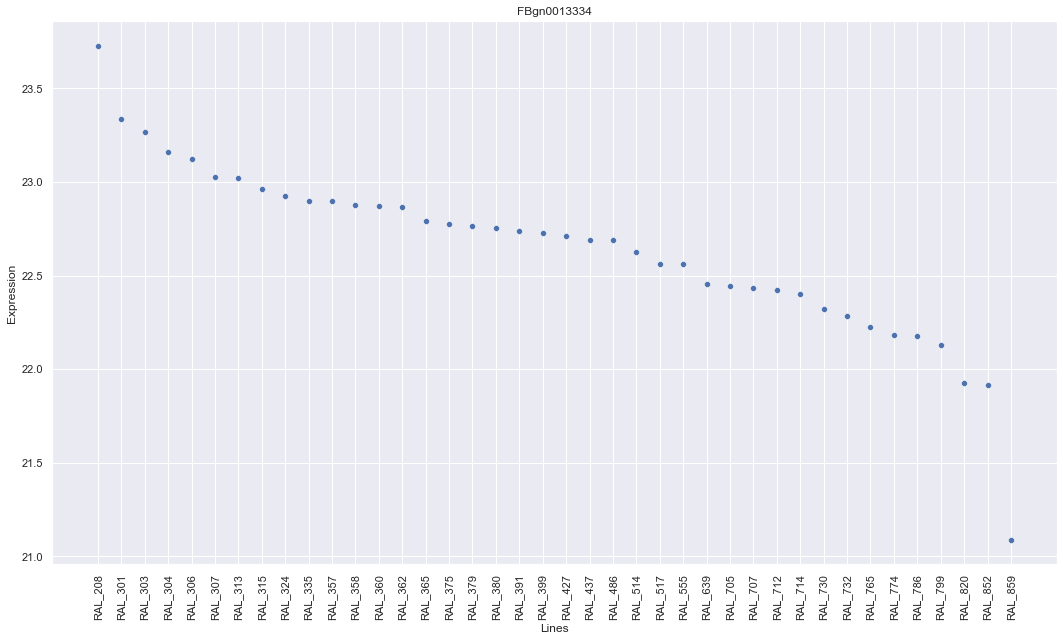

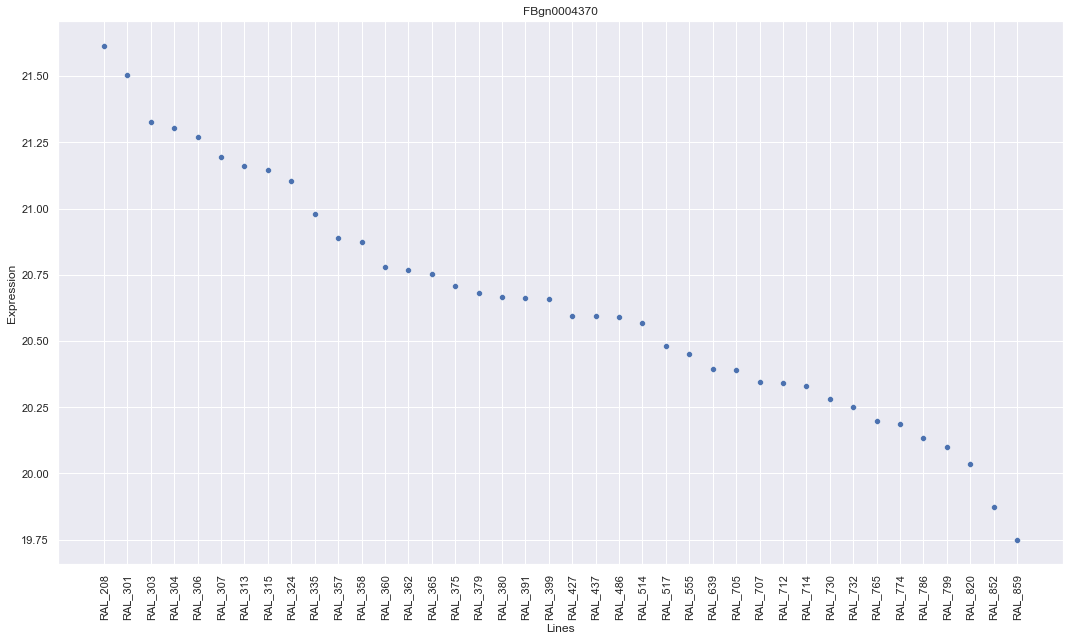

In [106]:
for i in range(len(top_genes_cognition_females)-1):
    plot_gene_expression(top_genes_cognition_females[i], females_cognition_data_top)

In [107]:
# Keep only female lines where data about metabolic rate is present
merged = pd.merge(metabolic_rate, females_cognition_data_top, left_on='line', right_on='line', how='inner')
merged.head()

line  metabolic rate  FBgn0000273  FBgn0003520  FBgn0004370  \
0  RAL_707            1.57     21.23311     11.38763     20.56701   
1  RAL_712            1.59     21.39979     11.16493     20.97812   
2  RAL_852            1.59     21.83953     11.40032     21.26859   
3  RAL_427            1.41     21.71792     12.81097     21.32631   
4  RAL_799            1.57     21.43463     12.27110     21.14511   

   FBgn0013334  FBgn0051148  
0     21.08846    11.991910  
1     23.02914    11.489290  
2     22.89668    10.553910  
3     22.62310     9.771085  
4     22.87528    10.623240

In [108]:
sr_correlations_cognition_metabolic_rate = pd.DataFrame()
sr_correlations_cognition_metabolic_rate['correlated_gene'] = top_genes_cognition_females[:-1]
sr_correlations_cognition_metabolic_rate

correlated_gene
0     FBgn0000273
1     FBgn0051148
2     FBgn0003520
3     FBgn0013334
4     FBgn0004370

In [111]:
import statsmodels as sm

# Compute the Spearman rank correlation for each pair of metabolic rate - gene of interest
sr_correlations_cognition_metabolic_rate['sr_correlation'] = sr_correlations_cognition_metabolic_rate.apply(lambda x: stats.spearmanr(merged['metabolic rate'], merged[x['correlated_gene']])[0], axis=1)
sr_correlations_cognition_metabolic_rate['p_value'] = sr_correlations_cognition_metabolic_rate.apply(lambda x: stats.spearmanr(merged['metabolic rate'], merged[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_cognition_metabolic_rate['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_cognition_metabolic_rate['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_cognition_metabolic_rate['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_cognition_metabolic_rate['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_cognition_metabolic_rate

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0000273        0.300293  0.185961               0.929806   
1     FBgn0051148        0.252194  0.270080               1.000000   
2     FBgn0003520        0.181996  0.429781               1.000000   
3     FBgn0013334        0.126097  0.585996               1.000000   
4     FBgn0004370        0.343842  0.126968               0.634840   

   Benjamini/Hochberg correction  
0                       0.450134  
1                       0.450134  
2                       0.537226  
3                       0.585996  
4                       0.450134

No significant correlation, and correlation values are small.

In [112]:
# Quick plot of the correlations
def plot_correlations(sr_correlations):
    sns.set() # Set the seaborn default aesthetics 

    f, ax = plt.subplots(figsize=(10, 6))
    labels = sr_correlations['correlated_gene'].values
    sns.barplot(x = 'correlated_gene', y = 'sr_correlation', data = sr_correlations,
                     palette = (sr_correlations['sr_correlation'] > 0).map({True: 'tab:orange', False: 'tab:blue'}))

    ax.set_title('Correlations with the metabolic rate')
    #ax.get_legend().remove()
    ax.set(ylabel='R', xlabel='')
    ax.axhline(y=0, color='black') # Set the horizontal line at y=0
    ax.set_xticklabels(labels, rotation=90) # Vertical labels for the x axis

    # Set the width of the bars if desired
    for bar in ax.patches:
        bar.set_width(0.4)

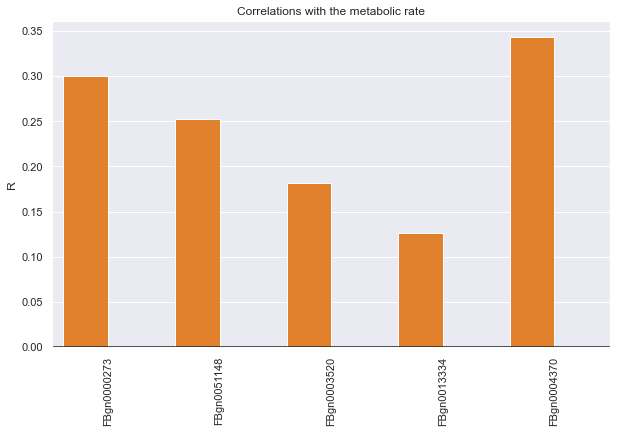

In [113]:
plot_correlations(sr_correlations_cognition_metabolic_rate)

In [114]:
# Plot the metabolic rate vs a specific gene expression for each line
################ NOT CALLED FOR THE MOMENT ################
def plot_metabolic_rate_lines_vs_gene(df, gene):
    sns.set() # Set the seaborn default aesthetics 
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection = '3d')

    x = np.linspace(0, 10, df.shape[0])
    y = df['metabolic rate']
    z = df[gene]

    ax.set_xlabel("line")
    ax.set_ylabel("metabolic rate")
    ax.set_zlabel(gene)
    ax.set_xticklabels(df['line'], rotation=90) # Vertical labels for the x axis
    
    ax.scatter(x, y, z)

In [115]:
#plot_metabolic_rate_lines_vs_gene(merged, top_genes_cognition[0])

In [116]:
# Plot the phenotypic data of one trait vs a specific gene expression for each line

def plot_phenotypic_data_vs_gene(df, gene, phenotypic_trait):
    sns.set() # Set the seaborn default aesthetics 

    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.scatterplot(x = gene, y = phenotypic_trait, data = df, hue = 'line');

    ax.set_title(phenotypic_trait + ' vs ' + gene + ' expression accross lines');
    ax.set(ylabel=phenotypic_trait, xlabel='gene expression of '+ gene);

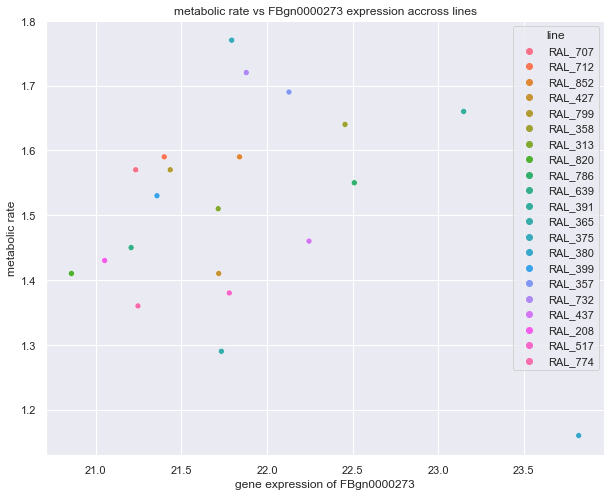

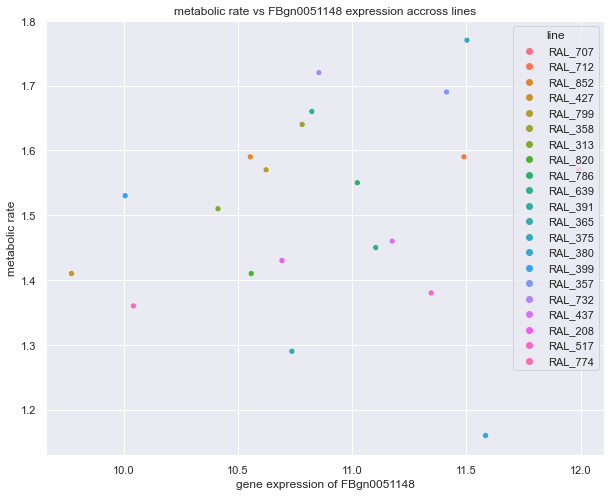

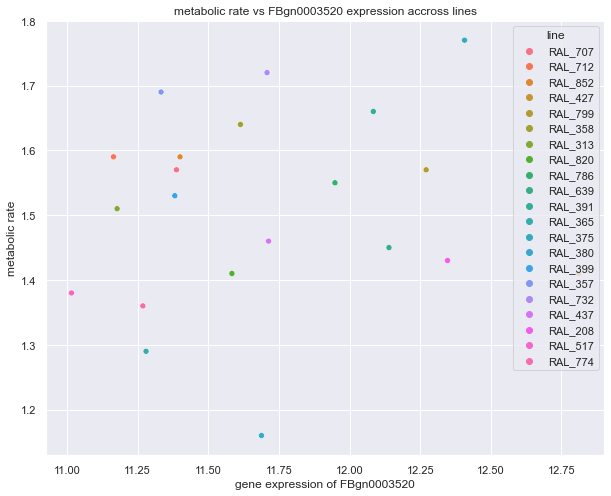

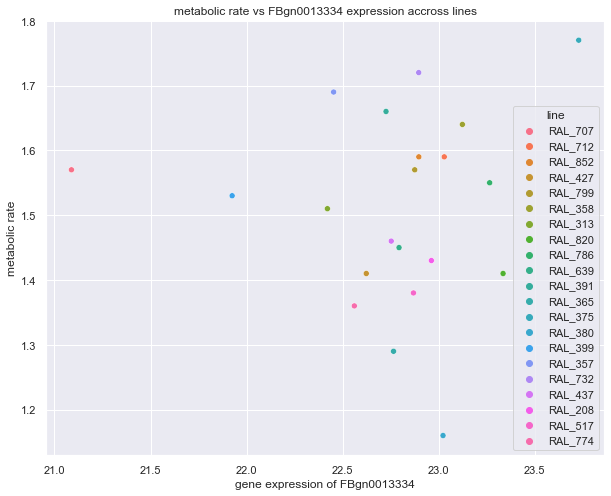

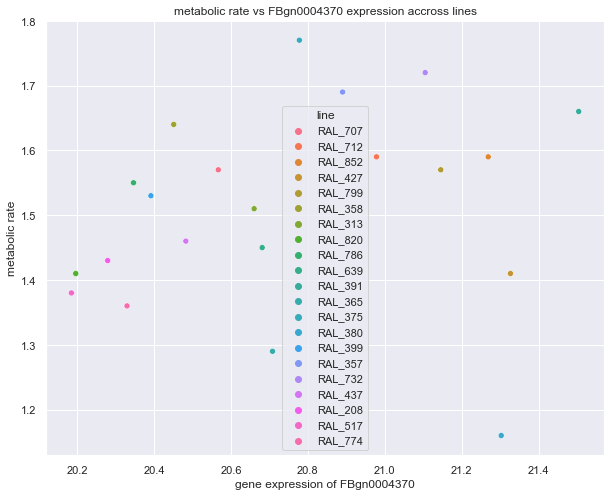

In [117]:
for i in range(len(top_genes_cognition_females)-1):
    plot_phenotypic_data_vs_gene(merged, top_genes_cognition_females[i], 'metabolic rate')

Now we just compute the Spearman's rank correlations between the selected genes for cognition and the genes found to be linked to metabolic rate in the paper "A Quantitative Genomic Approach for Analysis of Fitness and Stress Related Traits in a Drosophila melanogaster Model Population":

In [118]:
# List of genes significantly related to metabolic rate, given the paper
metabolic_rate_genes_conversion = {'Gr28b': 'FBgn0045495', 'fz': 'FBgn0001085', 'bru': 'FBgn0261787',
                                   'dl': 'FBgn0260632', 'Fife': 'FBgn0264606'} # conversion table to FlyBase IDs
metabolic_rate_genes = list(metabolic_rate_genes_conversion.values())
metabolic_rate_genes.append('line')
metabolic_rate_genes

['FBgn0045495',
 'FBgn0001085',
 'FBgn0261787',
 'FBgn0260632',
 'FBgn0264606',
 'line']

In [119]:
# Just keep columns in the transcription data that correspond to these genes related to metabolic rate 
metabolic_genes = females_transcription.columns.intersection(metabolic_rate_genes)
metabolic_genes_data = females_transcription[metabolic_genes]
metabolic_genes_data.head()

line     line  FBgn0001085
0     RAL_208    20.183920
1     RAL_301    19.907919
2     RAL_303    20.200375
3     RAL_304    20.249465
4     RAL_306    20.264401

Only one of the genes expressed here in our transcription dataset.

In [120]:
# Merge on lines to have the same ordering in the table
merged = pd.merge(metabolic_genes_data, females_cognition_data_top, left_on='line', right_on='line', how='inner')
merged.head()

line     line  FBgn0001085  FBgn0000273  FBgn0003520  FBgn0004370  \
0     RAL_208    20.183920     21.05188     12.34676     20.27956   
1     RAL_301    19.907919     24.23164     11.08169     20.66224   
2     RAL_303    20.200375     22.34808     11.60867     20.59278   
3     RAL_304    20.249465     22.10240     11.19446     20.34274   
4     RAL_306    20.264401     21.67665     11.29189     20.39512   

line  FBgn0013334  FBgn0051148  
0        22.96202     10.69253  
1        22.22478     11.84545  
2        22.28218     10.08896  
3        22.44493     10.23377  
4        22.87099     10.47261

In [121]:
sr_correlations_metabolic_genes = pd.DataFrame()
sr_correlations_metabolic_genes['correlated_gene'] = top_genes_cognition_females[:-1]
sr_correlations_metabolic_genes

correlated_gene
0     FBgn0000273
1     FBgn0051148
2     FBgn0003520
3     FBgn0013334
4     FBgn0004370

In [122]:
# Compute the Spearman rank correlation for each pair of metabolic rate gene - gene selected for cognition
sr_correlations_metabolic_genes['sr_correlation'] = sr_correlations_metabolic_genes.apply(lambda x: stats.spearmanr(merged[metabolic_genes[1:]], merged[x['correlated_gene']])[0], axis=1)
sr_correlations_metabolic_genes['p_value'] = sr_correlations_metabolic_genes.apply(lambda x: stats.spearmanr(merged[metabolic_genes[1:]], merged[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_metabolic_genes['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_metabolic_genes['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_metabolic_genes['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_metabolic_genes['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_metabolic_genes

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0000273        0.102064  0.530870               1.000000   
1     FBgn0051148       -0.077111  0.636262               1.000000   
2     FBgn0003520        0.581051  0.000084               0.000422   
3     FBgn0013334        0.222889  0.166837               0.834187   
4     FBgn0004370        0.558724  0.000179               0.000895   

   Benjamini/Hochberg correction  
0                       0.636262  
1                       0.636262  
2                       0.000422  
3                       0.278062  
4                       0.000447

Quite strong, and highly significant correlations between fz and FBgn0003520, and between fz and FBgn0004370.

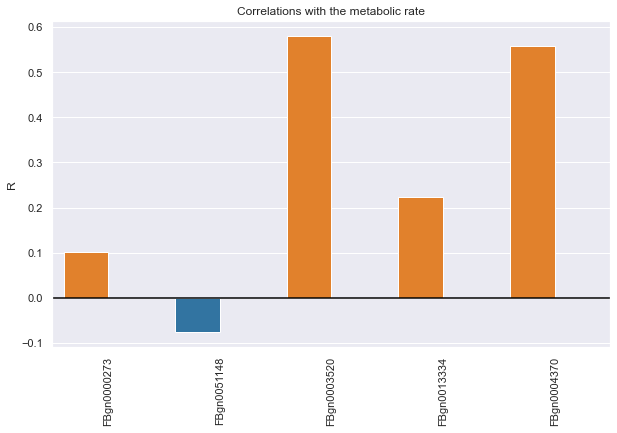

In [123]:
plot_correlations(sr_correlations_metabolic_genes)

# Link with the lifespan

Here we use the data from the paper "Context-dependent genetic architecture of Drosophila life span", and we choose to focus on the data recorded at 18°C since it appears to be the most variable across the different lines.

In [124]:
# Load the life span data 

LIFE_SPAN_DATA = "life_span.xlsx"

life_span = pd.read_excel(PATH + LIFE_SPAN_DATA, sheet_name = 'Line means', usecols = [0, 1, 2], skiprows = 0,
                                        names = ['line', 'life span females 18°C', 'life span males 18°C'])
life_span.dropna(inplace=True)
life_span.head()

line life span females 18°C life span males 18°C
1  DGRP_101                81.8657              93.7869
2  DGRP_105                104.968              106.627
3  DGRP_109                82.1912              105.689
4  DGRP_129                77.4348              78.0308
5  DGRP_136                107.571              92.4375

In [125]:
# Transform the line names to have correspondance for the merge
life_span['line'] = life_span.apply(lambda x: 'RAL' + x['line'][4:], axis=1)
life_span.head()

line life span females 18°C life span males 18°C
1  RAL_101                81.8657              93.7869
2  RAL_105                104.968              106.627
3  RAL_109                82.1912              105.689
4  RAL_129                77.4348              78.0308
5  RAL_136                107.571              92.4375

In [126]:
#life_span['mean life span 18°C'] = life_span.apply(lambda x: (x['life span females 18°C'] + x['life span males 18°C'])/2.0, axis=1)
#life_span

### Females 

In [127]:
# Merge on lines to have the same ordering of lines in the table
merged_females_LF = pd.merge(life_span[['line', 'life span females 18°C']], females_cognition_data_top, left_on='line', right_on='line', how='inner')
merged_females_LF.head()

line life span females 18°C  FBgn0000273  FBgn0003520  FBgn0004370  \
0  RAL_208                 120.18     21.05188     12.34676     20.27956   
1  RAL_301                74.1304     24.23164     11.08169     20.66224   
2  RAL_303                78.9524     22.34808     11.60867     20.59278   
3  RAL_304                90.9692     22.10240     11.19446     20.34274   
4  RAL_306                104.678     21.67665     11.29189     20.39512   

   FBgn0013334  FBgn0051148  
0     22.96202     10.69253  
1     22.22478     11.84545  
2     22.28218     10.08896  
3     22.44493     10.23377  
4     22.87099     10.47261

In [128]:
# We now look at the correlations between life span data and the selected genes for cognition
sr_correlations_life_span_females = pd.DataFrame()
sr_correlations_life_span_females['correlated_gene'] = top_genes_cognition_females[:-1]
sr_correlations_life_span_females['sr_correlation'] = sr_correlations_life_span_females.apply(lambda x: stats.spearmanr(merged_females_LF['life span females 18°C'], merged_females_LF[x['correlated_gene']])[0], axis=1)
sr_correlations_life_span_females['p_value'] = sr_correlations_life_span_females.apply(lambda x: stats.spearmanr(merged_females_LF['life span females 18°C'], merged_females_LF[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_life_span_females['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_life_span_females['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_life_span_females['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_life_span_females['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_life_span_females

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0000273        0.005580  0.973474               1.000000   
1     FBgn0051148       -0.200788  0.226759               1.000000   
2     FBgn0003520        0.218952  0.186597               0.932984   
3     FBgn0013334        0.280884  0.087594               0.437971   
4     FBgn0004370        0.004267  0.979714               1.000000   

   Benjamini/Hochberg correction  
0                       0.979714  
1                       0.377932  
2                       0.377932  
3                       0.377932  
4                       0.979714

No significant correlations.

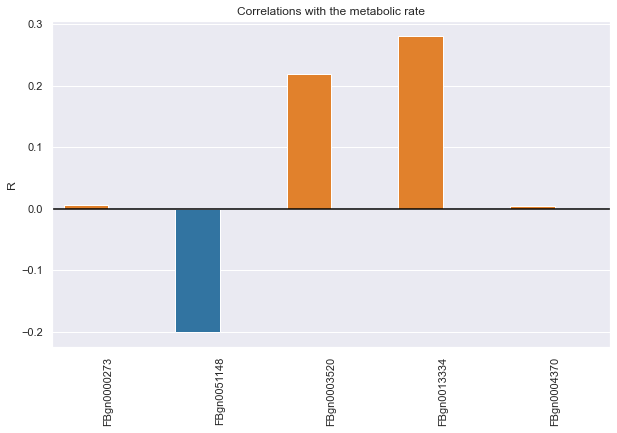

In [129]:
plot_correlations(sr_correlations_life_span_females)

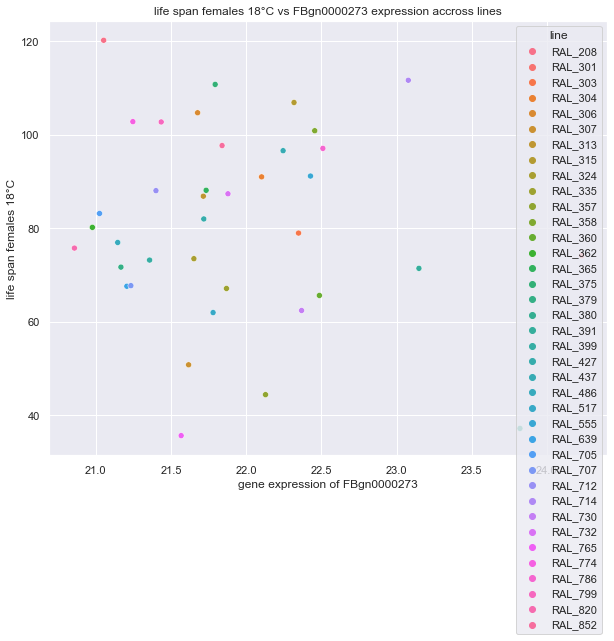

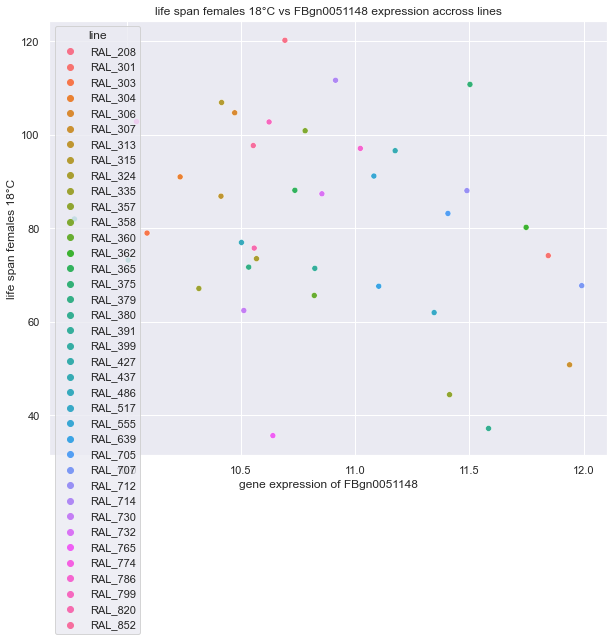

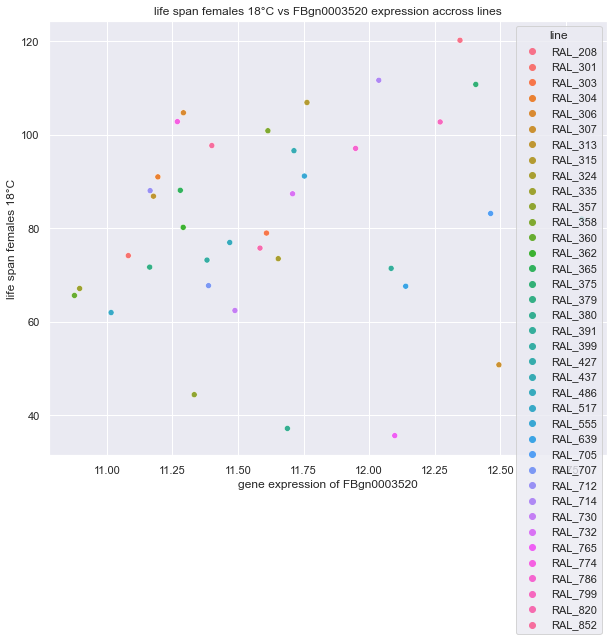

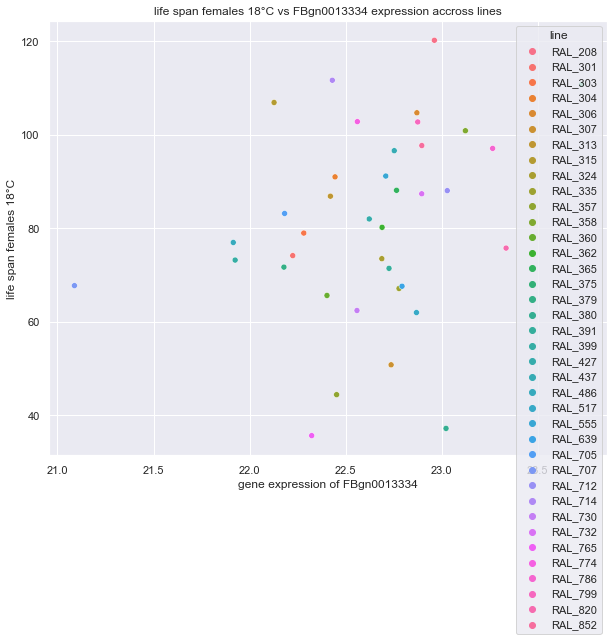

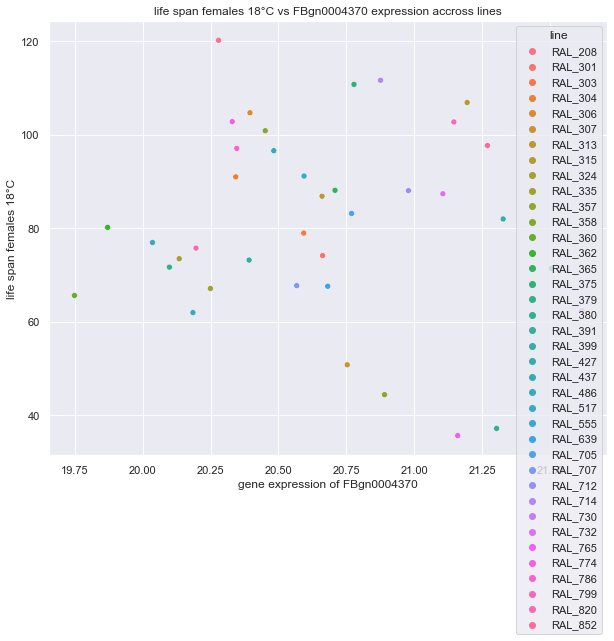

In [130]:
for i in range(len(top_genes_cognition_females)-1):
    plot_phenotypic_data_vs_gene(merged_females_LF, top_genes_cognition_females[i], 'life span females 18°C')

### Males 

In [131]:
merged_males_LF = pd.merge(life_span[['line', 'life span males 18°C']], males_cognition_data_top, left_on='line', right_on='line', how='inner')
merged_males_LF.head()

line life span males 18°C  FBgn0000273  FBgn0003371  FBgn0013334  \
0  RAL_208              127.125     20.79381     10.56715     23.05228   
1  RAL_301              106.312     23.08654     10.70844     22.55886   
2  RAL_303              101.266     22.20897     10.84502     22.72855   
3  RAL_304              92.6769     20.94015     11.05783     22.99439   
4  RAL_306              89.3571     21.15718     11.10842     23.15257   

   FBgn0051148  FBgn0051414  
0     10.89426    19.973497  
1     12.44683    21.197886  
2     10.71158    19.702708  
3     11.21948    20.330065  
4     10.82261    19.666373

In [132]:
# We now look at the correlations between life span data and the selected genes for cognition
sr_correlations_life_span_males = pd.DataFrame()
sr_correlations_life_span_males['correlated_gene'] = top_genes_cognition_males[:-1]
sr_correlations_life_span_males['sr_correlation'] = sr_correlations_life_span_males.apply(lambda x: stats.spearmanr(merged_males_LF['life span males 18°C'], merged_males_LF[x['correlated_gene']])[0], axis=1)
sr_correlations_life_span_males['p_value'] = sr_correlations_life_span_males.apply(lambda x: stats.spearmanr(merged_males_LF['life span males 18°C'], merged_males_LF[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_life_span_males['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_life_span_males['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_life_span_males['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_life_span_males['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_life_span_males

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0000273        0.043003  0.797682                    1.0   
1     FBgn0051148        0.116315  0.486788                    1.0   
2     FBgn0051414        0.070139  0.675627                    1.0   
3     FBgn0013334        0.171244  0.303962                    1.0   
4     FBgn0003371        0.093993  0.574593                    1.0   

   Benjamini/Hochberg correction  
0                       0.797682  
1                       0.797682  
2                       0.797682  
3                       0.797682  
4                       0.797682

No significant correlations.

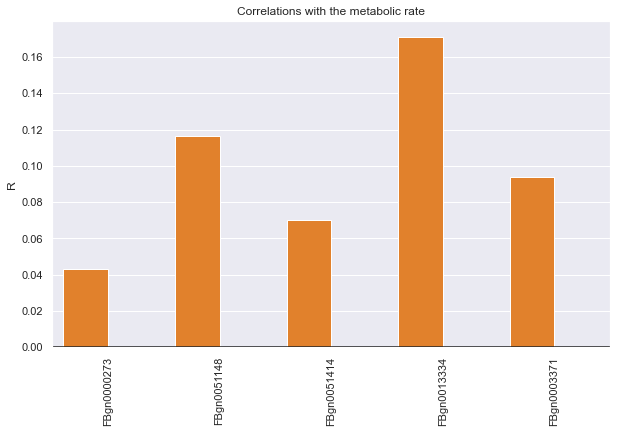

In [133]:
plot_correlations(sr_correlations_life_span_males)

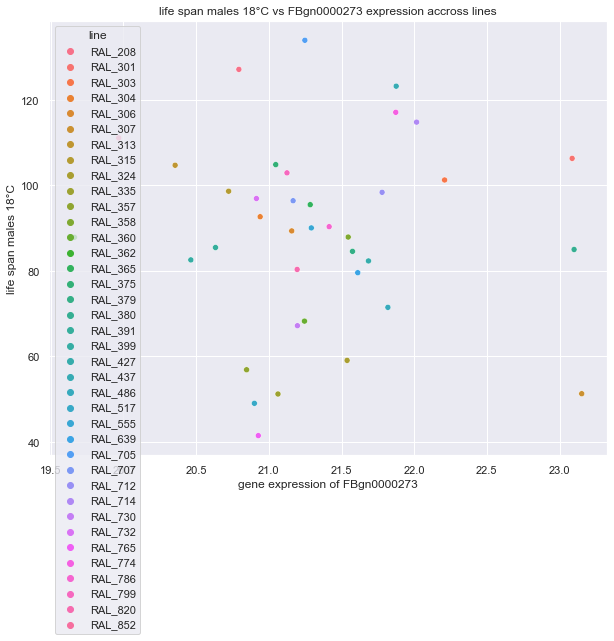

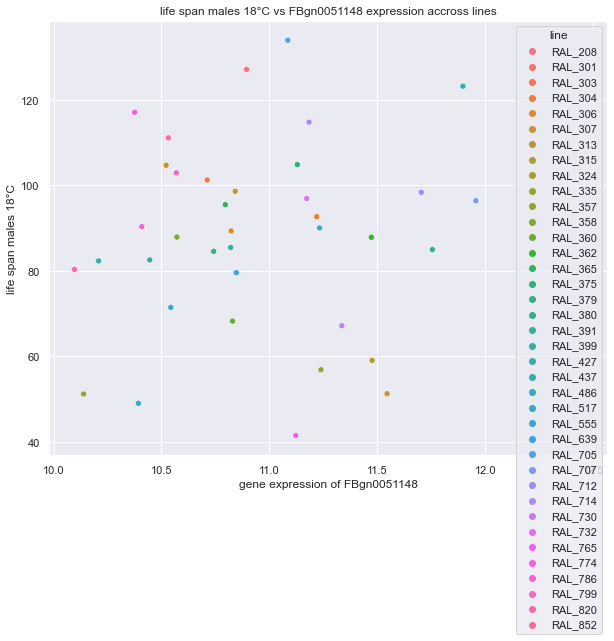

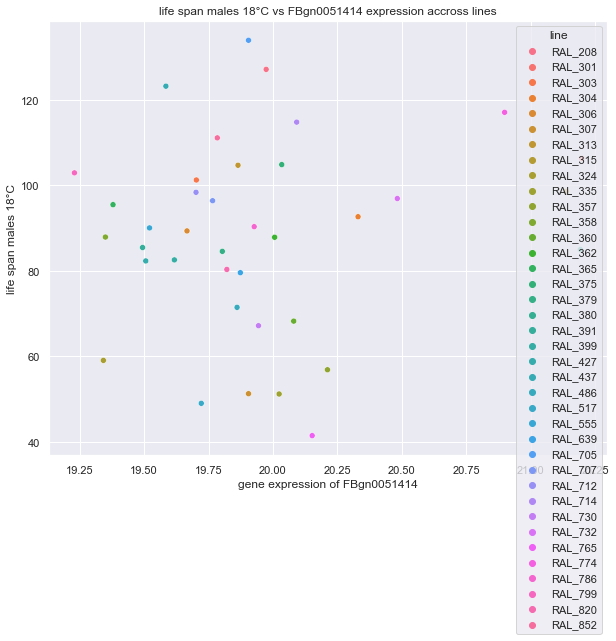

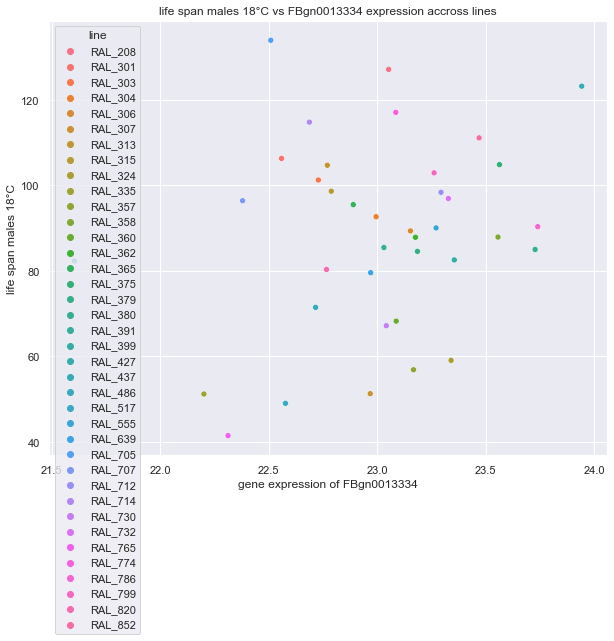

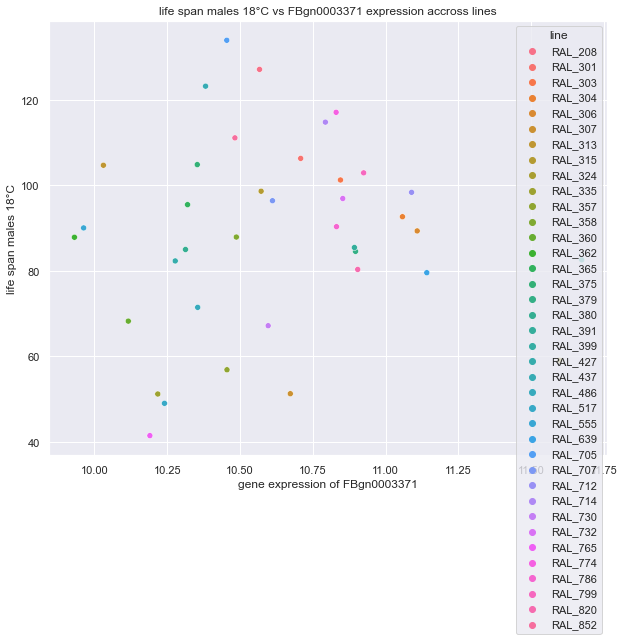

In [134]:
for i in range(len(top_genes_cognition_males)-1):
    plot_phenotypic_data_vs_gene(merged_males_LF, top_genes_cognition_males[i], 'life span males 18°C')

# HDAC expression

In [135]:
# List of genes coding for HDACs found on flybase.org
HDAC_genes_conversion = {'HDAC1': 'FBgn0015805', 'HDAC3': 'FBgn0025825', 'HDAC4': 'FBgn0041210', 
                         'HDAC6': 'FBgn0026428', 'HDAC11': 'FBgn0051119'} # conversion table to FlyBase IDs
HDAC_genes_names = list(HDAC_genes_conversion.values())
HDAC_genes_names.append('line')
HDAC_genes_names

['FBgn0015805',
 'FBgn0025825',
 'FBgn0041210',
 'FBgn0026428',
 'FBgn0051119',
 'line']

In [136]:
# Just keep columns in the transcription data that correspond to these genes coding for HDACs
HDAC_genes_females = females_transcription.columns.intersection(HDAC_genes_names)
HDAC_genes_data_females = females_transcription[HDAC_genes_females]
HDAC_genes_data_females.head()

line     line  FBgn0015805  FBgn0025825  FBgn0026428  FBgn0051119
0     RAL_208     11.85725     11.33033     12.54580     10.35738
1     RAL_301     12.24746     11.43368     12.49786     10.34955
2     RAL_303     12.13476     11.49201     12.25118     10.31055
3     RAL_304     12.26937     11.52977     12.37071     10.48426
4     RAL_306     11.88028     11.52881     12.29750     10.57422

In [137]:
HDAC_genes_males = males_transcription.columns.intersection(HDAC_genes_names)
HDAC_genes_data_males = males_transcription[HDAC_genes_males]
HDAC_genes_data_males.head()

line     line  FBgn0015805  FBgn0025825  FBgn0026428  FBgn0051119
40    RAL_208     10.48978     10.69214     12.19732     10.09790
41    RAL_301     10.56935     10.49563     12.04531     10.07653
42    RAL_303     10.57283     10.71072     12.06693     10.03623
43    RAL_304     10.38841     10.78819     12.68291     10.24524
44    RAL_306     10.76541     10.65231     12.71859     10.15433

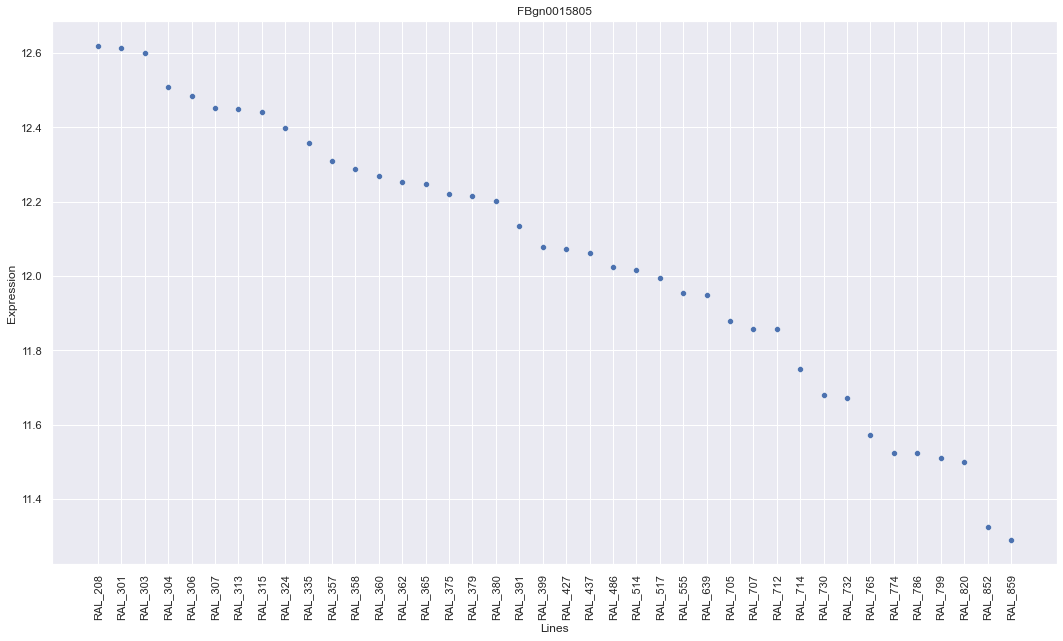

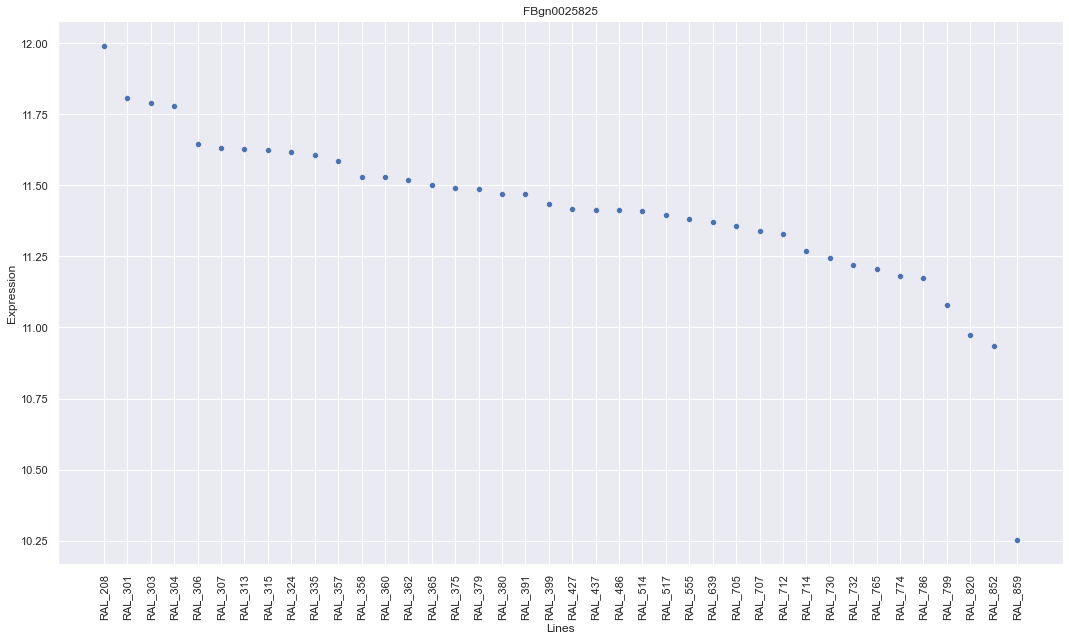

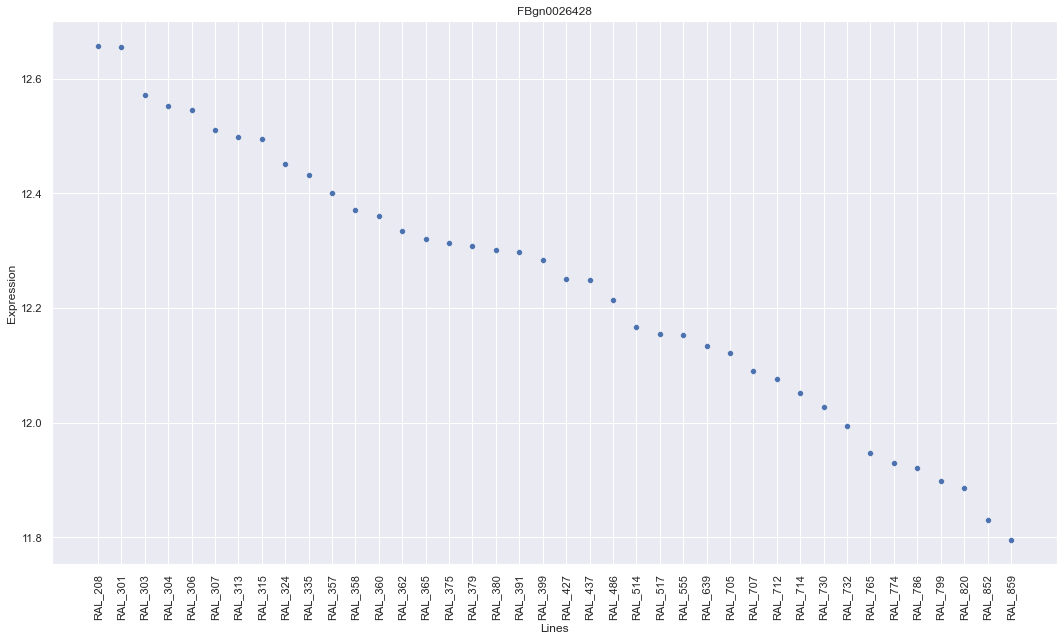

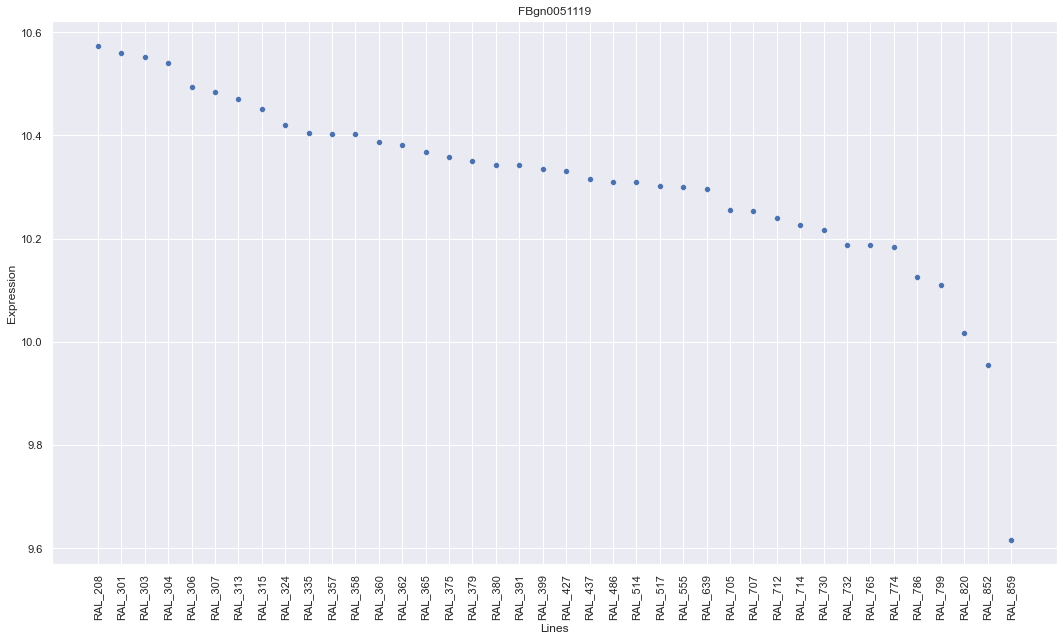

In [138]:
for i in range(len(HDAC_genes_females)-1):
    plot_gene_expression(HDAC_genes_females[i+1], HDAC_genes_data_females) #i+1 because of 'line' at the top of the list

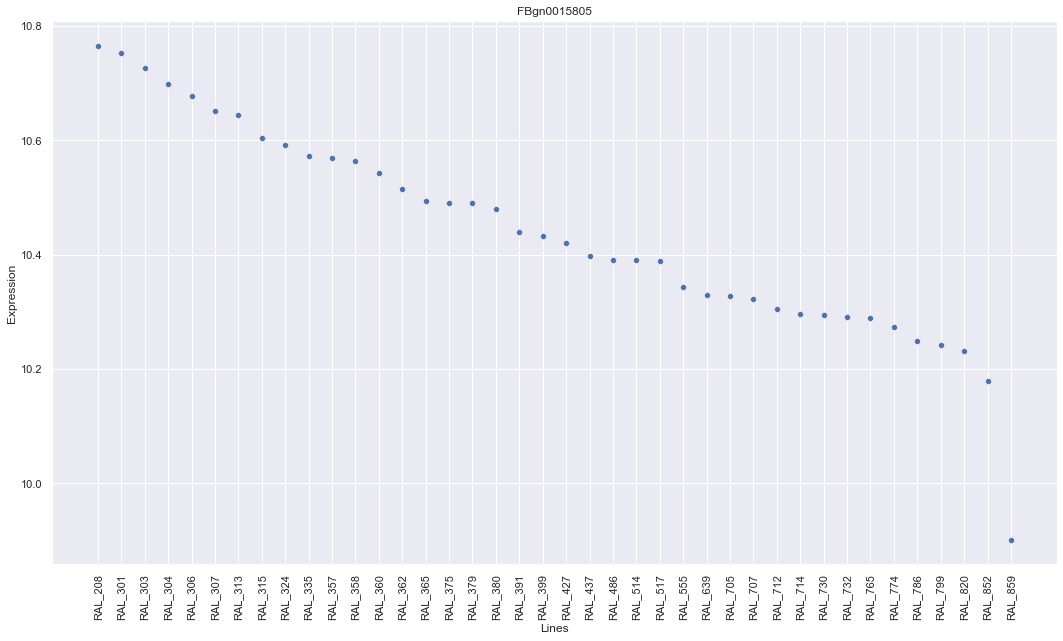

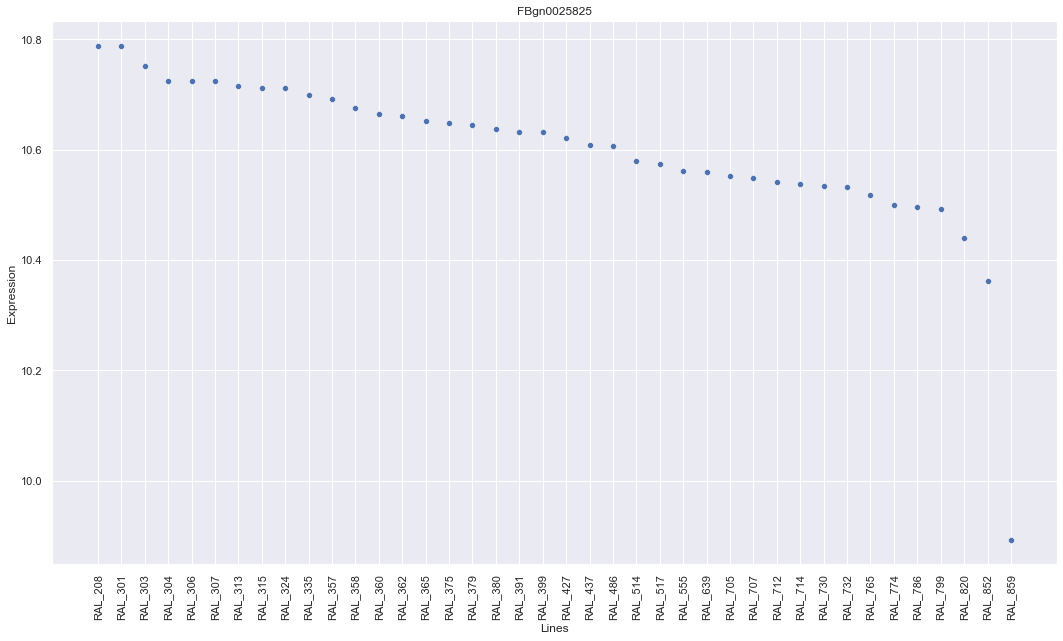

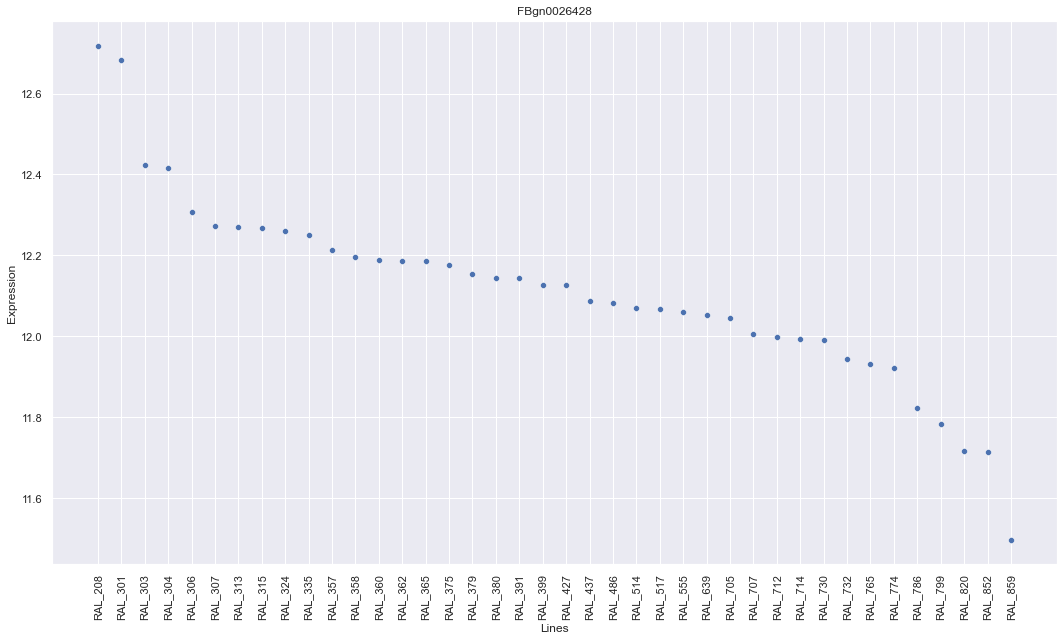

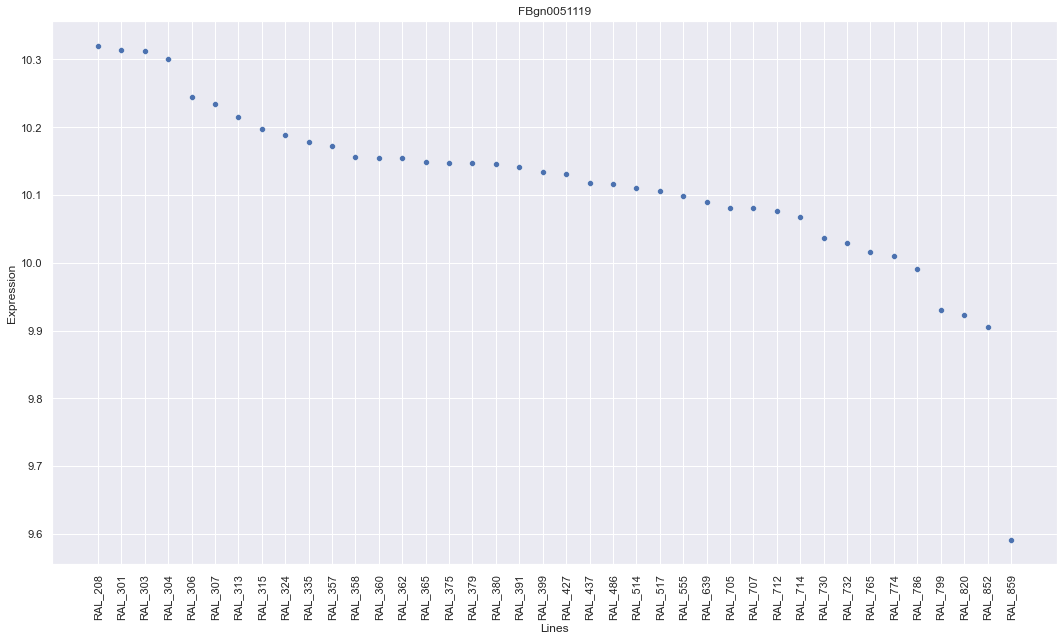

In [139]:
for i in range(len(HDAC_genes_males)-1):
    plot_gene_expression(HDAC_genes_males[i+1], HDAC_genes_data_males) #i+1 because of 'line' at the top of the list

## Link with metabolic rate

In [140]:
# Merge on lines to have the same ordering in the table
merged = pd.merge(metabolic_rate, HDAC_genes_data_females, left_on='line', right_on='line', how='inner')
merged.head()

line  metabolic rate  FBgn0015805  FBgn0025825  FBgn0026428  FBgn0051119
0  RAL_707            1.57     11.67949     10.93653     11.92105     9.955589
1  RAL_712            1.59     11.99562     11.38190     12.16777    10.309070
2  RAL_852            1.59     12.48311     11.60655     12.43269    10.226610
3  RAL_427            1.41     12.44154     11.99157     12.57151    10.110810
4  RAL_799            1.57     12.61447     11.64384     12.24891    10.420110

In [141]:
# Compute the Spearman rank correlation for each pair of metabolic rate - HDAC gene of interest
sr_correlations_HDAC_metabolic_rate= pd.DataFrame()
sr_correlations_HDAC_metabolic_rate['correlated_gene'] = HDAC_genes_females[1:] # the first element is the line
sr_correlations_HDAC_metabolic_rate['sr_correlation'] = sr_correlations_HDAC_metabolic_rate.apply(lambda x: stats.spearmanr(merged['metabolic rate'], merged[x['correlated_gene']])[0], axis=1)
sr_correlations_HDAC_metabolic_rate['p_value'] = sr_correlations_HDAC_metabolic_rate.apply(lambda x: stats.spearmanr(merged['metabolic rate'], merged[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_HDAC_metabolic_rate['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_metabolic_rate['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_HDAC_metabolic_rate['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_metabolic_rate['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_HDAC_metabolic_rate

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0015805        0.194995  0.396974                    1.0   
1     FBgn0025825        0.118947  0.607576                    1.0   
2     FBgn0026428       -0.168346  0.465726                    1.0   
3     FBgn0051119       -0.040299  0.862310                    1.0   

   Benjamini/Hochberg correction  
0                       0.810102  
1                       0.810102  
2                       0.810102  
3                       0.862310

No significant correlations.

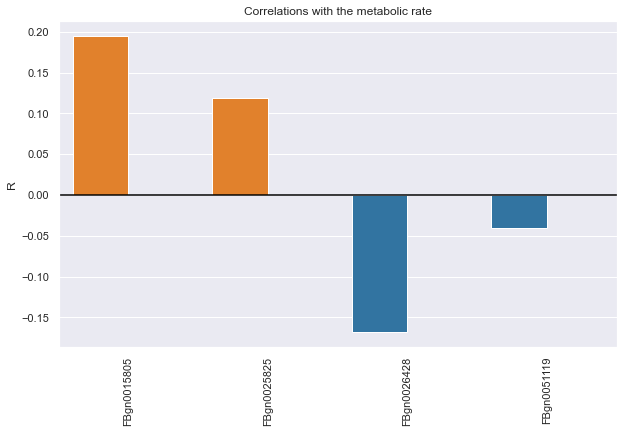

In [142]:
plot_correlations(sr_correlations_HDAC_metabolic_rate)

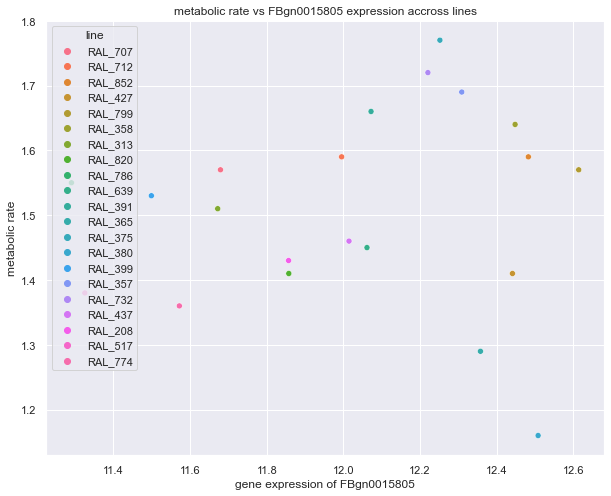

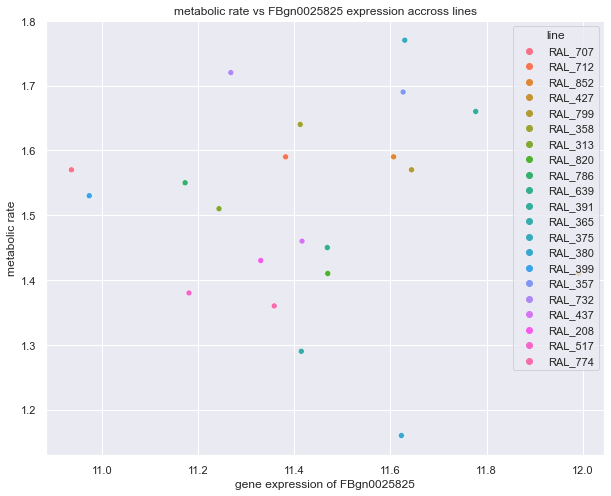

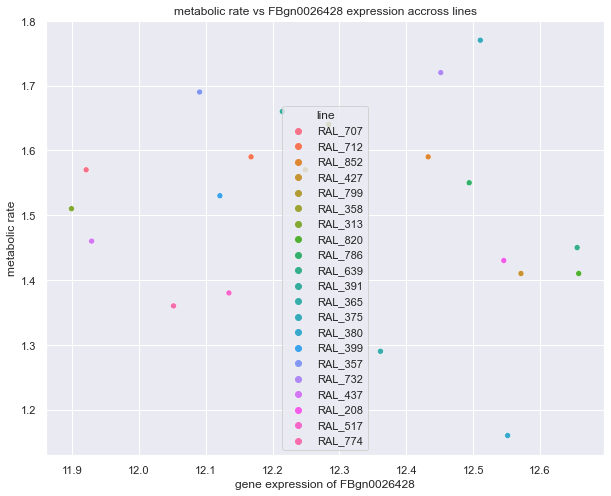

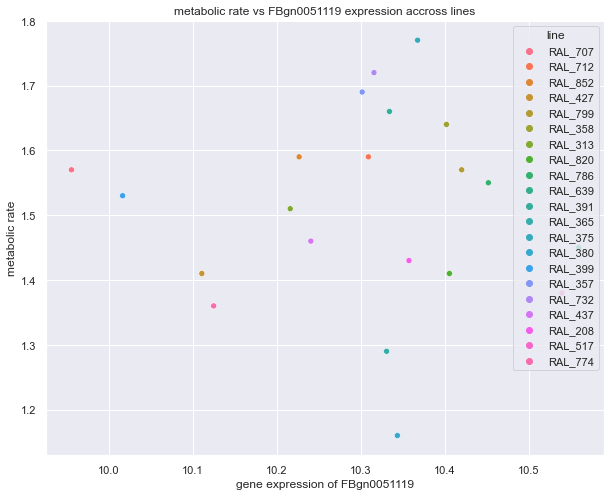

In [143]:
for i in range(len(HDAC_genes_females)-1):
    plot_phenotypic_data_vs_gene(merged, HDAC_genes_females[i+1], 'metabolic rate')

## Link with life span

### Females

In [144]:
# Merge on lines to have the same ordering in the table
merged_females = pd.merge(life_span[['line', 'life span females 18°C']], HDAC_genes_data_females, left_on='line', right_on='line', how='inner')
merged_females.head()

line life span females 18°C  FBgn0015805  FBgn0025825  FBgn0026428  \
0  RAL_208                 120.18     11.85725     11.33033     12.54580   
1  RAL_301                74.1304     12.24746     11.43368     12.49786   
2  RAL_303                78.9524     12.13476     11.49201     12.25118   
3  RAL_304                90.9692     12.26937     11.52977     12.37071   
4  RAL_306                104.678     11.88028     11.52881     12.29750   

   FBgn0051119  
0     10.35738  
1     10.34955  
2     10.31055  
3     10.48426  
4     10.57422

In [145]:
# Compute the Spearman rank correlation for each pair of life span - HDAC gene of interest
sr_correlations_HDAC_life_span_females = pd.DataFrame()
sr_correlations_HDAC_life_span_females['correlated_gene'] = HDAC_genes_females[1:] # the first element is the line
sr_correlations_HDAC_life_span_females['sr_correlation'] = sr_correlations_HDAC_life_span_females.apply(lambda x: stats.spearmanr(merged_females['life span females 18°C'], merged_females[x['correlated_gene']])[0], axis=1)
sr_correlations_HDAC_life_span_females['p_value'] = sr_correlations_HDAC_life_span_females.apply(lambda x: stats.spearmanr(merged_females['life span females 18°C'], merged_females[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_HDAC_life_span_females['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_life_span_females['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_HDAC_life_span_females['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_life_span_females['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_HDAC_life_span_females

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0015805       -0.007769  0.963078               1.000000   
1     FBgn0025825        0.033155  0.843354               1.000000   
2     FBgn0026428        0.205602  0.215582               0.862328   
3     FBgn0051119       -0.052632  0.753656               1.000000   

   Benjamini/Hochberg correction  
0                       0.963078  
1                       0.963078  
2                       0.862328  
3                       0.963078

No significant correlations.

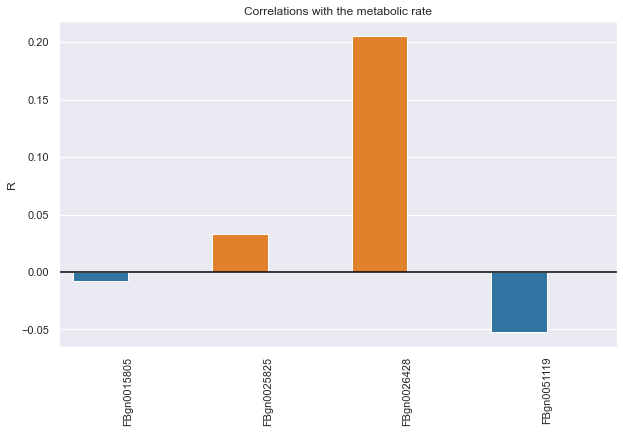

In [146]:
plot_correlations(sr_correlations_HDAC_life_span_females)

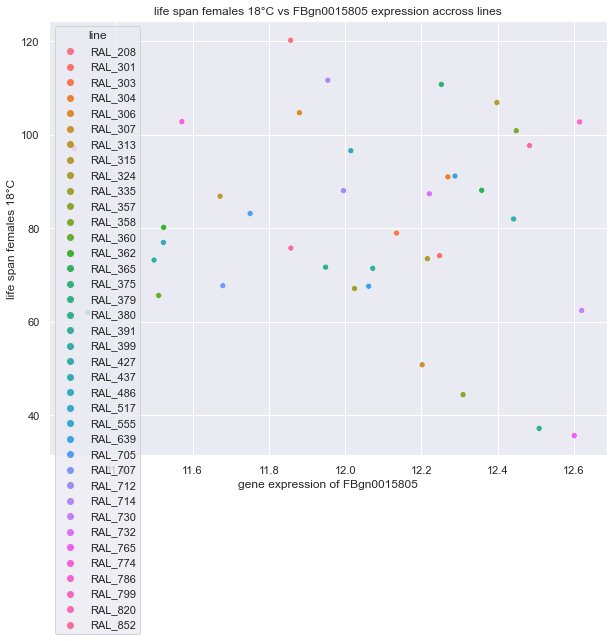

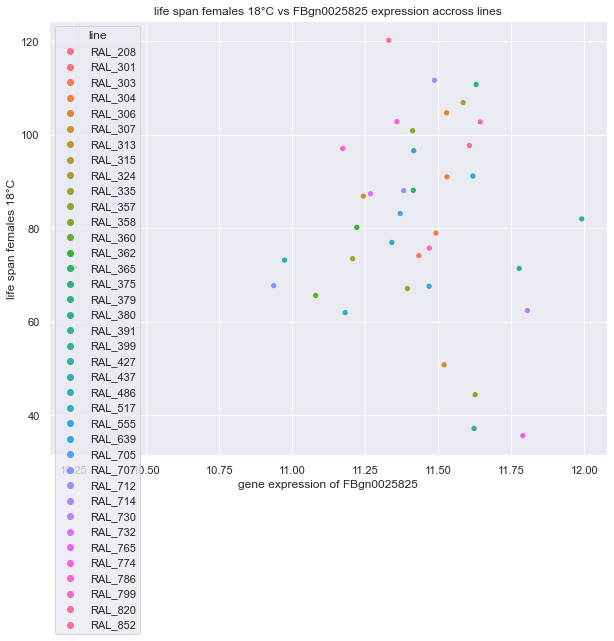

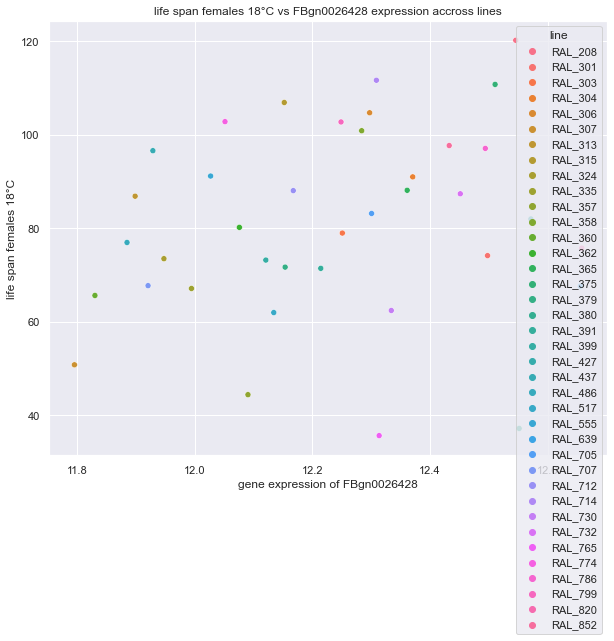

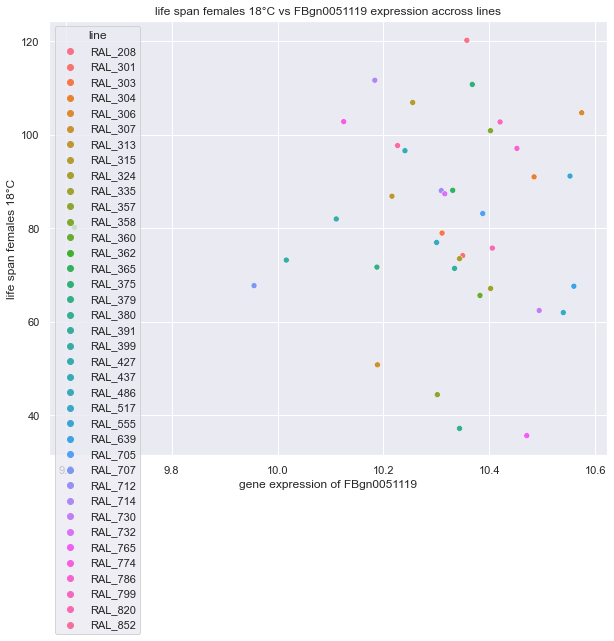

In [147]:
for i in range(len(HDAC_genes_females)-1):
    plot_phenotypic_data_vs_gene(merged_females, HDAC_genes_females[i+1], 'life span females 18°C')

### Males

In [148]:
merged_males = pd.merge(life_span[['line', 'life span males 18°C']], HDAC_genes_data_males, left_on='line', right_on='line', how='inner')
merged_males.head()

line life span males 18°C  FBgn0015805  FBgn0025825  FBgn0026428  \
0  RAL_208              127.125     10.48978     10.69214     12.19732   
1  RAL_301              106.312     10.56935     10.49563     12.04531   
2  RAL_303              101.266     10.57283     10.71072     12.06693   
3  RAL_304              92.6769     10.38841     10.78819     12.68291   
4  RAL_306              89.3571     10.76541     10.65231     12.71859   

   FBgn0051119  
0     10.09790  
1     10.07653  
2     10.03623  
3     10.24524  
4     10.15433

In [149]:
# Compute the Spearman rank correlation for each pair of life span - HDAC gene of interest
sr_correlations_HDAC_life_span_males = pd.DataFrame()
sr_correlations_HDAC_life_span_males['correlated_gene'] = HDAC_genes_males[1:] # the first element is the line
sr_correlations_HDAC_life_span_males['sr_correlation'] = sr_correlations_HDAC_life_span_males.apply(lambda x: stats.spearmanr(merged_males['life span males 18°C'], merged_males[x['correlated_gene']])[0], axis=1)
sr_correlations_HDAC_life_span_males['p_value'] = sr_correlations_HDAC_life_span_males.apply(lambda x: stats.spearmanr(merged_males['life span males 18°C'], merged_males[x['correlated_gene']])[1], axis=1)

# Bonferroni correction for the multiple comparisons
sr_correlations_HDAC_life_span_males['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_life_span_males['p_value'], alpha=0.05, method='bonferroni')[1]

# Benjamini/Hochberg (non-negative) correction
sr_correlations_HDAC_life_span_males['Benjamini/Hochberg correction'] = sm.stats.multitest.multipletests(pvals=sr_correlations_HDAC_life_span_males['p_value'], alpha=0.05, method='fdr_bh')[1]
sr_correlations_HDAC_life_span_males

correlated_gene  sr_correlation   p_value  Bonferroni correction  \
0     FBgn0015805        0.122880  0.462357                    1.0   
1     FBgn0025825       -0.009082  0.956843                    1.0   
2     FBgn0026428        0.024839  0.882324                    1.0   
3     FBgn0051119       -0.119597  0.474490                    1.0   

   Benjamini/Hochberg correction  
0                       0.948980  
1                       0.956843  
2                       0.956843  
3                       0.948980

No significant correlations.

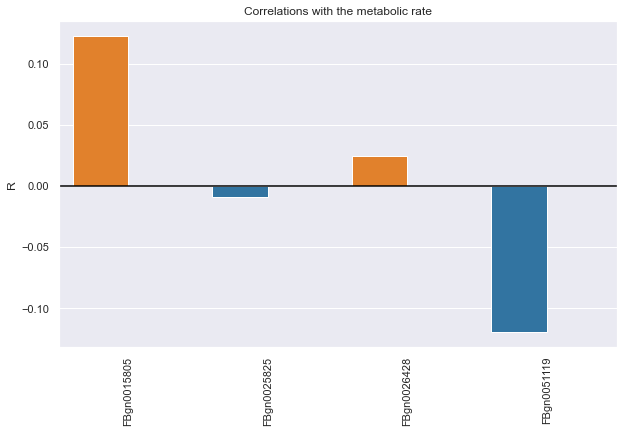

In [150]:
plot_correlations(sr_correlations_HDAC_life_span_males)

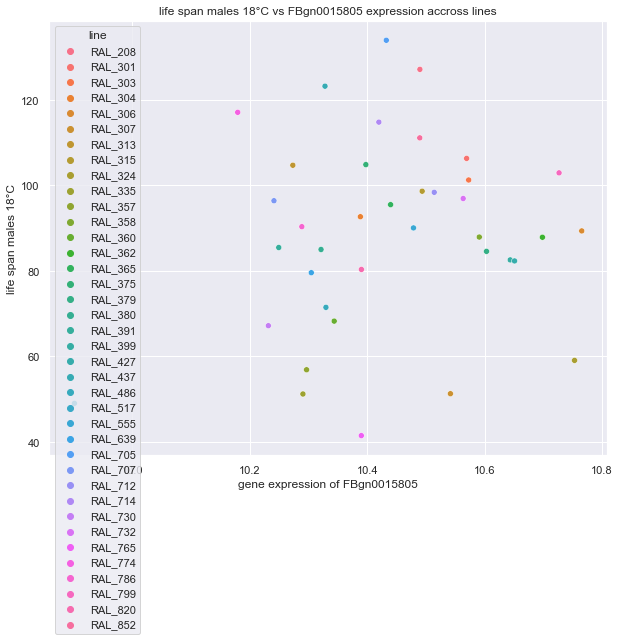

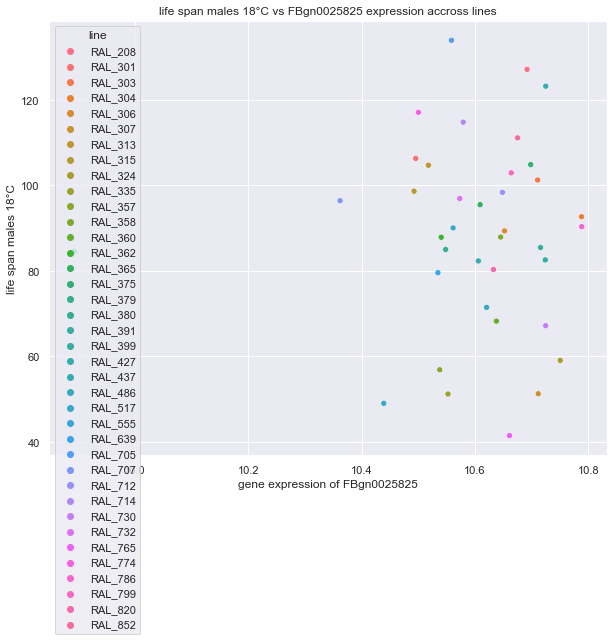

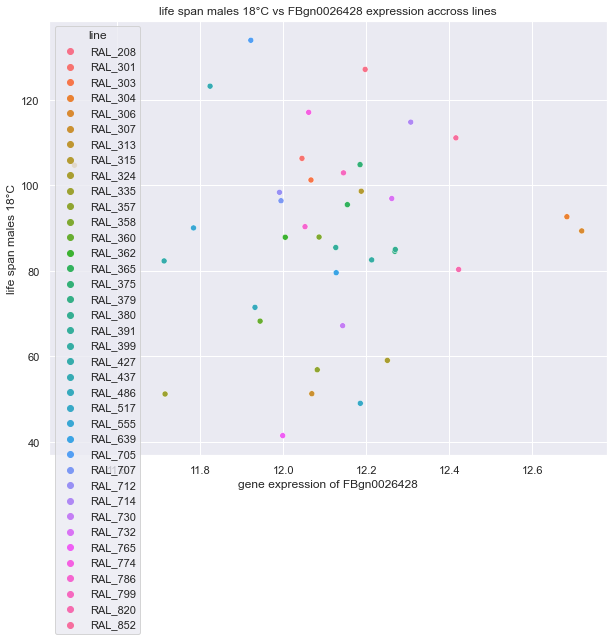

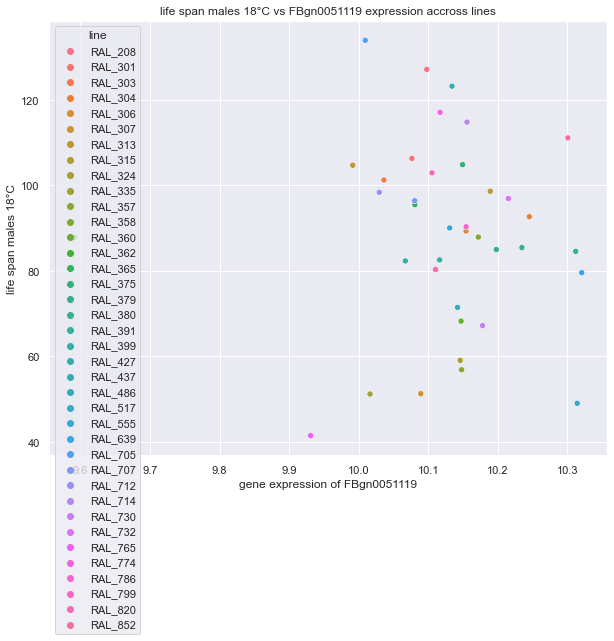

In [151]:
for i in range(len(HDAC_genes_males)-1):
    plot_phenotypic_data_vs_gene(merged_males, HDAC_genes_males[i+1], 'life span males 18°C')

# Finer analysis of the 5 most variable genes related to cognition

Let's analyse more in details the 5 lines that express the most and the least these 5 most variable genes:

In [152]:
# Return the 5 lines that express the most and the 5 lines that express the least the gene given as parameter
def highest_lowest_lines(df, gene):
    sorted_df = df.sort_values(by=[gene], ascending=False).copy()
    highest = sorted_df.head(n=5)
    lowest = sorted_df.tail(n=5)
    return highest, lowest

## Link with the metabolic rate (females only)

In [291]:
# Compute the correlation and p-value between one gene and one trait for the 10 extreme lines
def compute_corr(df_trait, df_gene, trait, gene):
    
    # Retrieve the 10 extreme lines for the expression of the gene of interest
    df_highest, df_lowest = highest_lowest_lines(df_gene, gene)
    concat = pd.concat([df_highest, df_lowest])
    concat.index.name = None
    
    # Keep only lines where data about the observed phenotypic trait is present
    merged = pd.merge(df_trait, concat, left_on='line', right_on='line', how='inner')
    
    # Compute and print the Spearman's rank correlation (without correction)
    corr, p_val = stats.spearmanr(merged[trait], merged[gene])
    print("Gene: " + gene + ", Trait: " + trait + "\n Spearman's rank correlation: %5f    p-value: %5f" % (corr, p_val));
    
    return corr, p_val;

In [292]:
top_genes_cognition_females[:-1]

['FBgn0000273', 'FBgn0051148', 'FBgn0003520', 'FBgn0013334', 'FBgn0004370']

In [320]:
corrs_MR_COG_F = []
p_vals_MR_COG_F = []

for gene in top_genes_cognition_females[:-1]:
    corr, p_val = compute_corr(metabolic_rate, females_cognition_data_top, 'metabolic rate', gene)
    corrs_MR_COG_F.append(corr)
    p_vals_MR_COG_F.append(p_val)    
    
correlations_MR_COG_F = pd.DataFrame(list(zip(corrs_MR_COG_F, p_vals_MR_COG_F)), 
               columns =['correlation', 'p_value']) 
correlations_MR_COG_F['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_MR_COG_F['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_MR_COG_F

Gene: FBgn0000273, Trait: metabolic rate
 Spearman's rank correlation: 0.000000    p-value: 1.000000
Gene: FBgn0051148, Trait: metabolic rate
 Spearman's rank correlation: 0.100000    p-value: 0.872889
Gene: FBgn0003520, Trait: metabolic rate
 Spearman's rank correlation: 0.400000    p-value: 0.600000
Gene: FBgn0013334, Trait: metabolic rate
 Spearman's rank correlation: 0.142857    p-value: 0.787172
Gene: FBgn0004370, Trait: metabolic rate
 Spearman's rank correlation: 0.400000    p-value: 0.600000


correlation   p_value  Bonferroni correction
0     0.000000  1.000000                    1.0
1     0.100000  0.872889                    1.0
2     0.400000  0.600000                    1.0
3     0.142857  0.787172                    1.0
4     0.400000  0.600000                    1.0

Non significant correlations, even without correction for multiple comparisons.

## Link with the life span 

Females:

In [294]:
merged_females_LF_ = merged_females_LF[['line', 'life span females 18°C']]
merged_females_LF_.head()

line life span females 18°C
0  RAL_208                 120.18
1  RAL_301                74.1304
2  RAL_303                78.9524
3  RAL_304                90.9692
4  RAL_306                104.678

In [321]:
corrs_LF_COG_F = []
p_vals_LF_COG_F = []

for gene in top_genes_cognition_females[:-1]:
    corr, p_val = compute_corr(merged_females_LF_, females_cognition_data_top, 'life span females 18°C', gene)
    corrs_LF_COG_F.append(corr)
    p_vals_LF_COG_F.append(p_val)
    
correlations_LF_COG_F = pd.DataFrame(list(zip(corrs_LF_COG_F, p_vals_LF_COG_F)), 
               columns =['correlation', 'p_value']) 
correlations_LF_COG_F['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_LF_COG_F['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_LF_COG_F

Gene: FBgn0000273, Trait: life span females 18°C
 Spearman's rank correlation: -0.418182    p-value: 0.229113
Gene: FBgn0051148, Trait: life span females 18°C
 Spearman's rank correlation: -0.539394    p-value: 0.107593
Gene: FBgn0003520, Trait: life span females 18°C
 Spearman's rank correlation: 0.357576    p-value: 0.310376
Gene: FBgn0013334, Trait: life span females 18°C
 Spearman's rank correlation: 0.566667    p-value: 0.111633
Gene: FBgn0004370, Trait: life span females 18°C
 Spearman's rank correlation: -0.212121    p-value: 0.556306


correlation   p_value  Bonferroni correction
0    -0.418182  0.229113                    1.0
1    -0.539394  0.107593                    1.0
2     0.357576  0.310376                    1.0
3     0.566667  0.111633                    1.0
4    -0.212121  0.556306                    1.0

Males:

In [301]:
merged_males_LF_ = merged_males_LF[['line', 'life span males 18°C']]
merged_males_LF_.head()

line life span males 18°C
0  RAL_208              127.125
1  RAL_301              106.312
2  RAL_303              101.266
3  RAL_304              92.6769
4  RAL_306              89.3571

In [322]:
corrs_LF_COG_M = []
p_vals_LF_COG_M = []

for gene in top_genes_cognition_males[:-1]:
    corr, p_val = compute_corr(merged_males_LF_, males_cognition_data_top, 'life span males 18°C', gene)
    corrs_LF_COG_M.append(corr)
    p_vals_LF_COG_M.append(p_val)
    
correlations_LF_COG_M = pd.DataFrame(list(zip(corrs_LF_COG_M, p_vals_LF_COG_M)), 
               columns =['correlation', 'p_value']) 
correlations_LF_COG_M['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_LF_COG_M['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_LF_COG_M

Gene: FBgn0000273, Trait: life span males 18°C
 Spearman's rank correlation: -0.476190    p-value: 0.232936
Gene: FBgn0051148, Trait: life span males 18°C
 Spearman's rank correlation: 0.587879    p-value: 0.073878
Gene: FBgn0051414, Trait: life span males 18°C
 Spearman's rank correlation: 0.300000    p-value: 0.432845
Gene: FBgn0013334, Trait: life span males 18°C
 Spearman's rank correlation: 0.575758    p-value: 0.081553
Gene: FBgn0003371, Trait: life span males 18°C
 Spearman's rank correlation: -0.500000    p-value: 0.170471


correlation   p_value  Bonferroni correction
0    -0.476190  0.232936               1.000000
1     0.587879  0.073878               0.369389
2     0.300000  0.432845               1.000000
3     0.575758  0.081553               0.407764
4    -0.500000  0.170471               0.852353

# Finer analysis of the 5 most variable genes related to cognition

## Link with the metabolic rate

Females:

In [312]:
HDAC_genes_females.to_list()

['line', 'FBgn0015805', 'FBgn0025825', 'FBgn0026428', 'FBgn0051119']

In [323]:
corrs_MR_HDAC_F = []
p_vals_MR_HDAC_F = []

for gene in HDAC_genes_females.to_list()[1:]:
    corr, p_val = compute_corr(metabolic_rate, HDAC_genes_data_females, 'metabolic rate', gene)
    corrs_MR_HDAC_F.append(corr)
    p_vals_MR_HDAC_F.append(p_val)

correlations_MR_HDAC_F = pd.DataFrame(list(zip(corrs_MR_HDAC_F, p_vals_MR_HDAC_F)), 
               columns =['correlation', 'p_value']) 
correlations_MR_HDAC_F['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_MR_HDAC_F['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_MR_HDAC_F

Gene: FBgn0015805, Trait: metabolic rate
 Spearman's rank correlation: 0.142857    p-value: 0.787172
Gene: FBgn0025825, Trait: metabolic rate
 Spearman's rank correlation: -0.115954    p-value: 0.826848
Gene: FBgn0026428, Trait: metabolic rate
 Spearman's rank correlation: -0.576600    p-value: 0.175382
Gene: FBgn0051119, Trait: metabolic rate
 Spearman's rank correlation: -0.600000    p-value: 0.208000


correlation   p_value  Bonferroni correction
0     0.142857  0.787172               1.000000
1    -0.115954  0.826848               1.000000
2    -0.576600  0.175382               0.701527
3    -0.600000  0.208000               0.832000

## Link with the life span

Females:

In [324]:
corrs_LF_HDAC_F = []
p_vals_LF_HDAC_F = []

for gene in HDAC_genes_females.to_list()[1:]:
    corr, p_val = compute_corr(merged_females_LF_, HDAC_genes_data_females, 'life span females 18°C', gene)
    corrs_LF_HDAC_F.append(corr)
    p_vals_LF_HDAC_F.append(p_val)
    
correlations_LF_HDAC_F = pd.DataFrame(list(zip(corrs_LF_HDAC_F, p_vals_LF_HDAC_F)), 
               columns =['correlation', 'p_value']) 
correlations_LF_HDAC_F['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_LF_HDAC_F['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_LF_HDAC_F

Gene: FBgn0015805, Trait: life span females 18°C
 Spearman's rank correlation: -0.115152    p-value: 0.751420
Gene: FBgn0025825, Trait: life span females 18°C
 Spearman's rank correlation: -0.115152    p-value: 0.751420
Gene: FBgn0026428, Trait: life span females 18°C
 Spearman's rank correlation: 0.175758    p-value: 0.627188
Gene: FBgn0051119, Trait: life span females 18°C
 Spearman's rank correlation: 0.115152    p-value: 0.751420


correlation   p_value  Bonferroni correction
0    -0.115152  0.751420                    1.0
1    -0.115152  0.751420                    1.0
2     0.175758  0.627188                    1.0
3     0.115152  0.751420                    1.0

Males:

In [325]:
corrs_LF_HDAC_M = []
p_vals_LF_HDAC_M = []

for gene in HDAC_genes_males.to_list()[1:]:
    corr, p_val = compute_corr(merged_males_LF_, HDAC_genes_data_males, 'life span males 18°C', gene)
    corrs_LF_HDAC_M.append(corr)
    p_vals_LF_HDAC_M.append(p_val)

correlations_LF_HDAC_M = pd.DataFrame(list(zip(corrs_LF_HDAC_M, p_vals_LF_HDAC_M)), 
               columns =['correlation', 'p_value']) 
correlations_LF_HDAC_M['Bonferroni correction'] = sm.stats.multitest.multipletests(pvals=correlations_LF_HDAC_M['p_value'], alpha=0.05, method='bonferroni')[1]
correlations_LF_HDAC_M  

Gene: FBgn0015805, Trait: life span males 18°C
 Spearman's rank correlation: 0.116667    p-value: 0.765008
Gene: FBgn0025825, Trait: life span males 18°C
 Spearman's rank correlation: 0.042424    p-value: 0.907364
Gene: FBgn0026428, Trait: life span males 18°C
 Spearman's rank correlation: 0.042424    p-value: 0.907364
Gene: FBgn0051119, Trait: life span males 18°C
 Spearman's rank correlation: -0.190476    p-value: 0.651401


correlation   p_value  Bonferroni correction
0     0.116667  0.765008                    1.0
1     0.042424  0.907364                    1.0
2     0.042424  0.907364                    1.0
3    -0.190476  0.651401                    1.0